<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preprocessing</a></span><ul class="toc-item"><li><span><a href="#Read-data-saved-by-DataPreprocessing.R" data-toc-modified-id="Read-data-saved-by-DataPreprocessing.R-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Read data saved by DataPreprocessing.R</a></span></li></ul></li><li><span><a href="#Model-devolepment" data-toc-modified-id="Model-devolepment-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model devolepment</a></span><ul class="toc-item"><li><span><a href="#Split-dataset-to-train-and-test-dataset" data-toc-modified-id="Split-dataset-to-train-and-test-dataset-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Split dataset to train and test dataset</a></span></li><li><span><a href="#Some-base-function" data-toc-modified-id="Some-base-function-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Some base function</a></span></li><li><span><a href="#Construction-of-NeuralMultiTaskModel" data-toc-modified-id="Construction-of-NeuralMultiTaskModel-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Construction of NeuralMultiTaskModel</a></span></li><li><span><a href="#Construction-of-NonLinearCoxPHModel-(DeepSurv)" data-toc-modified-id="Construction-of-NonLinearCoxPHModel-(DeepSurv)-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Construction of NonLinearCoxPHModel (DeepSurv)</a></span></li><li><span><a href="#Construction-of-RandomSurvivalForestModel" data-toc-modified-id="Construction-of-RandomSurvivalForestModel-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Construction of RandomSurvivalForestModel</a></span></li><li><span><a href="#Construct-CPH-Model" data-toc-modified-id="Construct-CPH-Model-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Construct CPH Model</a></span></li><li><span><a href="#Hyperparameters-tuning" data-toc-modified-id="Hyperparameters-tuning-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Hyperparameters tuning</a></span><ul class="toc-item"><li><span><a href="#Tuning-NMTLR" data-toc-modified-id="Tuning-NMTLR-2.7.1"><span class="toc-item-num">2.7.1&nbsp;&nbsp;</span>Tuning NMTLR</a></span></li><li><span><a href="#Tuning-DeepSurv" data-toc-modified-id="Tuning-DeepSurv-2.7.2"><span class="toc-item-num">2.7.2&nbsp;&nbsp;</span>Tuning DeepSurv</a></span></li><li><span><a href="#Tuning-RSF" data-toc-modified-id="Tuning-RSF-2.7.3"><span class="toc-item-num">2.7.3&nbsp;&nbsp;</span>Tuning RSF</a></span></li></ul></li></ul></li><li><span><a href="#Metrics" data-toc-modified-id="Metrics-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Metrics</a></span><ul class="toc-item"><li><span><a href="#Generate-data-for-prediction-error-curve" data-toc-modified-id="Generate-data-for-prediction-error-curve-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Generate data for prediction error curve</a></span></li><li><span><a href="#Generate-data-for-calibration-curves-and-roc-curves" data-toc-modified-id="Generate-data-for-calibration-curves-and-roc-curves-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Generate data for calibration curves and roc curves</a></span></li><li><span><a href="#Generate-data-for-Loss-converge-graph" data-toc-modified-id="Generate-data-for-Loss-converge-graph-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Generate data for Loss converge graph</a></span></li><li><span><a href="#Feature-importance-plot" data-toc-modified-id="Feature-importance-plot-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Feature importance plot</a></span></li><li><span><a href="#Save-models" data-toc-modified-id="Save-models-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Save models</a></span></li></ul></li></ul></div>

# Deep learning models for predicting the survival of patients with chondrosarcoma based on a surveillance, epidemiology, and end results analysis

In [1]:
import torch
import random
import numpy as np
import os
def seed_everything(seed=42):
    """"
    Seed everything.
    """   
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
SEED = 11122 #random.randint(0,100000)
print(SEED)
seed_everything(SEED)

11122


In [245]:
np.seterr(divide='ignore', invalid='ignore') #Ignore warning: #RuntimeWarning: invalid value encountered in true_divide

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

## Preprocessing

### Read data saved by DataPreprocessing.R

In [3]:
import pandas as pd
dataset = pd.read_csv('./data/data_surv.csv')
dataset.columns = [name.replace('.',' ') for name in dataset.columns]
time_column = 'Survival months'
event_column = 'Status'
features = np.setdiff1d(dataset.columns, [time_column, event_column]).tolist()
dataset.head()

Age  Gender  Histological type  Primary site  Grade  Surgery  Tumor size  \
0   44       0                  0             1      0        3   81.945378   
1   51       0                  0             1      0        1   70.871131   
2   72       1                  0             0      1        1   87.110515   
3   59       1                  0             0      1        3  112.643443   
4   25       1                  0             0      0        1   50.101888   

   Tumor extension  Distant metastasis  Survival months  Status  
0                0                   0              213       0  
1                1                   0              208       0  
2                1                   0               19       1  
3                1                   0              216       0  
4                0                   0              219       0

In [4]:
dataset.shape

(3145, 11)

## Model devolepment
### Split dataset to train and test dataset

In [6]:
from sklearn.model_selection import train_test_split
import numpy as np
index_train, index_test = train_test_split(range(dataset.shape[0]), test_size = 0.3)
data_train = dataset.loc[index_train].reset_index( drop = True )
data_test  = dataset.loc[index_test].reset_index( drop = True )
# Creating the X, T and E inputs
X_train, X_test = data_train[features], data_test[features]
T_train, T_test = data_train[time_column], data_test[time_column]
E_train, E_test = data_train[event_column], data_test[event_column]

In [ ]:
data_train

In [7]:
data_train.shape, data_test.shape

((2201, 11), (944, 11))

In [252]:
from pysurvival.utils.metrics import concordance_index
from sklearn.model_selection import RepeatedKFold

### Some base function

In [253]:
class BaseFun:
    def parse_param(self, param):
        for key in param:
            if isinstance(param[key], str):
                param[key] = '"{}"'.format(param[key])
        return ','.join(['{} = {}'.format(key, param[key]) for key in param])
    def get_random_param(self,space):
        param = {}
        for key in space:
            if  key == 'structure':
                items = []
                for i in range(1,random.choice(space['structure']['num_layers'])+1):
                    items.append(
                        {
                        'activation': random.choice(space['structure']['activations']),
                        'num_units':random.choice(space['structure']['num_units'])
                        }
                    )
                param['structure'] = items
            else:
                param[key] = random.choice(space[key])
        return param
    def tuning_and_construct(self,X, T, E,max_iter=100):
        self.tuning_result = self.tuning_with_space(X, T, E,self.space,max_iter=max_iter)
        self.model = self.fit_model(X, T, E,**self.tuning_result['best_param'])
        return self.model
    def tuning_with_space(self,x,t,e,space,max_iter=100):
        [x,t,e] = [item if isinstance(item, np.ndarray) else np.array(item) for item in [x,t,e]]
        scores = []
        best_score = 0
        best_param = {}
        num = 1
        while True:
            param = self.get_random_param(space)
            print('Number {} iteration'.format(num), end=' ... ')
            # split train data to 5 parts
            rkf = RepeatedKFold(n_splits=5, n_repeats=1)
            score_iter = []
            for train_index, test_index in rkf.split(x):
                x_train, x_test = x[train_index], x[test_index]
                t_train, t_test = t[train_index], t[test_index]
                e_train, e_test = e[train_index], e[test_index]
                try:
                    model = self.fit_model(x_train, t_train, e_train,**param)
                    score = concordance_index(model, x_test, t_test, e_test)
                except Exception as err:
                    print(str(err))
                    break
                score_iter.append(score)
            mean_score = np.mean(score_iter)
            print('mean_c_index: ', mean_score, end=' ')
            if mean_score > best_score:
                best_score = mean_score
                best_param = param
                print('is the best so far')
            else:
                print('')
            scores.append({'iteration':num,'mean_score': mean_score, 'param': param})
            if num == max_iter:
                break
            num += 1
        return {'best_param': best_param, 'best_score': best_score, 'scores': scores}

### Construction of NeuralMultiTaskModel

In [255]:
from pysurvival.models.multi_task import NeuralMultiTaskModel
class NMTLR(BaseFun):
    def __init__(self):
        self.space = {
            'structure': {'num_layers':[1,2,3,4,5],
                          'num_units': [i for i in range(8, 100)],
                          'activations': ["Atan", "BentIdentity", "BipolarSigmoid", "CosReLU", 
                                           "Gaussian", "Hardtanh", "InverseSqrt", "LeakyReLU", 
                                          "LeCunTanh", "LogLog", "LogSigmoid", "ReLU", "SELU", "Sigmoid", 
                                          "Sinc", "SinReLU","Softmax", "Softplus", "Softsign", "Swish", "Tanh"]
                         },
            'optimizer':['adadelta','adagrad','adam','adamax','rmsprop','sgd'],
            'bins' : [i for i in range(10,100)],
            'lr': [round(1e-5 * i, 5) for i in range(1, 100 + 1)],
            'num_epochs': [i for i in range(50, 1000 + 1)],
            'dropout': [round(0.1 * i, 2) for i in range(1, 4 + 1)],
            'l2_reg': [round(0.0001 * i, 5) for i in range(1, 100 + 1)],
            'l2_smooth':[round(0.0001 * i, 5) for i in range(1, 100 + 1)],
            'batch_normalization' : [False, True]
        }
        self.model = None
    def fit_model(self,X, T, E,**kwargs):
        structure = [{'activation': 'ReLU', 'num_units': 128}]
        bins = 100
        if 'structure' in kwargs:
            structure = kwargs['structure']
            del kwargs['structure']
        if 'bins' in kwargs:
            bins = kwargs['bins']
            del kwargs['bins']
        self.model = NeuralMultiTaskModel(structure=structure,bins=bins)
        eval('self.model.fit(X, T, E,{})'.format(self.parse_param(kwargs)))
        return self.model

### Construction of NonLinearCoxPHModel (DeepSurv)

In [256]:
from pysurvival.models.semi_parametric import NonLinearCoxPHModel
class DeepSurv(BaseFun):
    def __init__(self):
        self.space = {
            'structure': {'num_layers':[1,2,3,4,5],
                          'num_units': [i for i in range(8, 100)],
                          'activations': ["Atan", "BentIdentity", "BipolarSigmoid", "CosReLU", 
                                           "Gaussian", "Hardtanh", "InverseSqrt", "LeakyReLU", 
                                          "LeCunTanh", "LogLog", "LogSigmoid", "ReLU", "SELU", "Sigmoid", 
                                          "Sinc", "SinReLU","Softmax", "Softplus", "Softsign", "Swish", "Tanh"]
                         },
            'optimizer':['adadelta','adagrad','adam','adamax','rmsprop','sgd'],
            'lr': [round(1e-5 * i, 5) for i in range(1, 100 + 1)],
            'num_epochs': [i for i in range(50, 5000 + 1)],
            'dropout': [round(0.1 * i, 2) for i in range(1, 4 + 1)],
            'l2_reg': [round(0.0001 * i, 5) for i in range(1, 100 + 1)],
            'batch_normalization' : [False, True]
        }
        self.model = None
    def fit_model(self,X, T, E,**kwargs):
        structure = [{'activation': 'ReLU', 'num_units': 128}]
        bins = 100
        if 'structure' in kwargs:
            structure = kwargs['structure']
            del kwargs['structure']
        self.model = NonLinearCoxPHModel(structure=structure)
        eval('self.model.fit(X, T, E,{})'.format(self.parse_param(kwargs)))
        return self.model

### Construction of RandomSurvivalForestModel

In [257]:
from pysurvival.models.survival_forest import RandomSurvivalForestModel
class RSF(BaseFun):
    def __init__(self):
        self.space = {
            'num_trees': [i for i in range(20, 1000 + 1)],
            'max_features': ['sqrt', 'log2', 'all', 0.1, 0.2],
            'min_node_size': [i for i in range(5, 80 + 1)],
            'sample_size_pct': [round(0.2 * i, 2) for i in range(1, 4 + 1)],
            'importance_mode': ['impurity', 'impurity_corrected', 'permutation', 'normalized_permutation']
        }
        self.model = None
    def fit_model(self,X, T, E,**kwargs):
        if 'num_trees' in kwargs:
            self.model = RandomSurvivalForestModel(num_trees=kwargs['num_trees'])
            del kwargs['num_trees']
        else:
            self.model = ConditionalSurvivalForestModel()
        eval('self.model.fit(X, T, E,seed=SEED,{})'.format(self.parse_param(kwargs)))
        return self.model

### Construct CPH Model

In [258]:
from pysurvival.models.semi_parametric import CoxPHModel
def cph(X_train, T_train, E_train):
    model = CoxPHModel()
    model.fit(X_train, T_train, E_train, lr=0.2, l2_reg=0.01)
    return model


In [259]:
cph_model = cph(X_train, T_train, E_train)
c_index_train = concordance_index(cph_model, X_train, T_train, E_train)
c_index_test = concordance_index(cph_model, X_test, T_test, E_test)
print('C-index of train: {:.4f}; C-index of test: {:.4f}'.format(c_index_train,c_index_test)) #C-index: 0.6996

Performing Newton-Raphson optimization
 * Iteration #1 - Loss = 4505.393 - ||grad||^2 = 983.27284
 * Iteration #2 - Loss = 4155.394 - ||grad||^2 = 636.65340
 * Iteration #3 - Loss = 4081.095 - ||grad||^2 = 506.60113
 * Iteration #4 - Loss = 4036.127 - ||grad||^2 = 404.68908
 * Iteration #5 - Loss = 4007.583 - ||grad||^2 = 324.06807
 * Iteration #6 - Loss = 3988.964 - ||grad||^2 = 259.81522
 * Iteration #7 - Loss = 3976.691 - ||grad||^2 = 208.38038
 * Iteration #8 - Loss = 3968.589 - ||grad||^2 = 167.12085
 * Iteration #9 - Loss = 3963.252 - ||grad||^2 = 133.99943
 * Iteration #10 - Loss = 3959.751 - ||grad||^2 = 107.40990
 * Iteration #11 - Loss = 3957.462 - ||grad||^2 = 86.07014
 * Iteration #12 - Loss = 3955.972 - ||grad||^2 = 68.95062
 * Iteration #13 - Loss = 3955.005 - ||grad||^2 = 55.22258
 * Iteration #14 - Loss = 3954.379 - ||grad||^2 = 44.21855
 * Iteration #15 - Loss = 3953.975 - ||grad||^2 = 35.40109
 * Iteration #16 - Loss = 3953.714 - ||grad||^2 = 28.33784
 * Iteration #17

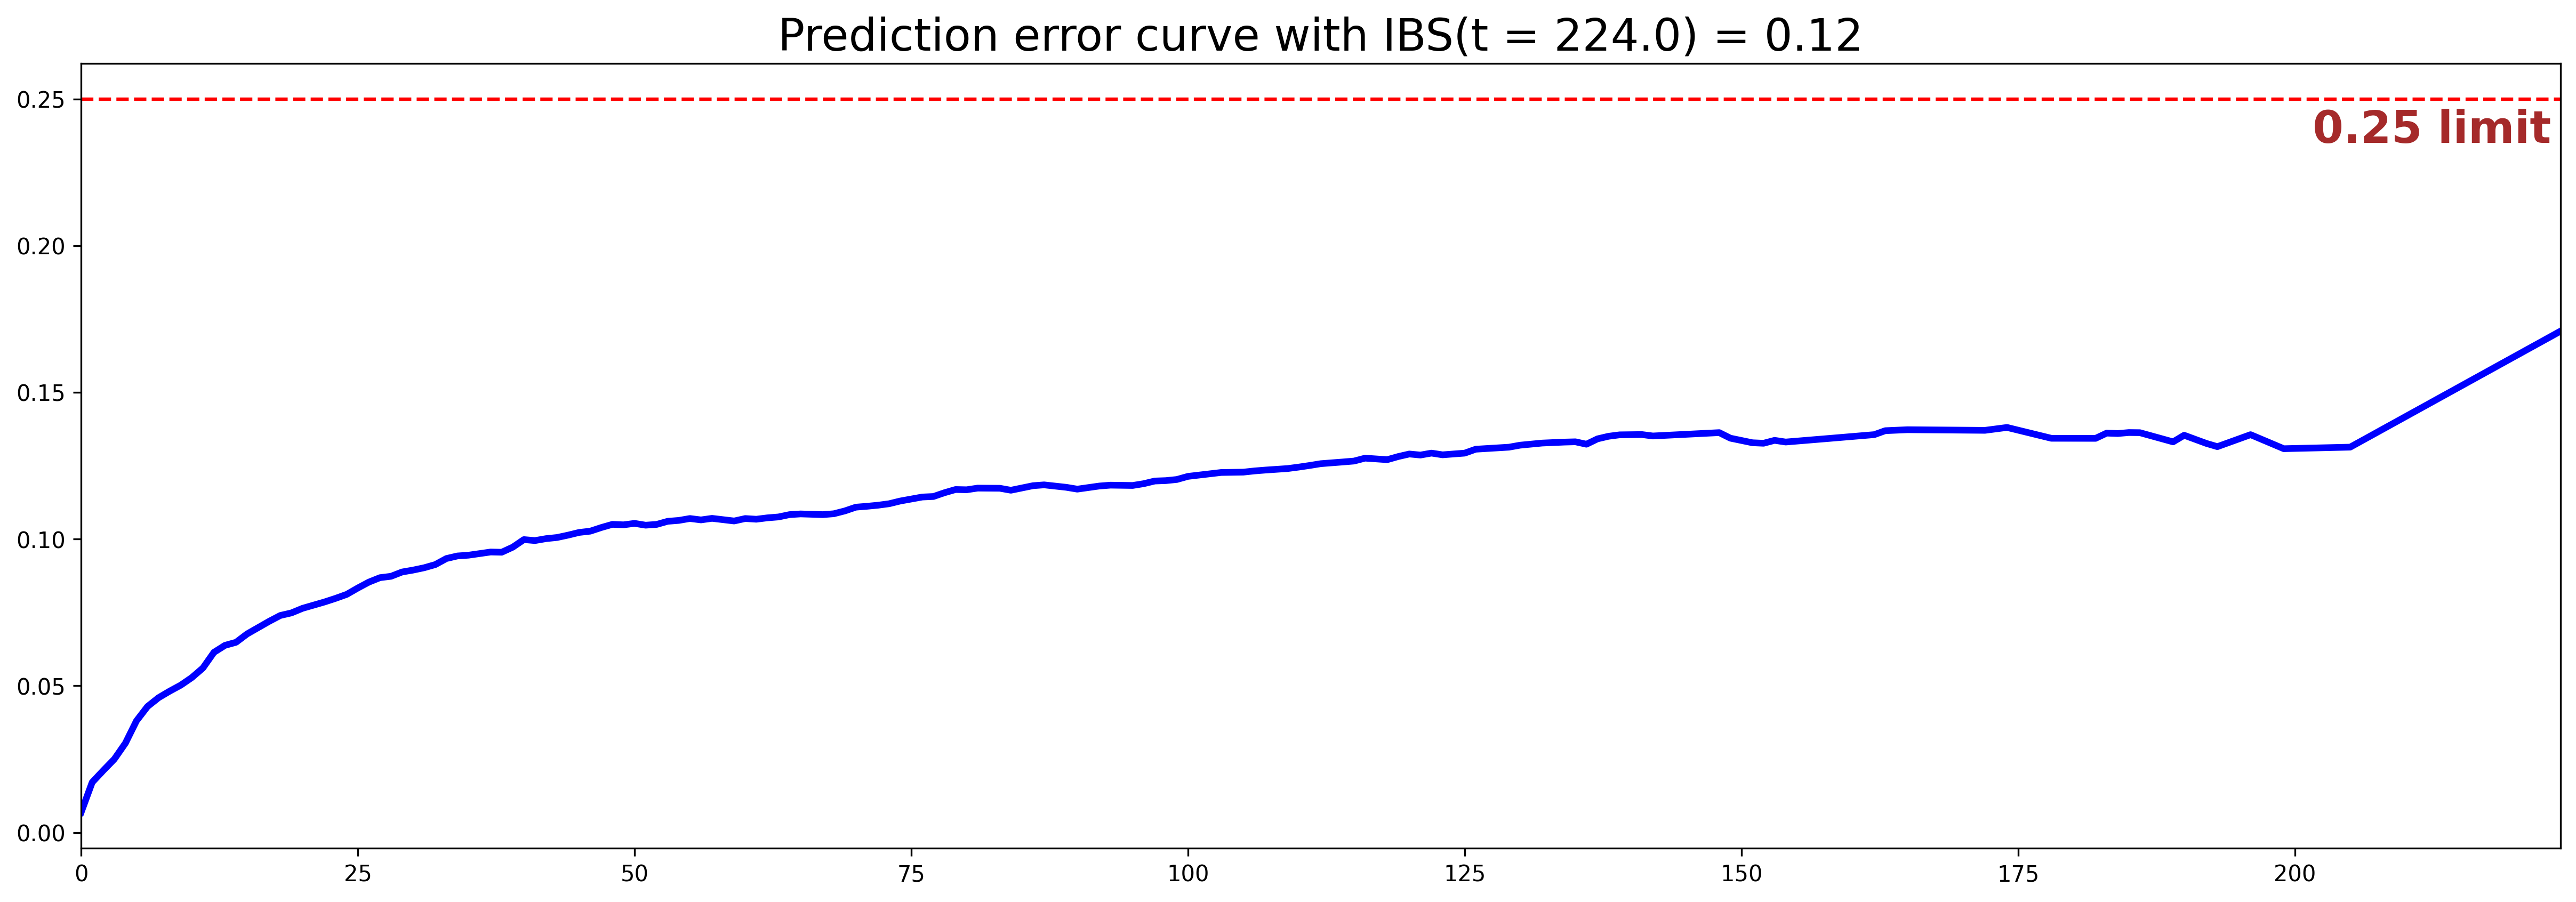

IBS: 0.12


In [260]:
from pysurvival.utils.display import integrated_brier_score
ibs = integrated_brier_score(cph_model, X_train, T_train, E_train,t_max=None, figure_size=(20, 6.5) )
print('IBS: {:.2f}'.format(ibs))

### Hyperparameters tuning

In [261]:
max_iter = 1000

#### Tuning NMTLR

In [266]:
nmtlr = NMTLR()
nmtlr.tuning_and_construct(X_train, T_train, E_train,max_iter=max_iter)
nmtlr_model = nmtlr.model

Number 1 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3095.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3719.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3444.70
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3048.91
% Completion: 100%|*************************************************

mean_c_index:  0.6208497810714011 is the best so far
Number 2 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2827.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2828.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2970.78
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2559.01
% Completion: 100%|*************************************************

mean_c_index:  0.6526879056260917 is the best so far
Number 3 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.6093669279739562 
Number 4 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2052.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2134.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2146.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2168.56
% Completion: 100%|*************************************************

mean_c_index:  0.811033212480635 is the best so far
Number 5 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.6237781992294572 
Number 6 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1975.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2177.60
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2066.85
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.8112742837557658 is the best so far
Number 7 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2327.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2450.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2481.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2449.31
% Completion: 100%|*************************************************

mean_c_index:  0.6100178191644442 
Number 8 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 865.00
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 945.68
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 824.88
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 857.69
% Completion: 100%|*************************************************

mean_c_index:  0.5985016529704619 
Number 9 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1525.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1500.07
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1535.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1513.57
% Completion: 100%|*************************************************

mean_c_index:  0.6101234302492132 
Number 10 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4502.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3166.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 6064.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 5630.58
% Completion: 100%|*************************************************

mean_c_index:  0.560095525475642 
Number 11 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3253.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4472.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4135.24
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3953.70
% Completion: 100%|*************************************************

mean_c_index:  0.5839873847492362 
Number 12 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2743.78
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2796.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2685.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2385.26
% Completion: 100%|*************************************************

mean_c_index:  0.5995559187059099 
Number 13 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1953.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2032.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1942.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1992.63
% Completion: 100%|*************************************************

mean_c_index:  0.798003104044588 
Number 14 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 559.93
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 525.18
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 584.07
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 594.64
% Completion: 100%|*************************************************

mean_c_index:  0.6422041452583823 
Number 15 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2008.35
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2013.98
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2035.28
% Completion: 100%|*************************************************

mean_c_index:  0.7653464674638267 
Number 16 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1582.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1560.23
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1589.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1571.04
% Completion: 100%|*************************************************

mean_c_index:  0.8025076068745804 
Number 17 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1780.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1855.94
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1784.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1823.53
% Completion: 100%|*************************************************

mean_c_index:  0.6113801521067057 
Number 18 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2237.78
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2197.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2142.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2187.42
% Completion: 100%|*************************************************

mean_c_index:  0.8137554346234358 is the best so far
Number 19 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.6360815919975611 
Number 20 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2531.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2649.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2575.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2535.77
% Completion: 100%|*************************************************

mean_c_index:  0.8030855795307543 
Number 21 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2181.36
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2366.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2268.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2286.69
% Completion: 100%|*************************************************

mean_c_index:  0.7948864085751458 
Number 22 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.6620110481232994 
Number 23 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1966.23
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1850.07
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2021.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1926.15
% Completion: 100%|*************************************************

mean_c_index:  0.597476924717347 
Number 24 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2345.91
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2442.60
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2341.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2416.75
% Completion: 100%|*************************************************

mean_c_index:  0.5939857405177519 
Number 25 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.6225186669892342 
Number 26 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2783.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2467.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2193.59
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2003.60
% Completion: 100%|*************************************************

mean_c_index:  0.5831181953190621 
Number 27 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.7626242376375867 
Number 28 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.6403154658531726 
Number 29 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 9274.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 5720.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4082.40
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4348.01
% Completion: 100%|*************************************************

mean_c_index:  0.6529463763911749 
Number 30 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1969.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2029.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1900.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1989.05
% Completion: 100%|*************************************************

mean_c_index:  0.8100832862220664 
Number 31 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2558.07
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2592.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2626.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2556.38
% Completion: 100%|*************************************************

mean_c_index:  0.8131896512477607 
Number 32 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.5766577073217414 
Number 33 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4576.13
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 5518.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4706.45
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3816.44
% Completion: 100%|*************************************************

mean_c_index:  0.6232618157748503 
Number 34 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1256.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1192.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1220.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1179.91
% Completion: 100%|*************************************************

mean_c_index:  0.5855579398206261 
Number 35 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2020.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2016.91
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2243.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1984.85
% Completion: 100%|*************************************************

mean_c_index:  0.7848206027885244 
Number 36 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3429.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3287.13
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3485.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3449.40
% Completion: 100%|*************************************************

mean_c_index:  0.5775958645210244 
Number 37 iteration ... The gradient exploded... You should reduce the learningrate (lr) of your optimizer
mean_c_index:  nan 
Number 38 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 427.45
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 566.09
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 494.72
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 528.81
% Completion: 100%|*************************************************

mean_c_index:  0.5960830890023762 
Number 39 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2206.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2122.49
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2207.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2195.36
% Completion: 100%|*************************************************

mean_c_index:  0.7904899726308501 
Number 40 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2624.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2643.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2612.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2572.06
% Completion: 100%|*************************************************

mean_c_index:  0.7874258943279463 
Number 41 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2598.48
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2648.98
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3435.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3113.77
% Completion: 100%|*************************************************

mean_c_index:  0.7017462232367221 
Number 42 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2222.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2238.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2199.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2196.40
% Completion: 100%|*************************************************

mean_c_index:  0.6410720971731759 
Number 43 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.6026094797357009 
Number 44 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1571.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1637.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1601.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1656.15
% Completion: 100%|*************************************************

mean_c_index:  0.6045070197557475 
Number 45 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1655.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1595.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1681.13
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1631.30
% Completion: 100%|*************************************************

mean_c_index:  0.6060608183870804 
Number 46 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2218.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1928.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2424.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2348.00
% Completion: 100%|*************************************************

mean_c_index:  0.7943430699137519 
Number 47 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2454.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2479.82
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2280.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2474.72
% Completion: 100%|*************************************************

mean_c_index:  0.8258017727414462 is the best so far
Number 48 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1622.54
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1723.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1629.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1684.32
% Completion: 100%|*************************************************

mean_c_index:  0.8175888813559423 
Number 49 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2195.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2111.70
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2086.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2194.67
% Completion: 100%|*************************************************

mean_c_index:  0.8194024458042056 
Number 50 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.6872159375831288 
Number 51 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1746.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1560.75
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1768.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1662.97
% Completion: 100%|*************************************************

mean_c_index:  0.6088987804886103 
Number 52 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1895.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1942.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1827.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1803.41
% Completion: 100%|*************************************************

mean_c_index:  0.6529871836351633 
Number 53 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.6318619428028521 
Number 54 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 560.60
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 585.87
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 522.95
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.6041806810911785 
Number 55 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4716.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4021.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4160.23
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4551.06
% Completion: 100%|*************************************************

mean_c_index:  0.5773944759990839 
Number 56 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3388.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3273.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2634.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3715.35
% Completion: 100%|*************************************************

mean_c_index:  0.7635919436918078 
Number 57 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.5239753634147487 
Number 58 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2257.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2257.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2271.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2253.26
% Completion: 100%|*************************************************

mean_c_index:  0.8205982035181792 
Number 59 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2028.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2074.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2008.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2121.37
% Completion: 100%|*************************************************

mean_c_index:  0.8238379918558735 
Number 60 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1912.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1818.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1901.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1886.03
% Completion: 100%|*************************************************

mean_c_index:  0.7529292745060511 
Number 61 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2697.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2965.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2814.74
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2921.15
% Completion: 100%|*************************************************

mean_c_index:  0.8148507356915335 
Number 62 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2265.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2101.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2204.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2300.75
% Completion: 100%|*************************************************

mean_c_index:  0.7991289299280526 
Number 63 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3394.36
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3086.24
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3412.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3300.38
% Completion: 100%|*************************************************

mean_c_index:  0.6432888373123777 
Number 64 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1772.75
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1867.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1863.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1838.43
% Completion: 100%|*************************************************

mean_c_index:  0.8267738743064268 is the best so far
Number 65 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.6012621039884637 
Number 66 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2118.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1721.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2014.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2164.82
% Completion: 100%|*************************************************

mean_c_index:  0.6737596860347118 
Number 67 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1993.24
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1969.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1996.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2007.80
% Completion: 100%|*************************************************

mean_c_index:  0.8194671547317419 
Number 68 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.6328014426416522 
Number 69 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1601.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1570.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1575.91
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1588.29
% Completion: 100%|*************************************************

mean_c_index:  0.8312645201431627 is the best so far
Number 70 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3011.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3219.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2699.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 5575.37
% Completion: 100%|*************************************************

mean_c_index:  0.5388875341272495 
Number 71 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1212.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1186.60
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1301.70
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1156.36
% Completion: 100%|*************************************************

mean_c_index:  0.681919898292245 
Number 72 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1827.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1785.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1668.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1835.56
% Completion: 100%|*************************************************

mean_c_index:  0.6998421137190529 
Number 73 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3180.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4271.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3721.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3688.98
% Completion: 100%|*************************************************

mean_c_index:  0.5726923411996611 
Number 74 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3133.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3320.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3597.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3205.28
% Completion: 100%|*************************************************

mean_c_index:  0.6880408890547568 
Number 75 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2130.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2209.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2056.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2217.44
% Completion: 100%|*************************************************

mean_c_index:  0.8029238982479303 
Number 76 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2496.24
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2554.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2619.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2603.74
% Completion: 100%|*************************************************

mean_c_index:  0.6747833334566522 
Number 77 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1343.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1318.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1424.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1389.18
% Completion: 100%|*************************************************

mean_c_index:  0.802115845181401 
Number 78 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2446.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2283.91
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2383.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2374.56
% Completion: 100%|*************************************************

mean_c_index:  0.7124217378764813 
Number 79 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3976.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3687.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3305.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3564.03
% Completion: 100%|*************************************************

mean_c_index:  0.7376874683372459 
Number 80 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1563.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1535.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1434.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1555.71
% Completion: 100%|*************************************************

mean_c_index:  0.5949544987833217 
Number 81 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2112.71
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2009.60
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2076.09
% Completion: 100%|*************************************************

mean_c_index:  0.7852041232697848 
Number 82 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3462.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2967.13
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2727.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2799.90
% Completion: 100%|*************************************************

mean_c_index:  0.5915694074807956 
Number 83 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.6089062939911754 
Number 84 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2225.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2318.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2595.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2283.71
% Completion: 100%|*************************************************

mean_c_index:  0.7998565740158081 
Number 85 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2364.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2506.75
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2615.54
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2411.22
% Completion: 100%|*************************************************

mean_c_index:  0.7164183270114572 
Number 86 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.5951000687678962 
Number 87 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2062.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2057.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2042.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2090.36
% Completion: 100%|*************************************************

mean_c_index:  0.8196036493977605 
Number 88 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1635.60
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1699.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1658.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1708.98
% Completion: 100%|*************************************************

mean_c_index:  0.7965689776422573 
Number 89 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 960.37
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 810.27
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 887.61
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 806.35
% Completion: 100%|*************************************************

mean_c_index:  0.6139919935934357 
Number 90 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2761.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1719.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3481.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1855.77
% Completion: 100%|*************************************************

mean_c_index:  0.6535900425417518 
Number 91 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 5056.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 5128.95
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.5397736958119592 
Number 92 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2146.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2059.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2074.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2245.19
% Completion: 100%|*************************************************

mean_c_index:  0.8234501493476591 
Number 93 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1684.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1761.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1741.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1597.50
% Completion: 100%|*************************************************

mean_c_index:  0.5904916746968352 
Number 94 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2746.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2728.07
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2695.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2804.92
% Completion: 100%|*************************************************

mean_c_index:  0.7890214429406893 
Number 95 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2599.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3153.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2988.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3106.52
% Completion: 100%|*************************************************

mean_c_index:  0.6232557012707154 
Number 96 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3147.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3330.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2947.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3253.27
% Completion: 100%|*************************************************

mean_c_index:  0.6302821354676276 
Number 97 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3777.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2721.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2819.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3649.22
% Completion: 100%|*************************************************

mean_c_index:  0.6069442703822585 
Number 98 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1087.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1252.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1211.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1160.99
% Completion: 100%|*************************************************

mean_c_index:  0.6178660829247313 
Number 99 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1736.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1759.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1809.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1802.57
% Completion: 100%|*************************************************

mean_c_index:  0.6267056411483523 
Number 100 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1396.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1423.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1423.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1370.67
% Completion: 100%|*************************************************

mean_c_index:  0.8077562642500832 
Number 101 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.5847646363950342 
Number 102 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3927.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3292.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3297.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3107.28
% Completion: 100%|*************************************************

mean_c_index:  0.5506798545335653 
Number 103 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3366.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 8185.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 8060.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3807.53
% Completion: 100%|*************************************************

mean_c_index:  0.6012438962361747 
Number 104 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2528.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2674.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2750.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2661.19
% Completion: 100%|*************************************************

mean_c_index:  0.7325610614747715 
Number 105 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2667.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2682.75
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2554.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2488.74
% Completion: 100%|*************************************************

mean_c_index:  0.7784694230608906 
Number 106 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3550.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3131.74
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3419.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3482.36
% Completion: 100%|*************************************************

mean_c_index:  0.5536639650553358 
Number 107 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2623.98
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2709.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2625.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2571.63
% Completion: 100%|*************************************************

mean_c_index:  0.7665539421115973 
Number 108 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3143.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2862.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3510.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3122.42
% Completion: 100%|*************************************************

mean_c_index:  0.8089650758585092 
Number 109 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1686.48
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1805.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1791.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1694.73
% Completion: 100%|*************************************************

mean_c_index:  0.8012716286920668 
Number 110 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 875.54
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 915.64
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 859.82
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 871.84
% Completion: 100%|*************************************************

mean_c_index:  0.5396941704563293 
Number 111 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1180.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1138.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1328.54
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1225.05
% Completion: 100%|*************************************************

mean_c_index:  0.6092521246545886 
Number 112 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.6037616190283871 
Number 113 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2084.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2226.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2396.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2132.32
% Completion: 100%|*************************************************

mean_c_index:  0.6346049163142099 
Number 114 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2966.40
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3563.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3368.70
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3494.21
% Completion: 100%|*************************************************

mean_c_index:  0.5860784222849882 
Number 115 iteration ... The gradient exploded... You should reduce the learningrate (lr) of your optimizer
mean_c_index:  nan 
Number 116 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3996.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4699.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4454.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4708.03
% Completion: 100%|*************************************************

mean_c_index:  0.5776013850276254 
Number 117 iteration ... The gradient exploded... You should reduce the learningrate (lr) of your optimizer
mean_c_index:  nan 
Number 118 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3193.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3090.60
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2814.78
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2780.28
% Completion: 100%|*************************************************

mean_c_index:  0.5504199582606164 
Number 119 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2854.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3325.59
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2894.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3448.35
% Completion: 100%|*************************************************

mean_c_index:  0.6197888828506736 
Number 120 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2416.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2424.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2351.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2400.86
% Completion: 100%|*************************************************

mean_c_index:  0.82869479144432 
Number 121 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.626024573660117 
Number 122 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 300.80
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 324.59
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 209.70
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 253.07
% Completion: 100%|*************************************************

mean_c_index:  0.6233347081093477 
Number 123 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4393.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3634.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2851.13
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3771.13
% Completion: 100%|*************************************************

mean_c_index:  0.5666941424398291 
Number 124 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1412.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1362.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1372.07
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1357.20
% Completion: 100%|*************************************************

mean_c_index:  0.7059815476206004 
Number 125 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2499.78
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2459.40
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2382.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2306.22
% Completion: 100%|*************************************************

mean_c_index:  0.8125347923058411 
Number 126 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1479.94
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1394.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1475.63
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.6081095549165767 
Number 127 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1659.54
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1683.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1619.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1639.17
% Completion: 100%|*************************************************

mean_c_index:  0.7749277048972502 
Number 128 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 816.41
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 766.13
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 704.77
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 889.39
% Completion: 100%|*************************************************

mean_c_index:  0.5719694185635785 
Number 129 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 951.06
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 944.01
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 889.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1301.61
% Completion: 100%|*************************************************

mean_c_index:  0.6491591763043766 
Number 130 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3299.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3294.91
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3230.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3679.79
% Completion: 100%|*************************************************

mean_c_index:  0.5527645272095523 
Number 131 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1548.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1586.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1608.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1562.91
% Completion: 100%|*************************************************

mean_c_index:  0.8235978548643992 
Number 132 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1984.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2133.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2075.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1974.89
% Completion: 100%|*************************************************

mean_c_index:  0.8199408629594211 
Number 133 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1866.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1992.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2044.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1965.96
% Completion: 100%|*************************************************

mean_c_index:  0.8089764337674097 
Number 134 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1453.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1531.22
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1548.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1594.95
% Completion: 100%|*************************************************

mean_c_index:  0.5872306406280453 
Number 135 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 720.75
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 771.90
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 740.65
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 688.43
% Completion: 100%|*************************************************

mean_c_index:  0.6283737839857556 
Number 136 iteration ... The gradient exploded... You should reduce the learningrate (lr) of your optimizer
mean_c_index:  nan 
Number 137 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.6063549105986731 
Number 138 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1512.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1563.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1472.59
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1342.73
% Completion: 100%|*************************************************

mean_c_index:  0.6130951291486342 
Number 139 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1559.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1600.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1522.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1529.59
% Completion: 100%|*************************************************

mean_c_index:  0.6973286451643091 
Number 140 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1767.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1679.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1675.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1674.72
% Completion: 100%|*************************************************

mean_c_index:  0.6566425972201453 
Number 141 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1304.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1269.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1295.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1327.42
% Completion: 100%|*************************************************

mean_c_index:  0.7965585518199443 
Number 142 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2153.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2021.32
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2120.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2068.97
% Completion: 100%|*************************************************

mean_c_index:  0.8290723509170557 
Number 143 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 916.25
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 855.57
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 929.85
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 862.36
% Completion: 100%|*************************************************

mean_c_index:  0.576146899675788 
Number 144 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4419.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3898.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4582.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3821.01
% Completion: 100%|*************************************************

mean_c_index:  0.6048867837204298 
Number 145 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2435.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2285.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2289.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2311.25
% Completion: 100%|*************************************************

mean_c_index:  0.6629042360315758 
Number 146 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1811.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1854.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1819.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1902.21
% Completion: 100%|*************************************************

mean_c_index:  0.8161512057976275 
Number 147 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1378.75
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.6154628285598303 
Number 148 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2319.82
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2252.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2302.12


mean_c_index:  0.7210965656965982 
Number 149 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2357.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2243.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2335.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2172.27
% Completion: 100%|*************************************************

mean_c_index:  0.621954025504479 
Number 150 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 6777.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 5135.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 5516.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 5628.08
% Completion: 100%|*************************************************

mean_c_index:  0.6433376634533806 
Number 151 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3666.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2941.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2593.30
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.6354912735146957 
Number 152 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1394.12
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1769.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1365.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1612.05
% Completion: 100%|*************************************************

mean_c_index:  0.6266367795594073 
Number 153 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2931.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2468.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2548.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2386.16
% Completion: 100%|*************************************************

mean_c_index:  0.5835541135180633 
Number 154 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1805.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1816.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1836.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1761.08
% Completion: 100%|*************************************************

mean_c_index:  0.8017265906086761 
Number 155 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2660.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2405.98
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2262.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2340.16
% Completion: 100%|*************************************************

mean_c_index:  0.5810899290583458 
Number 156 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3448.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3710.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3199.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3688.60
% Completion: 100%|*************************************************

mean_c_index:  0.6049636790893921 
Number 157 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.5899564836467365 
Number 158 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2356.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2279.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2267.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2245.37
% Completion: 100%|*************************************************

mean_c_index:  0.8233110089827154 
Number 159 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.6524991386486955 
Number 160 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2970.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3199.32
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2799.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3333.09
% Completion: 100%|*************************************************

mean_c_index:  0.5632286429712476 
Number 161 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2479.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2892.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3117.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2966.32
% Completion: 100%|*************************************************

mean_c_index:  0.6306560709668324 
Number 162 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1879.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1822.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1874.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1854.37
% Completion: 100%|*************************************************

mean_c_index:  0.8280334218293464 
Number 163 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2328.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2355.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2268.98
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2334.23
% Completion: 100%|*************************************************

mean_c_index:  0.7927270438396666 
Number 164 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2441.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2907.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2733.49
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2909.16
% Completion: 100%|*************************************************

mean_c_index:  0.6301601320449094 
Number 165 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2750.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2587.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2442.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2489.89
% Completion: 100%|*************************************************

mean_c_index:  0.798654992365134 
Number 166 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2159.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2196.98
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2164.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2201.95
% Completion: 100%|*************************************************

mean_c_index:  0.8117875414050504 
Number 167 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2649.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2850.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3022.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2759.89
% Completion: 100%|*************************************************

mean_c_index:  0.7033196340987848 
Number 168 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2664.82
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2620.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2561.78
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3062.08
% Completion: 100%|*************************************************

mean_c_index:  0.7394272926062873 
Number 169 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1646.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1672.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1628.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1688.81
% Completion: 100%|*************************************************

mean_c_index:  0.825480795634936 
Number 170 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 293.58
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.6342028925183338 
Number 171 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1562.36
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1616.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1649.40
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1613.02
% Completion: 100%|*************************************************

mean_c_index:  0.7989950063674931 
Number 172 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2556.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2577.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2631.60
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2586.65
% Completion: 100%|*************************************************

mean_c_index:  0.7788876795915256 
Number 173 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1768.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1750.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1791.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1752.82
% Completion: 100%|*************************************************

mean_c_index:  0.8052264991551283 
Number 174 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.6476726227054634 
Number 175 iteration ... The gradient exploded... You should reduce the learningrate (lr) of your optimizer
mean_c_index:  nan 
Number 176 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4249.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4603.23
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4058.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3982.02
% Completion: 100%|*************************************************

mean_c_index:  0.5501333211603967 
Number 177 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1969.94
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2127.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2413.92
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.6722328125235137 
Number 178 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2755.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2716.48
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2814.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2644.31
% Completion: 100%|*************************************************

mean_c_index:  0.8165004444776957 
Number 179 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2214.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2203.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2240.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2191.12
% Completion: 100%|*************************************************

mean_c_index:  0.827668491141384 
Number 180 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3361.61
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3009.40
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3185.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3012.46
% Completion: 100%|*************************************************

mean_c_index:  0.5971192481098853 
Number 181 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2813.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2793.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2884.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2679.68
% Completion: 100%|*************************************************

mean_c_index:  0.5562800497686785 
Number 182 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2715.74
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2809.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2560.23
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2722.88
% Completion: 100%|*************************************************

mean_c_index:  0.6078279502092588 
Number 183 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3423.54
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3583.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3392.32
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4467.97
% Completion: 100%|*************************************************

mean_c_index:  0.6073466630963031 
Number 184 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.6073396498339934 
Number 185 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 740.16
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 839.34
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 870.17
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 794.66
% Completion: 100%|*************************************************

mean_c_index:  0.5925951762422494 
Number 186 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4339.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3893.78
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4176.24
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3838.39
% Completion: 100%|*************************************************

mean_c_index:  0.5767157357771939 
Number 187 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1419.23
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1437.32
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1357.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1418.41
% Completion: 100%|*************************************************

mean_c_index:  0.702485676265695 
Number 188 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2809.48
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2889.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2730.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2925.00
% Completion: 100%|*************************************************

mean_c_index:  0.6231285388842648 
Number 189 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3090.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3374.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2545.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2928.30
% Completion: 100%|*************************************************

mean_c_index:  0.5525044241562572 
Number 190 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1718.74
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1678.75
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1599.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1700.50
% Completion: 100%|*************************************************

mean_c_index:  0.6639071506042556 
Number 191 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1710.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1645.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1977.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1857.77
% Completion: 100%|*************************************************

mean_c_index:  0.5826421126050987 
Number 192 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 5373.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4627.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4583.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 5575.58
% Completion: 100%|*************************************************

mean_c_index:  0.5565997336946895 
Number 193 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2159.94
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2177.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2178.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2307.89
% Completion: 100%|*************************************************

mean_c_index:  0.8255870465258542 
Number 194 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2838.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2799.82
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3345.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2987.27
% Completion: 100%|*************************************************

mean_c_index:  0.548692382103091 
Number 195 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3019.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4655.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3960.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3358.09
% Completion: 100%|*************************************************

mean_c_index:  0.5922412695693456 
Number 196 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4508.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4210.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3817.48
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4536.38
% Completion: 100%|*************************************************

mean_c_index:  0.5658657392311194 
Number 197 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 227.71
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 256.90
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 232.06
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 254.73
% Completion: 100%|*************************************************

mean_c_index:  0.5727389589019286 
Number 198 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1335.88
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1284.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1403.50
% Completion: 100%|*************************************************

mean_c_index:  0.6066016033772582 
Number 199 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.7202842926848168 
Number 200 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3608.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3685.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3162.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4005.37
% Completion: 100%|*************************************************

mean_c_index:  0.5698000248371782 
Number 201 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3988.22
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3266.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3734.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3502.20
% Completion: 100%|*************************************************

mean_c_index:  0.5757553077198764 
Number 202 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1895.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2110.27
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1963.99
% Completion: 100%|*************************************************

mean_c_index:  0.6518297612370483 
Number 203 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3265.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2858.75
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2755.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2775.82
% Completion: 100%|*************************************************

mean_c_index:  0.7033717087088763 
Number 204 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2893.36
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2853.82
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2676.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2847.14
% Completion: 100%|*************************************************

mean_c_index:  0.58648956559355 
Number 205 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3273.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3437.94
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3259.74
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4768.73
% Completion: 100%|*************************************************

mean_c_index:  0.6224901353551158 
Number 206 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1437.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1527.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1539.61
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1394.82
% Completion: 100%|*************************************************

mean_c_index:  0.6262226098042278 
Number 207 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1391.12
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1506.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1471.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1374.42
% Completion: 100%|*************************************************

mean_c_index:  0.8178307223251011 
Number 208 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2281.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2279.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2310.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2231.71
% Completion: 100%|*************************************************

mean_c_index:  0.5990726221916396 
Number 209 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2257.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2286.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2214.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2296.01
% Completion: 100%|*************************************************

mean_c_index:  0.82347532140145 
Number 210 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3046.13
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1934.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1843.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2898.32
% Completion: 100%|*************************************************

mean_c_index:  0.5445327007529015 
Number 211 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2592.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2181.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2553.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2501.36
% Completion: 100%|*************************************************

mean_c_index:  0.6135382605286682 
Number 212 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2209.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2246.49
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2197.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2150.86
% Completion: 100%|*************************************************

mean_c_index:  0.8171463064594399 
Number 213 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.5647605564873792 
Number 214 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2673.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2803.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2558.22
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3116.38
% Completion: 100%|*************************************************

mean_c_index:  0.5962753829296766 
Number 215 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2270.48
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2237.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2283.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2254.37
% Completion: 100%|*************************************************

mean_c_index:  0.8273473800927844 
Number 216 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1893.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1826.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1868.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1830.03
% Completion: 100%|*************************************************

mean_c_index:  0.7585843434707413 
Number 217 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2382.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2472.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2505.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2410.42
% Completion: 100%|*************************************************

mean_c_index:  0.8147790010794426 
Number 218 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2014.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2057.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2263.23
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1990.94
% Completion: 100%|*************************************************

mean_c_index:  0.6922527384872756 
Number 219 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 886.52
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 785.28
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 956.29
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 910.39
% Completion: 100%|*************************************************

mean_c_index:  0.5907995656684922 
Number 220 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2454.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2130.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2492.12
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2223.83
% Completion: 100%|*************************************************

mean_c_index:  0.7779047480306934 
Number 221 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4743.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 5009.59
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 5619.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3939.02
% Completion: 100%|*************************************************

mean_c_index:  0.547417835683438 
Number 222 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.7127055864918808 
Number 223 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1898.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1892.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1930.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1920.63
% Completion: 100%|*************************************************

mean_c_index:  0.7972904668234706 
Number 224 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2537.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2775.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2494.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2533.11
% Completion: 100%|*************************************************

mean_c_index:  0.6004662190384041 
Number 225 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2142.54
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2115.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2120.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2135.98
% Completion: 100%|*************************************************

mean_c_index:  0.6756940239836586 
Number 226 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1214.40
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.60339902551357 
Number 227 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2004.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2073.23
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1988.75
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2014.79
% Completion: 100%|*************************************************

mean_c_index:  0.8284352229706456 
Number 228 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3758.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4594.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4856.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4105.30
% Completion: 100%|*************************************************

mean_c_index:  0.6132757830421426 
Number 229 iteration ... The gradient exploded... You should reduce the learningrate (lr) of your optimizer
mean_c_index:  nan 
Number 230 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2576.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2725.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2796.75
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2627.89
% Completion: 100%|*************************************************

mean_c_index:  0.8108403223124023 
Number 231 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1813.70
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1832.70
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1835.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1808.28
% Completion: 100%|*************************************************

mean_c_index:  0.8265496730084099 
Number 232 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1089.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1031.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1268.67


The #1 argument contains null values
mean_c_index:  0.6513261680013147 
Number 233 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2184.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2175.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2216.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2175.90
% Completion: 100%|*************************************************

mean_c_index:  0.8252346663797983 
Number 234 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1959.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2085.60
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2148.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2177.31
% Completion: 100%|*************************************************

mean_c_index:  0.8206119012900995 
Number 235 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1977.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2066.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1975.23
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2115.03
% Completion: 100%|*************************************************

mean_c_index:  0.824823479441565 
Number 236 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2094.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2194.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2157.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2141.62
% Completion: 100%|*************************************************

mean_c_index:  0.8285816704195396 
Number 237 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2252.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2214.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2245.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2131.85
% Completion: 100%|*************************************************

mean_c_index:  0.7749139371104665 
Number 238 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2087.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2125.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2218.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2244.05
% Completion: 100%|*************************************************

mean_c_index:  0.8228164288587863 
Number 239 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.6528999344640021 
Number 240 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2655.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2710.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2554.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2921.26
% Completion: 100%|*************************************************

mean_c_index:  0.5813337919694443 
Number 241 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3258.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4747.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4344.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4591.97
% Completion: 100%|*************************************************

mean_c_index:  0.5842323184322571 
Number 242 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2133.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2166.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2167.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2146.77
% Completion: 100%|*************************************************

mean_c_index:  0.8161316548907991 
Number 243 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1972.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1814.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1951.98
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2064.06
% Completion: 100%|*************************************************

mean_c_index:  0.7061181436853182 
Number 244 iteration ... 


% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1638.65
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1671.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1694.32


mean_c_index:  0.5603114250481254 
Number 245 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1466.91
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1498.40
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1473.70
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1506.52
% Completion: 100%|*************************************************

mean_c_index:  0.6177224752678595 
Number 246 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.6588142510196126 
Number 247 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3961.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4120.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4182.60
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4187.73
% Completion: 100%|*************************************************

mean_c_index:  0.6388550813701747 
Number 248 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 895.99
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 881.00
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 985.51
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 831.41
% Completion: 100%|*************************************************

mean_c_index:  0.5566929832276245 
Number 249 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1419.94
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1409.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1515.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1447.14
% Completion: 100%|*************************************************

mean_c_index:  0.636142372061719 
Number 250 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1415.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1404.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1388.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1428.36
% Completion: 100%|*************************************************

mean_c_index:  0.8044884385866645 
Number 251 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2872.91
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2915.32
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2977.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2761.48
% Completion: 100%|*************************************************

mean_c_index:  0.816955503709354 
Number 252 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2068.72
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


The #1 argument contains null values
mean_c_index:  nan 
Number 253 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.5642626313491929 
Number 254 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3745.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3265.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3124.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3569.92
% Completion: 100%|*************************************************

mean_c_index:  0.6079770984799937 
Number 255 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3031.45
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3246.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2886.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2900.14
% Completion: 100%|*************************************************

mean_c_index:  0.6513643197208803 
Number 256 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1598.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1527.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1421.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1232.49
% Completion: 100%|*************************************************

mean_c_index:  0.6141308654126933 
Number 257 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2197.45
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2263.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2324.59
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2242.90
% Completion: 100%|*************************************************

mean_c_index:  0.8121609559789198 
Number 258 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2173.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2227.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2293.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2177.97
% Completion: 100%|*************************************************

mean_c_index:  0.8298240677547769 
Number 259 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.5980348412530534 
Number 260 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.7132222364794198 
Number 261 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1516.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1281.22
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1278.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1303.03
% Completion: 100%|*************************************************

mean_c_index:  0.5671953058313104 
Number 262 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3111.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3041.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3217.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3161.27
% Completion: 100%|*************************************************

mean_c_index:  0.6990892358818573 
Number 263 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 358.93
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 318.11
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 501.02
% Completion: 100%|*************************************************

mean_c_index:  0.5963617322604906 
Number 264 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1720.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1708.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1681.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1751.07
% Completion: 100%|*************************************************

mean_c_index:  0.78648299235861 
Number 265 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 222.04
% Completion: 100%|*************************************************

mean_c_index:  0.625223768237009 
Number 266 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 205.92
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 188.17
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 207.60
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 185.54
% Completion: 100%|*************************************************

mean_c_index:  0.5615160978586653 
Number 267 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2428.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2529.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2490.82
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2483.14
% Completion: 100%|*************************************************

mean_c_index:  0.6661437211806501 
Number 268 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2446.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2561.94
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2598.23
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2773.17
% Completion: 100%|*************************************************

mean_c_index:  0.7904776573484187 
Number 269 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 132.43
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 829.34
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 120.37
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 152.77


mean_c_index:  0.6157252099787842 
Number 270 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2765.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3818.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2854.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2989.35
% Completion: 100%|*************************************************

mean_c_index:  0.7230182499440371 
Number 271 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3178.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4226.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3315.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2866.67
% Completion: 100%|*************************************************

mean_c_index:  0.6043560037041636 
Number 272 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4748.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 5183.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4591.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 5019.17
% Completion: 100%|*************************************************

mean_c_index:  0.5644416891752824 
Number 273 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2976.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3216.54
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3119.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3244.53
% Completion: 100%|*************************************************

mean_c_index:  0.6166959752382825 
Number 274 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2485.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2412.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2389.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2229.66
% Completion: 100%|*************************************************

mean_c_index:  0.5780161298105242 
Number 275 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3384.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3619.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4487.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3862.00
% Completion: 100%|*************************************************

mean_c_index:  0.5784605953508541 
Number 276 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2247.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2297.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2170.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2437.24
% Completion: 100%|*************************************************

mean_c_index:  0.7868402327866945 
Number 277 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1563.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1587.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1598.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1606.24
% Completion: 100%|*************************************************

mean_c_index:  0.8257117218412932 
Number 278 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1578.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1637.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1440.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1544.82
% Completion: 100%|*************************************************

mean_c_index:  0.6254317583434639 
Number 279 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2544.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2756.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2606.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2675.03
% Completion: 100%|*************************************************

mean_c_index:  0.6651363811026894 
Number 280 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.6815184803778767 
Number 281 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 963.69
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 942.81
% Completion: 100%|*************************************************

mean_c_index:  0.6834563521948492 
Number 282 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2283.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2382.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2280.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2271.45
% Completion: 100%|*************************************************

mean_c_index:  0.7082811077967583 
Number 283 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2199.12
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2083.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2098.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2028.63
% Completion: 100%|*************************************************

mean_c_index:  0.6435246816175253 
Number 284 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1718.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1493.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1618.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1598.81
% Completion: 100%|*************************************************

mean_c_index:  0.5335438729398823 
Number 285 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1240.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1232.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1205.91
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1174.48
% Completion: 100%|*************************************************

mean_c_index:  0.8034488589741322 
Number 286 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2191.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2096.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2084.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2166.18
% Completion: 100%|*************************************************

mean_c_index:  0.8140166976634002 
Number 287 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3326.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3275.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3282.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3223.07
% Completion: 100%|*************************************************

mean_c_index:  0.7180833611301142 
Number 288 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1849.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1937.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1918.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1869.41
% Completion: 100%|*************************************************

mean_c_index:  0.8180458187699117 
Number 289 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2547.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4328.48
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2408.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2631.42
% Completion: 100%|*************************************************

mean_c_index:  0.5904754919247325 
Number 290 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.5755642543678159 
Number 291 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1748.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1850.70
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1856.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1808.50
% Completion: 100%|*************************************************

mean_c_index:  0.8352780200160735 is the best so far
Number 292 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2349.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2092.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1943.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2087.26
% Completion: 100%|*************************************************

mean_c_index:  0.5925080835717937 
Number 293 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1495.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1546.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1663.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1589.12
% Completion: 100%|*************************************************

mean_c_index:  0.6426780810358448 
Number 294 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.6545264872715715 
Number 295 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.6157521399628315 
Number 296 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2763.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2581.40
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2797.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2644.01
% Completion: 100%|*************************************************

mean_c_index:  0.7683399610089061 
Number 297 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1628.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1525.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1587.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1574.09
% Completion: 100%|*************************************************

mean_c_index:  0.8112878490414761 
Number 298 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1575.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1667.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1693.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1694.53
% Completion: 100%|*************************************************

mean_c_index:  0.8312304912016731 
Number 299 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2423.23
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2235.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2343.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2160.36
% Completion: 100%|*************************************************

mean_c_index:  0.6334049472591241 
Number 300 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1448.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1440.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1418.23
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1367.49
% Completion: 100%|*************************************************

mean_c_index:  0.6902122977564227 
Number 301 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1421.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1627.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1444.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1526.06
% Completion: 100%|*************************************************

mean_c_index:  0.5929680890594351 
Number 302 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2785.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2642.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2573.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2521.80
% Completion: 100%|*************************************************

mean_c_index:  0.6395610111983822 
Number 303 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2554.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2567.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2414.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2539.70
% Completion: 100%|*************************************************

mean_c_index:  0.6481662362050788 
Number 304 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2177.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2156.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2124.32
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2132.48
% Completion: 100%|*************************************************

mean_c_index:  0.8267274351935615 
Number 305 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2591.98
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2731.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2527.32
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2535.18
% Completion: 100%|*************************************************

mean_c_index:  0.6125513769400345 
Number 306 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.5650493051452837 
Number 307 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1602.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1615.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1546.48
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1497.92
% Completion: 100%|*************************************************

mean_c_index:  0.8214252015580605 
Number 308 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2185.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2206.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2172.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2184.17
% Completion: 100%|*************************************************

mean_c_index:  0.8148920215818674 
Number 309 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2435.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2524.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2463.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2394.11
% Completion: 100%|*************************************************

mean_c_index:  0.7609668704939203 
Number 310 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.5757843127422343 
Number 311 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1275.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1476.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1162.07
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1144.12
% Completion: 100%|*************************************************

mean_c_index:  0.6502183459887703 
Number 312 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1299.07
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1238.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1387.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1243.53
% Completion: 100%|*************************************************

mean_c_index:  0.6606284278625514 
Number 313 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2446.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2339.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2306.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2412.75
% Completion: 100%|*************************************************

mean_c_index:  0.7927403251956724 
Number 314 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2042.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2043.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1928.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1960.97
% Completion: 100%|*************************************************

mean_c_index:  0.5992889726188918 
Number 315 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1477.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1344.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1287.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1386.51
% Completion: 100%|*************************************************

mean_c_index:  0.6578359591300644 
Number 316 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2858.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2832.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2820.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2621.44
% Completion: 100%|*************************************************

mean_c_index:  0.5533417412768376 
Number 317 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2503.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2505.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2517.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2510.58
% Completion: 100%|*************************************************

mean_c_index:  0.6589110337427446 
Number 318 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 176.53
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 151.00
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 174.33
% Completion: 100%|*************************************************

mean_c_index:  0.6333540729360658 
Number 319 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 982.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1006.39
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 909.88
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 925.86
% Completion: 100%|*************************************************

mean_c_index:  0.641320965143316 
Number 320 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2324.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2428.40
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2313.98
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2463.95
% Completion: 100%|*************************************************

mean_c_index:  0.8035609026569077 
Number 321 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.5852994711872521 
Number 322 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2921.40
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2745.94
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3352.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2833.43
% Completion: 100%|*************************************************

mean_c_index:  0.5828173134849108 
Number 323 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2784.32
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3086.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3035.82
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3091.24
% Completion: 100%|*************************************************

mean_c_index:  0.6468194802479343 
Number 324 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2356.32
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2450.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2151.48
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2416.75
% Completion: 100%|*************************************************

mean_c_index:  0.6183569789973222 
Number 325 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1655.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1588.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1509.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1497.95
% Completion: 100%|*************************************************

mean_c_index:  0.6729027434192901 
Number 326 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3063.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2532.74
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2795.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2822.08
% Completion: 100%|*************************************************

mean_c_index:  0.7184994464923604 
Number 327 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2126.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2093.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2104.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2266.92
% Completion: 100%|*************************************************

mean_c_index:  0.8105489429731241 
Number 328 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2998.48
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3355.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3435.13
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3437.89
% Completion: 100%|*************************************************

mean_c_index:  0.6122768042508835 
Number 329 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1074.22
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1077.54
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1064.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1238.04
% Completion: 100%|*************************************************

mean_c_index:  0.5981072934808063 
Number 330 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1063.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1089.35
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 994.22
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1026.37
% Completion: 100%|*************************************************

mean_c_index:  0.6212479760441801 
Number 331 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2168.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2175.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2133.12
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2092.80
% Completion: 100%|*************************************************

mean_c_index:  0.8059491089720785 
Number 332 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1292.78
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1329.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1255.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1218.37
% Completion: 100%|*************************************************

mean_c_index:  0.6688316573201807 
Number 333 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1174.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1134.45
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1124.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1183.54
% Completion: 100%|*************************************************

mean_c_index:  0.6250931996466214 
Number 334 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2585.78
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2567.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2409.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2750.25
% Completion: 100%|*************************************************

mean_c_index:  0.591064361208906 
Number 335 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


The gradient exploded... You should reduce the learningrate (lr) of your optimizer
mean_c_index:  0.5561004320581572 
Number 336 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1968.59
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1930.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1756.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1961.50
% Completion: 100%|*************************************************

mean_c_index:  0.8226680686493673 
Number 337 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1018.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1021.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1067.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1004.91
% Completion: 100%|*************************************************

mean_c_index:  0.5649369316034922 
Number 338 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1741.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1739.75
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1799.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1864.99
% Completion: 100%|*************************************************

mean_c_index:  0.8198457075742297 
Number 339 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1999.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1995.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2016.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2107.31
% Completion: 100%|*************************************************

mean_c_index:  0.8276371183527056 
Number 340 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2590.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2511.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2566.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2569.22
% Completion: 100%|*************************************************

mean_c_index:  0.7934215407002206 
Number 341 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3117.24
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3112.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3124.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3143.90
% Completion: 100%|*************************************************

mean_c_index:  0.6048054600087591 
Number 342 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.6118487363015699 
Number 343 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 675.36
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 616.19
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 662.43
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 552.34
% Completion: 100%|*************************************************

mean_c_index:  0.5644010717594607 
Number 344 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2443.40
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2575.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2457.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2580.17
% Completion: 100%|*************************************************

mean_c_index:  0.8060181837482835 
Number 345 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1391.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1381.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1398.75
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1376.08
% Completion: 100%|*************************************************

mean_c_index:  0.8379725937927838 is the best so far
Number 346 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1694.70
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1789.85
% Completion: 100%|*************************************************

mean_c_index:  0.779521961249044 
Number 347 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1253.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1279.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1287.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1252.17
% Completion: 100%|*************************************************

mean_c_index:  0.7353033855546784 
Number 348 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2430.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2465.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2410.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2460.10
% Completion: 100%|*************************************************

mean_c_index:  0.5862475383930813 
Number 349 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2853.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2798.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2809.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2739.91
% Completion: 100%|*************************************************

mean_c_index:  0.7029536435705376 
Number 350 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2270.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2265.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2331.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2332.00
% Completion: 100%|*************************************************

mean_c_index:  0.8180346806558303 
Number 351 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2385.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2377.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2366.41
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2334.14
% Completion: 100%|*************************************************

mean_c_index:  0.8029835795321594 
Number 352 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 617.25
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 167.06
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 207.27
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 135.01
% Completion: 100%|*************************************************

mean_c_index:  0.5965948214373429 
Number 353 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.5357545649619148 
Number 354 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.7060887968938612 
Number 355 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1267.06
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.7446133891607208 
Number 356 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2658.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2489.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2247.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2258.00
% Completion: 100%|*************************************************

mean_c_index:  0.5946505799654829 
Number 357 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2177.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2128.24
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2032.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2323.37
% Completion: 100%|*************************************************

mean_c_index:  0.6702799807041033 
Number 358 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.5522974303013323 
Number 359 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1845.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1801.32
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1865.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1805.97
% Completion: 100%|*************************************************

mean_c_index:  0.8218689281284496 
Number 360 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3067.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2994.54
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3907.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3455.47
% Completion: 100%|*************************************************

mean_c_index:  0.6178197650788495 
Number 361 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2242.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2071.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1985.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2236.68
% Completion: 100%|*************************************************

mean_c_index:  0.8147168782062033 
Number 362 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1627.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1595.45
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1671.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1652.62
% Completion: 100%|*************************************************

mean_c_index:  0.803875846262477 
Number 363 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2508.32
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2440.07
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2629.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2492.51
% Completion: 100%|*************************************************

mean_c_index:  0.794137633771723 
Number 364 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1486.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1506.36
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1616.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1576.36
% Completion: 100%|*************************************************

mean_c_index:  0.8264416655628972 
Number 365 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2670.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2775.82
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2715.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2741.71
% Completion: 100%|*************************************************

mean_c_index:  0.7659448370953307 
Number 366 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1921.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1954.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1958.60
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2014.49
% Completion: 100%|*************************************************

mean_c_index:  0.8248781486048224 
Number 367 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2472.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2497.48
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3136.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2486.04
% Completion: 100%|*************************************************

mean_c_index:  0.575619302196206 
Number 368 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.6091286898379605 
Number 369 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.6481177738821463 
Number 370 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 898.83
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 792.54
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 841.71
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 787.61
% Completion: 100%|*************************************************

mean_c_index:  0.5916406759847972 
Number 371 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3456.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3646.41
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3625.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3196.55
% Completion: 100%|*************************************************

mean_c_index:  0.6439936260032056 
Number 372 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4783.12
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4946.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4163.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4676.29
% Completion: 100%|*************************************************

mean_c_index:  0.5743283204180948 
Number 373 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 960.87
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 906.44
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 899.22
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 986.43
% Completion: 100%|*************************************************

mean_c_index:  0.542595918682045 
Number 374 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 856.77
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.6081937981523027 
Number 375 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2460.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2875.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2397.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2822.14
% Completion: 100%|*************************************************

mean_c_index:  0.6546968678503207 
Number 376 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2779.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2651.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2546.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2339.82
% Completion: 100%|*************************************************

mean_c_index:  0.8139732442820705 
Number 377 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.609417671769586 
Number 378 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2996.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2904.32
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2705.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2904.30
% Completion: 100%|*************************************************

mean_c_index:  0.6381852304334248 
Number 379 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1935.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1941.32
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1931.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2010.37
% Completion: 100%|*************************************************

mean_c_index:  0.768008856045221 
Number 380 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.6459366360249708 
Number 381 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1809.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1823.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1760.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1845.19
% Completion: 100%|*************************************************

mean_c_index:  0.805829253266458 
Number 382 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2487.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2415.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2741.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2313.87
% Completion: 100%|*************************************************

mean_c_index:  0.5976081384378322 
Number 383 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1973.82
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2047.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1956.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1972.75
% Completion: 100%|*************************************************

mean_c_index:  0.6323324716248341 
Number 384 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2232.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2234.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2238.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2387.81
% Completion: 100%|*************************************************

mean_c_index:  0.8255539364142888 
Number 385 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1618.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1534.49
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1589.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1603.64
% Completion: 100%|*************************************************

mean_c_index:  0.8238253166518298 
Number 386 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1544.54
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1504.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1614.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1514.55
% Completion: 100%|*************************************************

mean_c_index:  0.6368065880862741 
Number 387 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2986.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3158.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2689.91
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2865.88
% Completion: 100%|*************************************************

mean_c_index:  0.643593422684746 
Number 388 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1136.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1015.49
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1039.37
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.7076766973859966 
Number 389 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1912.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1932.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2033.54
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2055.53
% Completion: 100%|*************************************************

mean_c_index:  0.6415574399060915 
Number 390 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1061.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1075.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1134.06
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 983.45
% Completion: 100%|*************************************************

mean_c_index:  0.7292449399276784 
Number 391 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 797.30
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 644.97
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 867.32
% Completion: 100%|*************************************************

mean_c_index:  0.5825231115140501 
Number 392 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2080.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2231.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2200.98
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2125.71
% Completion: 100%|*************************************************

mean_c_index:  0.8273248819133542 
Number 393 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2307.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2304.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2256.32
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2279.33
% Completion: 100%|*************************************************

mean_c_index:  0.8289270072814061 
Number 394 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 238.74
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 280.27
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 215.66
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 378.64
% Completion: 100%|*************************************************

mean_c_index:  0.5856410883069545 
Number 395 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2445.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2597.40
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2440.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2385.43
% Completion: 100%|*************************************************

mean_c_index:  0.6788980366441942 
Number 396 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2955.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2942.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3482.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3016.56
% Completion: 100%|*************************************************

mean_c_index:  0.7428959396277861 
Number 397 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1303.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1214.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1306.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1287.51
% Completion: 100%|*************************************************

mean_c_index:  0.8240184794645211 
Number 398 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3008.59
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3001.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2347.40
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2552.43
% Completion: 100%|*************************************************

mean_c_index:  0.5557368020233423 
Number 399 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3013.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2479.36
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2672.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2850.28
% Completion: 100%|*************************************************

mean_c_index:  0.6010368318277294 
Number 400 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.55986127631251 
Number 401 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2293.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2307.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2262.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2266.19
% Completion: 100%|*************************************************

mean_c_index:  0.824583017047488 
Number 402 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2469.40
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2333.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2824.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2775.22
% Completion: 100%|*************************************************

mean_c_index:  0.7519194637844258 
Number 403 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2531.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2474.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2436.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2407.72
% Completion: 100%|*************************************************

mean_c_index:  0.6722711807464105 
Number 404 iteration ... The gradient exploded... You should reduce the learningrate (lr) of your optimizer
mean_c_index:  nan 
Number 405 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1858.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1829.70
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1931.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1879.11
% Completion: 100%|*************************************************

mean_c_index:  0.8070810638862614 
Number 406 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3669.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3862.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3818.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4689.19
% Completion: 100%|*************************************************

mean_c_index:  0.5945809125013934 
Number 407 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2511.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2568.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2609.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2503.68
% Completion: 100%|*************************************************

mean_c_index:  0.7491215470484303 
Number 408 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2057.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2131.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2070.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2106.72
% Completion: 100%|*************************************************

mean_c_index:  0.8190362315948766 
Number 409 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1611.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1604.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1534.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1589.31
% Completion: 100%|*************************************************

mean_c_index:  0.7958993527017217 
Number 410 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1479.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1419.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1451.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1570.31
% Completion: 100%|*************************************************

mean_c_index:  0.6118934357030937 
Number 411 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1427.13
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1475.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1564.59
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1509.21
% Completion: 100%|*************************************************

mean_c_index:  0.7079220545224466 
Number 412 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 5126.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3788.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3376.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4211.13
% Completion: 100%|*************************************************

mean_c_index:  0.6032160188713866 
Number 413 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.5842739474438897 
Number 414 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss:  62.47
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss:  61.02
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss:  74.95
% Completion: 100%|*************************************************

mean_c_index:  0.617678414278821 
Number 415 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2619.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2655.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2694.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2512.31
% Completion: 100%|*************************************************

mean_c_index:  0.6410782776486409 
Number 416 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2997.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3024.59
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3160.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3137.47
% Completion: 100%|*************************************************

mean_c_index:  0.7450520806416366 
Number 417 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.6070177854162336 
Number 418 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2220.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2038.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1908.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2091.93
% Completion: 100%|*************************************************

mean_c_index:  0.6262431970326752 
Number 419 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2141.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2228.23
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2278.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2280.29
% Completion: 100%|*************************************************

mean_c_index:  0.8057575174048338 
Number 420 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1751.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1888.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1736.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1715.58
% Completion: 100%|*************************************************

mean_c_index:  0.8197760058936213 
Number 421 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1766.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1910.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1837.94
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1697.47
% Completion: 100%|*************************************************

mean_c_index:  0.6645723891134785 
Number 422 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1486.54
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1506.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1509.98
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1521.96
% Completion: 100%|*************************************************

mean_c_index:  0.7852464491503491 
Number 423 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1863.07
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1961.59
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1800.75
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1796.52
% Completion: 100%|*************************************************

mean_c_index:  0.7935409518416165 
Number 424 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2016.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1897.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1922.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1946.87
% Completion: 100%|*************************************************

mean_c_index:  0.7469517422854365 
Number 425 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1311.74
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1140.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1319.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1102.53
% Completion: 100%|*************************************************

mean_c_index:  0.6676766508055877 
Number 426 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.6772478405388712 
Number 427 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3377.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2805.48
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2887.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2833.85
% Completion: 100%|*************************************************

mean_c_index:  0.8053103926602395 
Number 428 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1195.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1298.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1286.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1182.24
% Completion: 100%|*************************************************

mean_c_index:  0.5318704484802962 
Number 429 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.6099895779573371 
Number 430 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1579.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1646.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1648.74
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1682.26
% Completion: 100%|*************************************************

mean_c_index:  0.8091042963619856 
Number 431 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1914.73


mean_c_index:  0.6168346186561816 
Number 432 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3216.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2940.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2778.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3024.09
% Completion: 100%|*************************************************

mean_c_index:  0.7650477478092965 
Number 433 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2513.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2390.70
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2303.13
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2347.09
% Completion: 100%|*************************************************

mean_c_index:  0.8024112411515262 
Number 434 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3327.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3382.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3093.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3044.55
% Completion: 100%|*************************************************

mean_c_index:  0.7548944611045479 
Number 435 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2233.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2196.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2107.36
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2192.38
% Completion: 100%|*************************************************

mean_c_index:  0.7942429415941838 
Number 436 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3039.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2565.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3219.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2624.47
% Completion: 100%|*************************************************

mean_c_index:  0.5807029748185447 
Number 437 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.5756528593848824 
Number 438 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3153.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3145.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2794.94
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2956.48
% Completion: 100%|*************************************************

mean_c_index:  0.588976846324367 
Number 439 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2249.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2240.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2207.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2360.44
% Completion: 100%|*************************************************

mean_c_index:  0.7822865360606386 
Number 440 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3112.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3271.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3839.61
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3871.23
% Completion: 100%|*************************************************

mean_c_index:  0.6154590990115727 
Number 441 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2189.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3195.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2468.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1944.23
% Completion: 100%|*************************************************

mean_c_index:  0.572743476757857 
Number 442 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2642.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2707.61
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2771.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2692.34
% Completion: 100%|*************************************************

mean_c_index:  0.8021313373982342 
Number 443 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1450.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1440.94
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1590.48
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1398.46
% Completion: 100%|*************************************************

mean_c_index:  0.549374444829654 
Number 444 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2463.91
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2533.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2523.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2548.63
% Completion: 100%|*************************************************

mean_c_index:  0.8098705831682615 
Number 445 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2562.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2541.78
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2628.36
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2601.52
% Completion: 100%|*************************************************

mean_c_index:  0.7842594113087475 
Number 446 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.6320814888102592 
Number 447 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2566.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2436.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2447.74
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2417.97
% Completion: 100%|*************************************************

mean_c_index:  0.7687879120579968 
Number 448 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2597.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2564.24
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2682.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2620.58
% Completion: 100%|*************************************************

mean_c_index:  0.740349977167639 
Number 449 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1009.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1066.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1021.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1031.70
% Completion: 100%|*************************************************

mean_c_index:  0.6348567608337762 
Number 450 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.5439986794375877 
Number 451 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1337.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1381.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1486.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1396.30
% Completion: 100%|*************************************************

mean_c_index:  0.6633167216031044 
Number 452 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1759.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1726.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1736.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1758.66
% Completion: 100%|*************************************************

mean_c_index:  0.8143054913644958 
Number 453 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1586.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1591.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1535.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1561.57
% Completion: 100%|*************************************************

mean_c_index:  0.6859578554175394 
Number 454 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1909.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1866.59
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1970.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1914.95
% Completion: 100%|*************************************************

mean_c_index:  0.6875754358969337 
Number 455 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2075.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1962.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1949.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2169.37
% Completion: 100%|*************************************************

mean_c_index:  0.6469860699044231 
Number 456 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2728.91
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2729.36
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2618.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2696.81
% Completion: 100%|*************************************************

mean_c_index:  0.6907592406400924 
Number 457 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1327.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1286.78
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1284.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1324.47
% Completion: 100%|*************************************************

mean_c_index:  0.6538707500096002 
Number 458 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1979.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1959.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1928.82
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2075.15
% Completion: 100%|*************************************************

mean_c_index:  0.8245237461411155 
Number 459 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3489.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3191.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4020.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3330.18
% Completion: 100%|*************************************************

mean_c_index:  0.642164127257151 
Number 460 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2302.22
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2310.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2282.82
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2283.51
% Completion: 100%|*************************************************

mean_c_index:  0.8260926243818695 
Number 461 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.6334990631834597 
Number 462 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2403.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2281.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2446.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2236.12
% Completion: 100%|*************************************************

mean_c_index:  0.5591459820304224 
Number 463 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.6994763281717491 
Number 464 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1055.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1086.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1157.84
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 984.65
% Completion: 100%|*************************************************

mean_c_index:  0.5505499073713243 
Number 465 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1802.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1765.41
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1693.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1747.73
% Completion: 100%|*************************************************

mean_c_index:  0.6991326318900919 
Number 466 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3760.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4233.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4346.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3908.22
% Completion: 100%|*************************************************

mean_c_index:  0.5899987473644682 
Number 467 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3445.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3053.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3159.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3042.21
% Completion: 100%|*************************************************

mean_c_index:  0.6185003578732171 
Number 468 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1852.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2039.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1899.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1945.24
% Completion: 100%|*************************************************

mean_c_index:  0.6709659443531762 
Number 469 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2521.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2513.07
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2461.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2461.14
% Completion: 100%|*************************************************

mean_c_index:  0.705819882298188 
Number 470 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1574.22
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1631.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1468.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1483.81
% Completion: 100%|*************************************************

mean_c_index:  0.6258286219793782 
Number 471 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1561.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1500.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1419.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1433.35
% Completion: 100%|*************************************************

mean_c_index:  0.7198201426364206 
Number 472 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2042.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2032.61
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2109.41
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1973.95
% Completion: 100%|*************************************************

mean_c_index:  0.8112178653303751 
Number 473 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2424.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2827.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3032.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2304.95
% Completion: 100%|*************************************************

mean_c_index:  0.5505879099675555 
Number 474 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2417.45
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2349.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2332.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2481.78
% Completion: 100%|*************************************************

mean_c_index:  0.7898269143335668 
Number 475 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2601.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2489.48
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2474.59
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2465.87
% Completion: 100%|*************************************************

mean_c_index:  0.6433787197531501 
Number 476 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2213.60
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2119.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2209.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2142.10
% Completion: 100%|*************************************************

mean_c_index:  0.8167187125319565 
Number 477 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2134.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2059.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2123.49
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2190.99
% Completion: 100%|*************************************************

mean_c_index:  0.8003499769015452 
Number 478 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2232.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2295.41
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2314.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2266.68
% Completion: 100%|*************************************************

mean_c_index:  0.8196026121682282 
Number 479 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2343.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2444.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2255.45
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2510.00
% Completion: 100%|*************************************************

mean_c_index:  0.7070049430936854 
Number 480 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2038.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1964.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1956.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2014.46
% Completion: 100%|*************************************************

mean_c_index:  0.8100567390032569 
Number 481 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1723.82
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1733.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1733.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1779.39
% Completion: 100%|*************************************************

mean_c_index:  0.6255205416449249 
Number 482 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1764.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2023.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1894.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2018.34
% Completion: 100%|*************************************************

mean_c_index:  0.6106076697846026 
Number 483 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2084.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2103.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2110.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2087.24
% Completion: 100%|*************************************************

mean_c_index:  0.8158900402837451 
Number 484 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.5762981639548024 
Number 485 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 352.20
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 388.45
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 371.24
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 440.06
% Completion: 100%|*************************************************

mean_c_index:  0.5880238420320051 
Number 486 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2350.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2471.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2986.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2776.79
% Completion: 100%|*************************************************

mean_c_index:  0.6416653484788176 
Number 487 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2272.91
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2261.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2219.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2156.41
% Completion: 100%|*************************************************

mean_c_index:  0.8139432327793547 
Number 488 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2176.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3643.74
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3153.07
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1964.38
% Completion: 100%|*************************************************

mean_c_index:  0.5738911993874115 
Number 489 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1267.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1207.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1204.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1209.69
% Completion: 100%|*************************************************

mean_c_index:  0.7545545882679539 
Number 490 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2451.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2414.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2411.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2431.35
% Completion: 100%|*************************************************

mean_c_index:  0.8069862980596592 
Number 491 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 594.77
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 552.06
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 594.64
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 577.85
% Completion: 100%|*************************************************

mean_c_index:  0.5515634786777082 
Number 492 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3272.70
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3431.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3216.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3607.15
% Completion: 100%|*************************************************

mean_c_index:  0.5915109084734496 
Number 493 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2246.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2416.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2275.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2171.53
% Completion: 100%|*************************************************

mean_c_index:  0.5974171904167609 
Number 494 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2371.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2415.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2307.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2435.03
% Completion: 100%|*************************************************

mean_c_index:  0.5510132655993167 
Number 495 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2437.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2132.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2284.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2322.21
% Completion: 100%|*************************************************

mean_c_index:  0.7700807295340159 
Number 496 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4911.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4378.91
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 5070.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4904.41
% Completion: 100%|*************************************************

mean_c_index:  0.6532638016919993 
Number 497 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 6302.61
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 5940.74
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 7442.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 5660.73
% Completion: 100%|*************************************************

mean_c_index:  0.6310251810867494 
Number 498 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2672.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2810.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2656.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3048.04
% Completion: 100%|*************************************************

mean_c_index:  0.6187249302222072 
Number 499 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1698.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1522.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1802.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1572.04
% Completion: 100%|*************************************************

mean_c_index:  0.663849876597174 
Number 500 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1924.32
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1989.23
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1966.59
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1941.50
% Completion: 100%|*************************************************

mean_c_index:  0.8197720461561098 
Number 501 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2235.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2279.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2211.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2345.28
% Completion: 100%|*************************************************

mean_c_index:  0.6773371479104286 
Number 502 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.5935824506564795 
Number 503 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2077.36
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2141.13
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2224.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2173.13
% Completion: 100%|*************************************************

mean_c_index:  0.6705991449038471 
Number 504 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 818.97
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 867.87
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 844.24
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 958.01
% Completion: 100%|*************************************************

mean_c_index:  0.5910817920186751 
Number 505 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2396.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2290.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2480.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2310.36
% Completion: 100%|*************************************************

mean_c_index:  0.7386347102209377 
Number 506 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2791.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2790.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2649.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2609.83
% Completion: 100%|*************************************************

mean_c_index:  0.6192166888752665 
Number 507 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3430.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3566.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3682.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3949.07
% Completion: 100%|*************************************************

mean_c_index:  0.6105678203832741 
Number 508 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2005.41
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2000.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1969.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2075.65
% Completion: 100%|*************************************************

mean_c_index:  0.5981937485564797 
Number 509 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4966.24
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4997.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4242.48
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 5926.05
% Completion: 100%|*************************************************

mean_c_index:  0.5881923742608376 
Number 510 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.5739314240372945 
Number 511 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3554.82
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4818.77
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


The gradient exploded... You should reduce the learningrate (lr) of your optimizer
mean_c_index:  0.59312529638442 
Number 512 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2305.41
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2082.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2135.78
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2173.83
% Completion: 100%|*************************************************

mean_c_index:  0.7730097300720647 
Number 513 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1939.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2050.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2019.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1888.98
% Completion: 100%|*************************************************

mean_c_index:  0.8058870325030594 
Number 514 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1204.13
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1261.24
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1275.40
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1253.51
% Completion: 100%|*************************************************

mean_c_index:  0.8358819619579044 
Number 515 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3756.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4756.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4164.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3504.35
% Completion: 100%|*************************************************

mean_c_index:  0.5920940668909573 
Number 516 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2935.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3000.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3181.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3235.19
% Completion: 100%|*************************************************

mean_c_index:  0.5821495921166421 
Number 517 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1926.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1936.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2004.91
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1967.00
% Completion: 100%|*************************************************

mean_c_index:  0.813369405554105 
Number 518 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2371.59
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2316.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2335.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2690.01
% Completion: 100%|*************************************************

mean_c_index:  0.8098385505387137 
Number 519 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2387.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2409.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2326.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2257.75
% Completion: 100%|*************************************************

mean_c_index:  0.6552654831583313 
Number 520 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1580.59
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1559.48
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1568.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1621.02
% Completion: 100%|*************************************************

mean_c_index:  0.6025103406919159 
Number 521 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1145.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1197.12
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1060.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1084.82
% Completion: 100%|*************************************************

mean_c_index:  0.5604904948215088 
Number 522 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4317.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4239.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4337.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4004.02
% Completion: 100%|*************************************************

mean_c_index:  0.6112100401428368 
Number 523 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4624.39
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.5537654222171164 
Number 524 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2716.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2919.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2892.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2876.60
% Completion: 100%|*************************************************

mean_c_index:  0.6471329082285054 
Number 525 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1211.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1263.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1198.48
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1229.80
% Completion: 100%|*************************************************

mean_c_index:  0.6168201672905279 
Number 526 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|************************************************

mean_c_index:  0.6117386359429589 
Number 527 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.5949330041497788 
Number 528 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1905.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2012.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1987.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1979.88
% Completion: 100%|*************************************************

mean_c_index:  0.8349751456037987 
Number 529 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1474.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1415.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1443.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1375.96
% Completion: 100%|*************************************************

mean_c_index:  0.8060167210716251 
Number 530 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss:  64.79
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss:  51.54
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss:  60.78
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss:  72.56
% Completion: 100%|*************************************************

mean_c_index:  0.6010493147961435 
Number 531 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2077.94
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2065.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2051.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2034.22
% Completion: 100%|*************************************************

mean_c_index:  0.8215430917903275 
Number 532 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1899.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1947.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1848.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1988.57
% Completion: 100%|*************************************************

mean_c_index:  0.8044208806989278 
Number 533 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3536.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3356.82
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3694.98
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3760.20
% Completion: 100%|*************************************************

mean_c_index:  0.6082220575635412 
Number 534 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2691.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2711.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2744.22
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2664.22
% Completion: 100%|*************************************************

mean_c_index:  0.6907637760441492 
Number 535 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2871.60
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4772.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2635.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4070.92
% Completion: 100%|*************************************************

mean_c_index:  0.6115559448566245 
Number 536 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2892.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2679.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2960.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3013.98
% Completion: 100%|*************************************************

mean_c_index:  0.587662356044178 
Number 537 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3730.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4224.78
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3260.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3625.62
% Completion: 100%|*************************************************

mean_c_index:  0.6263699195304346 
Number 538 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1583.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1561.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1531.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1625.81
% Completion: 100%|*************************************************

mean_c_index:  0.8093405864182834 
Number 539 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3044.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3080.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3001.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2830.73
% Completion: 100%|*************************************************

mean_c_index:  0.7414954404069332 
Number 540 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.5828672923107944 
Number 541 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2679.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2716.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2563.75
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2808.37
% Completion: 100%|*************************************************

mean_c_index:  0.7648351178960526 
Number 542 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2611.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2376.36
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2520.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2620.85
% Completion: 100%|*************************************************

mean_c_index:  0.8035955105026421 
Number 543 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2047.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2135.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2149.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2095.43
% Completion: 100%|*************************************************

mean_c_index:  0.7708760670012402 
Number 544 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2291.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2148.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2162.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2249.36
% Completion: 100%|*************************************************

mean_c_index:  0.7226652166207115 
Number 545 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.6189065839759758 
Number 546 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2755.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2590.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2733.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2862.20
% Completion: 100%|*************************************************

mean_c_index:  0.6687449527216504 
Number 547 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3054.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3037.59
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3596.91
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3065.14
% Completion: 100%|*************************************************

mean_c_index:  0.5518668271353546 
Number 548 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 925.35
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 918.71
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 953.44
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 947.20
% Completion: 100%|*************************************************

mean_c_index:  0.5831660134301788 
Number 549 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1432.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1503.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1467.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1332.01
% Completion: 100%|*************************************************

mean_c_index:  0.6225044403462239 
Number 550 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2711.74
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2554.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2865.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2402.70
% Completion: 100%|*************************************************

mean_c_index:  0.5750553087105441 
Number 551 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3140.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3255.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3396.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3549.05
% Completion: 100%|*************************************************

mean_c_index:  0.5972754690640636 
Number 552 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1843.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1946.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1920.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1915.14
% Completion: 100%|*************************************************

mean_c_index:  0.82025339740508 
Number 553 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.7000108906318039 
Number 554 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 146.29
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 160.06
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.5618538404854623 
Number 555 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3285.13
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3692.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2998.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2972.24
% Completion: 100%|*************************************************

mean_c_index:  0.7186320511064281 
Number 556 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1846.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2011.74
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2309.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1974.96
% Completion: 100%|*************************************************

mean_c_index:  0.769766512792473 
Number 557 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1338.82
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1291.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1337.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1325.05
% Completion: 100%|*************************************************

mean_c_index:  0.6205234363360603 
Number 558 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2729.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2846.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2759.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2794.94
% Completion: 100%|*************************************************

mean_c_index:  0.6429778691591976 
Number 559 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1494.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1453.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2103.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1416.56
% Completion: 100%|*************************************************

mean_c_index:  0.6783947639030832 
Number 560 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2485.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2351.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2308.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2327.65
% Completion: 100%|*************************************************

mean_c_index:  0.6132762496221549 
Number 561 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2623.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2406.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2711.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2450.41
% Completion: 100%|*************************************************

mean_c_index:  0.6987708523032363 
Number 562 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2230.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2269.40
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2261.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2193.58
% Completion: 100%|*************************************************

mean_c_index:  0.8221122882417708 
Number 563 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2281.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2380.74
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2297.24
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2366.12
% Completion: 100%|*************************************************

mean_c_index:  0.6075293934666535 
Number 564 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2164.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2312.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2211.40
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2102.63
% Completion: 100%|*************************************************

mean_c_index:  0.8165566872313468 
Number 565 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2128.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2047.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2485.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3359.92
% Completion: 100%|*************************************************

mean_c_index:  0.6643618601714791 
Number 566 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1700.80
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.6483126192017354 
Number 567 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3383.82
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2602.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3319.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3513.25
% Completion: 100%|*************************************************

mean_c_index:  0.5596172483278995 
Number 568 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1751.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1617.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1721.68
% Completion: 100%|*************************************************

mean_c_index:  0.7628399300913924 
Number 569 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2686.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2676.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2804.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2738.38
% Completion: 100%|*************************************************

mean_c_index:  0.5730479331959731 
Number 570 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1409.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1482.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1491.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1439.62
% Completion: 100%|*************************************************

mean_c_index:  0.6027285720635929 
Number 571 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2213.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2258.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2227.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2168.22
% Completion: 100%|*************************************************

mean_c_index:  0.8141849816641045 
Number 572 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3812.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4177.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3213.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3543.67
% Completion: 100%|*************************************************

mean_c_index:  0.6453562947245877 
Number 573 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1401.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1524.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1456.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1394.04
% Completion: 100%|*************************************************

The #1 argument contains null values
mean_c_index:  0.6851046564836384 
Number 574 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3686.70
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3817.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4210.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3946.65
% Completion: 100%|*************************************************

mean_c_index:  0.5568036455511709 
Number 575 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2985.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2952.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3348.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2821.87
% Completion: 100%|*************************************************

mean_c_index:  0.772204717513431 
Number 576 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.5738284601922865 
Number 577 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3549.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3274.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3037.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3213.10
% Completion: 100%|*************************************************

mean_c_index:  0.5489396478233558 
Number 578 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3733.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4099.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3921.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4244.19
% Completion: 100%|*************************************************

mean_c_index:  0.7132105053290456 
Number 579 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss:  24.86
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss:  40.70
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss:  36.46
% Completion: 100%|*************************************************

mean_c_index:  0.6151628069468521 
Number 580 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2190.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2142.74
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2139.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2107.11
% Completion: 100%|*************************************************

mean_c_index:  0.7947934785634221 
Number 581 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1687.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1781.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1694.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1511.75
% Completion: 100%|*************************************************

mean_c_index:  0.6415012955786105 
Number 582 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1443.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1363.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1325.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1364.46
% Completion: 100%|*************************************************

mean_c_index:  0.5828302982372684 
Number 583 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1799.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1726.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1737.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1712.36
% Completion: 100%|*************************************************

mean_c_index:  0.8202216438471555 
Number 584 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4389.70
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4201.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4226.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 5413.13
% Completion: 100%|*************************************************

mean_c_index:  0.6178857118397811 
Number 585 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2942.82
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2570.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2567.23
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2881.90
% Completion: 100%|*************************************************

mean_c_index:  0.6900370319215495 
Number 586 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4702.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4084.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3048.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4148.54
% Completion: 100%|*************************************************

mean_c_index:  0.5714046913583054 
Number 587 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2872.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3246.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3315.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4456.49
% Completion: 100%|*************************************************

mean_c_index:  0.586472021727309 
Number 588 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1309.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1314.59
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1229.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1204.21
% Completion: 100%|*************************************************

mean_c_index:  0.5515434334568146 
Number 589 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1586.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1585.78
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1630.05
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.7824935802410575 
Number 590 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3424.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3221.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3868.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3517.48
% Completion: 100%|*************************************************

mean_c_index:  0.5714489841318235 
Number 591 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3152.61
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3552.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3538.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4457.62
% Completion: 100%|*************************************************

mean_c_index:  0.6144764774407803 
Number 592 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2283.74
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2156.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2215.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2173.22
% Completion: 100%|*************************************************

mean_c_index:  0.7886178380250958 
Number 593 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.6001614517775333 
Number 594 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2648.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2467.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2591.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2587.19
% Completion: 100%|*************************************************

mean_c_index:  0.7906891825360935 
Number 595 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1182.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1249.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1093.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1116.09
% Completion: 100%|*************************************************

mean_c_index:  0.6627556322993191 
Number 596 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 921.78
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1006.78
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 931.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1044.51
% Completion: 100%|*************************************************

mean_c_index:  0.5942411194897593 
Number 597 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3040.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2882.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3128.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3482.60
% Completion: 100%|*************************************************

mean_c_index:  0.6065375883878982 
Number 598 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2275.07
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2481.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2404.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2696.23
% Completion: 100%|*************************************************

mean_c_index:  0.708779612794517 
Number 599 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3667.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2577.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3050.12
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2525.17
% Completion: 100%|*************************************************

mean_c_index:  0.5637041478967084 
Number 600 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2120.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2086.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2119.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2049.14
% Completion: 100%|*************************************************

mean_c_index:  0.8310357649368264 
Number 601 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4614.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3891.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4061.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3704.80
% Completion: 100%|*************************************************

mean_c_index:  0.58689676939648 
Number 602 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 702.37
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 842.83
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 771.58
% Completion: 100%|*************************************************

mean_c_index:  0.6061151528662441 
Number 603 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.6477407021690518 
Number 604 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1902.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1820.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1872.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1968.24
% Completion: 100%|*************************************************

mean_c_index:  0.6666055747725054 
Number 605 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2380.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2374.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2429.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2426.15
% Completion: 100%|*************************************************

mean_c_index:  0.8241485905638427 
Number 606 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 810.67
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 748.01
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 779.00
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 794.54
% Completion: 100%|*************************************************

mean_c_index:  0.5814164033728241 
Number 607 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 413.95
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 411.89
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 409.57
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 431.37
% Completion: 100%|*************************************************

mean_c_index:  0.5881620521499317 
Number 608 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2684.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2542.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2432.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2436.58
% Completion: 100%|*************************************************

mean_c_index:  0.628136563247734 
Number 609 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.5749439644756636 
Number 610 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2220.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2362.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2252.98
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2410.92
% Completion: 100%|*************************************************

mean_c_index:  0.6300317590588531 
Number 611 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 439.21
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.6741627778538092 
Number 612 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.6044250745006243 
Number 613 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1064.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1053.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1037.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1115.34
% Completion: 100%|*************************************************

mean_c_index:  0.6200531896528232 
Number 614 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1570.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1371.59
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1539.32
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1477.95
% Completion: 100%|*************************************************

mean_c_index:  0.6173831525115512 
Number 615 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3413.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2986.98
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3084.60
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2965.73
% Completion: 100%|*************************************************

mean_c_index:  0.6334991560975093 
Number 616 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3278.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3449.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3638.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3472.96
% Completion: 100%|*************************************************

mean_c_index:  0.66658751711665 
Number 617 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2857.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3036.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3362.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2978.95
% Completion: 100%|*************************************************

mean_c_index:  0.6040029778745135 
Number 618 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1583.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1496.82
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1573.75
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1546.22
% Completion: 100%|*************************************************

mean_c_index:  0.7963639333187379 
Number 619 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1341.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1361.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1338.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1363.55
% Completion: 100%|*************************************************

mean_c_index:  0.7260191582594822 
Number 620 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2560.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2664.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2962.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2706.52
% Completion: 100%|*************************************************

mean_c_index:  0.7467866355235858 
Number 621 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2150.74
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2208.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2167.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2141.66
% Completion: 100%|*************************************************

mean_c_index:  0.8265529364587376 
Number 622 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1384.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1607.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1519.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1695.52
% Completion: 100%|*************************************************

mean_c_index:  0.696179113898886 
Number 623 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 5076.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3687.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4023.24
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3713.87
% Completion: 100%|*************************************************

mean_c_index:  0.6737610554770155 
Number 624 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3859.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4286.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3858.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3997.18
% Completion: 100%|*************************************************

mean_c_index:  0.6134170759003715 
Number 625 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1549.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1430.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1608.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1479.53
% Completion: 100%|*************************************************

mean_c_index:  0.5663429423870976 
Number 626 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3582.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4281.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 5334.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4215.61
% Completion: 100%|*************************************************

mean_c_index:  0.6560312907125571 
Number 627 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3075.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2548.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2984.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3247.37
% Completion: 100%|*************************************************

mean_c_index:  0.6106152719878367 
Number 628 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1957.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1985.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1919.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1935.46
% Completion: 100%|*************************************************

mean_c_index:  0.7957918697572175 
Number 629 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4256.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 6048.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3692.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4375.21
% Completion: 100%|*************************************************

mean_c_index:  0.6293561232727013 
Number 630 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2950.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2874.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2997.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2998.34
% Completion: 100%|*************************************************

mean_c_index:  0.6280788938389195 
Number 631 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3038.12
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3796.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3236.36
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3451.39
% Completion: 100%|*************************************************

mean_c_index:  0.6284644640487433 
Number 632 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2136.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2163.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2146.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2214.86
% Completion: 100%|*************************************************

mean_c_index:  0.8104448693363789 
Number 633 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4398.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4409.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3529.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3449.89
% Completion: 100%|*************************************************

mean_c_index:  0.6630598802066495 
Number 634 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2977.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3042.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2980.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3131.06
% Completion: 100%|*************************************************

mean_c_index:  0.5530590329543909 
Number 635 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1281.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1405.59
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1349.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1301.39
% Completion: 100%|*************************************************

mean_c_index:  0.5907146030642396 
Number 636 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3261.49
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3200.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3640.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3032.72
% Completion: 100%|*************************************************

mean_c_index:  0.6002165301388136 
Number 637 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.528988273046005 
Number 638 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1692.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1555.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1628.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1734.28
% Completion: 100%|*************************************************

mean_c_index:  0.5935022897122588 
Number 639 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1568.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1514.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1570.60
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1488.58
% Completion: 100%|*************************************************

mean_c_index:  0.6497612241909799 
Number 640 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2001.23
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1962.94
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1978.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2010.02
% Completion: 100%|*************************************************

mean_c_index:  0.8244982682259396 
Number 641 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.6285508750924131 
Number 642 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1935.23
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2205.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2269.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2035.90
% Completion: 100%|*************************************************

mean_c_index:  0.6094912846688254 
Number 643 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.5411544661234771 
Number 644 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2994.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3008.98
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2970.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3511.96
% Completion: 100%|*************************************************

mean_c_index:  0.5940078966809528 
Number 645 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2207.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2312.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2063.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2200.56
% Completion: 100%|*************************************************

mean_c_index:  0.6309285353057599 
Number 646 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2165.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2165.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1952.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2110.55
% Completion: 100%|*************************************************

mean_c_index:  0.6436426676094091 
Number 647 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 5212.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3616.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2790.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3837.46
% Completion: 100%|*************************************************

mean_c_index:  0.6504871848958663 
Number 648 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1907.36
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1841.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1912.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1964.11
% Completion: 100%|*************************************************

mean_c_index:  0.8002880969675118 
Number 649 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4814.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4907.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4304.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 5773.16
% Completion: 100%|*************************************************

mean_c_index:  0.5636531266261413 
Number 650 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2519.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2430.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2514.36
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2420.89
% Completion: 100%|*************************************************

mean_c_index:  0.821136167380752 
Number 651 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1231.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1211.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1193.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1241.01
% Completion: 100%|*************************************************

mean_c_index:  0.836467699700337 
Number 652 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.6249787786439798 
Number 653 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2048.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1981.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1969.88
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.6475617622618228 
Number 654 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.6026166261246144 
Number 655 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1338.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1349.75
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1475.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1449.49
% Completion: 100%|*************************************************

mean_c_index:  0.6252323313847519 
Number 656 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1647.61
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1601.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1587.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1590.30
% Completion: 100%|*************************************************

mean_c_index:  0.8040756612984717 
Number 657 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 517.49
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.6029176401487268 
Number 658 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.5849993555564194 
Number 659 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4186.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3983.94
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3915.12
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4012.84
% Completion: 100%|*************************************************

mean_c_index:  0.6378175879447047 
Number 660 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3620.98
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2743.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2428.41
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2417.38
% Completion: 100%|*************************************************

mean_c_index:  0.6731675397760938 
Number 661 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 749.36
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 772.72
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 815.17
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 874.35
% Completion: 100%|*************************************************

mean_c_index:  0.5996997479554611 
Number 662 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1866.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1838.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1835.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1847.91
% Completion: 100%|*************************************************

mean_c_index:  0.8281858804656697 
Number 663 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2283.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1803.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1844.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2542.10
% Completion: 100%|*************************************************

mean_c_index:  0.5809598801492116 
Number 664 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2720.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2535.74
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2669.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2808.82
% Completion: 100%|*************************************************

mean_c_index:  0.6126083971730487 
Number 665 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3950.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3255.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3474.23
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3295.51
% Completion: 100%|*************************************************

mean_c_index:  0.677266493231558 
Number 666 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1305.75
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1209.60
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1278.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1295.49
% Completion: 100%|*************************************************

mean_c_index:  0.6114081067645228 
Number 667 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2086.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1995.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1989.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1860.62
% Completion: 100%|*************************************************

mean_c_index:  0.7388937964228935 
Number 668 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3699.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2826.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4976.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3336.19
% Completion: 100%|*************************************************

mean_c_index:  0.6328577072055719 
Number 669 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2796.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2729.41
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2751.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2727.26
% Completion: 100%|*************************************************

mean_c_index:  0.7119852326393163 
Number 670 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2630.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2620.40
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2540.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2860.05
% Completion: 100%|*************************************************

mean_c_index:  0.7292230195742733 
Number 671 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 875.24
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 877.79
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.6232518312186948 
Number 672 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3659.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3778.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3730.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4128.31
% Completion: 100%|*************************************************

mean_c_index:  0.5274804882699856 
Number 673 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1653.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1543.94
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1674.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1343.11
% Completion: 100%|*************************************************

mean_c_index:  0.5851459367877544 
Number 674 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2450.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2560.45
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2755.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2629.40
% Completion: 100%|*************************************************

mean_c_index:  0.6056464555052979 
Number 675 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3620.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3548.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2795.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3263.87
% Completion: 100%|*************************************************

mean_c_index:  0.5899318737184541 
Number 676 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 689.27
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 647.99
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 647.43
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 589.18
% Completion: 100%|*************************************************

mean_c_index:  0.6130357500918875 
Number 677 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2311.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2436.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2190.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2127.05
% Completion: 100%|*************************************************

mean_c_index:  0.7815151813316679 
Number 678 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3008.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3268.40
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3098.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3166.58
% Completion: 100%|*************************************************

mean_c_index:  0.5479274221974789 
Number 679 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4198.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3945.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4225.74
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4169.74
% Completion: 100%|*************************************************

mean_c_index:  0.7759140603772121 
Number 680 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.5876169550284003 
Number 681 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1529.32
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1479.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1754.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1548.91
% Completion: 100%|*************************************************

mean_c_index:  0.5776679858853431 
Number 682 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.7015986332003634 
Number 683 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2229.59
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2147.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2320.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2247.26
% Completion: 100%|*************************************************

mean_c_index:  0.8156853449031123 
Number 684 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2073.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2237.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2087.94
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2217.17
% Completion: 100%|*************************************************

mean_c_index:  0.6075717811936262 
Number 685 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 5336.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 5553.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3148.41
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 6112.64
% Completion: 100%|*************************************************

mean_c_index:  0.6616611449779889 
Number 686 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 453.17
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 385.64
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 452.18
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 327.05
% Completion: 100%|*************************************************

mean_c_index:  0.6061187097117032 
Number 687 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1515.40
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1444.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1488.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1536.06
% Completion: 100%|*************************************************

mean_c_index:  0.6181900661752 
Number 688 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 542.35
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 522.65
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 647.68
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 575.17
% Completion: 100%|*************************************************

mean_c_index:  0.6369654399894629 
Number 689 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1868.36
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1894.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1868.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1896.16
% Completion: 100%|*************************************************

mean_c_index:  0.82494056710796 
Number 690 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4213.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4600.91
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4379.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4689.30
% Completion: 100%|*************************************************

mean_c_index:  0.6080416445133326 
Number 691 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2110.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2086.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2108.13
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2085.76
% Completion: 100%|*************************************************

mean_c_index:  0.8260391390098818 
Number 692 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 5753.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 5188.91
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3856.61
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 7899.29
% Completion: 100%|*************************************************

mean_c_index:  0.5508141415345935 
Number 693 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 551.97
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 420.91
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 309.25
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 303.45
% Completion: 100%|*************************************************

mean_c_index:  0.6047252043365041 
Number 694 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3831.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3760.07
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3735.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3186.26
% Completion: 100%|*************************************************

mean_c_index:  0.6215725217204614 
Number 695 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2530.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2514.59
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2447.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2597.30
% Completion: 100%|*************************************************

mean_c_index:  0.8068064229862373 
Number 696 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 832.71
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.5976368884879093 
Number 697 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1618.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1604.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1564.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1690.59
% Completion: 100%|*************************************************

mean_c_index:  0.8193604978588027 
Number 698 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2144.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2105.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2089.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2012.65
% Completion: 100%|*************************************************

mean_c_index:  0.8101277096094777 
Number 699 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3503.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3427.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3486.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3809.66
% Completion: 100%|*************************************************

mean_c_index:  0.711734725801344 
Number 700 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.6058178966250444 
Number 701 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2650.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2900.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3208.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2854.16
% Completion: 100%|*************************************************

mean_c_index:  0.6571472401920271 
Number 702 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3967.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3366.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3245.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3428.10
% Completion: 100%|*************************************************

mean_c_index:  0.569679403703754 
Number 703 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2835.32
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2681.94
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2689.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2673.96
% Completion: 100%|*************************************************

mean_c_index:  0.6413931264920982 
Number 704 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2231.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2103.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2185.59
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2226.83
% Completion: 100%|*************************************************

mean_c_index:  0.8249091623091014 
Number 705 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2234.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2258.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2336.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2242.19
% Completion: 100%|*************************************************

mean_c_index:  0.7814161530070288 
Number 706 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2922.82
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2901.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2874.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2794.16
% Completion: 100%|*************************************************

mean_c_index:  0.5987106034863509 
Number 707 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4033.48
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4648.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4562.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4165.46
% Completion: 100%|*************************************************

mean_c_index:  0.6622107132753853 
Number 708 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3354.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2890.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2942.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2682.71
% Completion: 100%|*************************************************

mean_c_index:  0.6087482836802561 
Number 709 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 583.46
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 670.72
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 580.72
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 608.53
% Completion: 100%|*************************************************

mean_c_index:  0.6145743259854826 
Number 710 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1574.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1634.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1567.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1614.68
% Completion: 100%|*************************************************

mean_c_index:  0.6764916666820759 
Number 711 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4499.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2851.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3974.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3191.26
% Completion: 100%|*************************************************

mean_c_index:  0.6354641391000608 
Number 712 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3583.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3019.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3483.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3308.61
% Completion: 100%|*************************************************

mean_c_index:  0.5968709478827947 
Number 713 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1297.13
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1215.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1258.48
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1218.66
% Completion: 100%|*************************************************

mean_c_index:  0.6323932728203318 
Number 714 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3304.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3370.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3670.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3064.25
% Completion: 100%|*************************************************

mean_c_index:  0.6219885476384684 
Number 715 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2840.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2475.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2424.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2875.37
% Completion: 100%|*************************************************

mean_c_index:  0.5914479535751809 
Number 716 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2536.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2498.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2601.70
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2528.38
% Completion: 100%|*************************************************

mean_c_index:  0.8002015182979425 
Number 717 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2545.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2621.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2479.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2497.89
% Completion: 100%|*************************************************

mean_c_index:  0.7072025584072605 
Number 718 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2336.32
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2269.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2228.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2315.34
% Completion: 100%|*************************************************

mean_c_index:  0.8303716202148721 
Number 719 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1847.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2057.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1919.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1940.70
% Completion: 100%|*************************************************

mean_c_index:  0.8113356979217201 
Number 720 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2146.12
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2193.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2162.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2240.21
% Completion: 100%|*************************************************

mean_c_index:  0.8222827170984184 
Number 721 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2253.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2250.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2326.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2202.33
% Completion: 100%|*************************************************

mean_c_index:  0.8094269950746998 
Number 722 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.5544481497152592 
Number 723 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.5842822565750899 
Number 724 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.6149092576813813 
Number 725 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 5051.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3481.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 8292.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4061.07
% Completion: 100%|*************************************************

mean_c_index:  0.5853977435838535 
Number 726 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3060.94
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3142.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3669.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3077.73
% Completion: 100%|*************************************************

mean_c_index:  0.7431570393783398 
Number 727 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3072.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2736.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3271.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2802.72
% Completion: 100%|*************************************************

mean_c_index:  0.6997813091444368 
Number 728 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.5701682100174896 
Number 729 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1053.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1040.73
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1080.65


mean_c_index:  0.5872998216090938 
Number 730 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3095.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2949.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3513.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3505.57
% Completion: 100%|*************************************************

mean_c_index:  0.5998936633905 
Number 731 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2650.94
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2619.48
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2450.70
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2645.60
% Completion: 100%|*************************************************

mean_c_index:  0.8076738303789617 
Number 732 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1341.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1470.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1450.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1364.78
% Completion: 100%|*************************************************

mean_c_index:  0.5920283389753731 
Number 733 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2901.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2952.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2922.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2963.47
% Completion: 100%|*************************************************

mean_c_index:  0.6233768331471847 
Number 734 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1270.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1286.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1297.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1266.59
% Completion: 100%|*************************************************

mean_c_index:  0.8114510216663324 
Number 735 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


The #1 argument contains null values
mean_c_index:  0.6791200221428593 
Number 736 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2287.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2556.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2348.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2451.63
% Completion: 100%|*************************************************

mean_c_index:  0.659174875166137 
Number 737 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1429.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1478.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1437.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1479.29
% Completion: 100%|*************************************************

mean_c_index:  0.5416908988363589 
Number 738 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1573.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1590.13
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1581.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1563.97
% Completion: 100%|*************************************************

mean_c_index:  0.8280224303140619 
Number 739 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1916.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1676.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1690.45
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1734.94
% Completion: 100%|*************************************************

mean_c_index:  0.6639902249577088 
Number 740 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1448.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1321.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1431.40
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1363.95
% Completion: 100%|*************************************************

mean_c_index:  0.6060498255504622 
Number 741 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2069.22
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2066.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2071.12
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2104.69
% Completion: 100%|*************************************************

mean_c_index:  0.8328485181215559 
Number 742 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1017.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1014.91
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 959.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1007.12
% Completion: 100%|*************************************************

mean_c_index:  0.5970116328231514 
Number 743 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3480.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3463.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3949.82
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3204.58
% Completion: 100%|*************************************************

mean_c_index:  0.5834909793939508 
Number 744 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 388.14
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 371.75
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 390.23
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 439.99
% Completion: 100%|*************************************************

mean_c_index:  0.6422648110262518 
Number 745 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2195.91
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2296.40
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2299.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2235.09
% Completion: 100%|*************************************************

mean_c_index:  0.7825345065513063 
Number 746 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 746.27
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 786.34
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 845.58
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 806.35
% Completion: 100%|*************************************************

mean_c_index:  0.6063648218892512 
Number 747 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1473.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1469.13
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1751.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1742.14
% Completion: 100%|*************************************************

mean_c_index:  0.5656384594909702 
Number 748 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 404.09
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 447.52
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 429.60
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 464.54
% Completion: 100%|*************************************************

mean_c_index:  0.5850702756028067 
Number 749 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2306.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2336.60
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2233.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2301.19
% Completion: 100%|*************************************************

mean_c_index:  0.8268575402484479 
Number 750 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.6011556260780889 
Number 751 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2227.54
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2178.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2119.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2190.52
% Completion: 100%|*************************************************

mean_c_index:  0.6305404661829673 
Number 752 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.6591594357119058 
Number 753 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 760.47
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 714.87
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 717.71
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 744.11
% Completion: 100%|*************************************************

mean_c_index:  0.6378915345316787 
Number 754 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1377.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1612.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1706.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1427.50
% Completion: 100%|*************************************************

mean_c_index:  0.5980473671810422 
Number 755 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2955.13
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3248.75
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3112.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3942.79
% Completion: 100%|*************************************************

mean_c_index:  0.6196769916375207 
Number 756 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1096.48
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1037.59
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 960.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1055.02
% Completion: 100%|*************************************************

mean_c_index:  0.602947876865122 
Number 757 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 5277.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4832.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3935.40
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3835.88
% Completion: 100%|*************************************************

mean_c_index:  0.594334601181644 
Number 758 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2045.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2039.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2041.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2073.88
% Completion: 100%|*************************************************

mean_c_index:  0.8015125172228114 
Number 759 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2970.74
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2661.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2626.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2854.88
% Completion: 100%|*************************************************

mean_c_index:  0.6696358873292207 
Number 760 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2444.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2686.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2698.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2449.41
% Completion: 100%|*************************************************

mean_c_index:  0.7940213246653773 
Number 761 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.5929390187895447 
Number 762 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1898.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1613.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1774.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1311.44
% Completion: 100%|*************************************************

mean_c_index:  0.7103690193577831 
Number 763 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1886.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1792.94
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1848.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1796.34
% Completion: 100%|*************************************************

mean_c_index:  0.8174484272409208 
Number 764 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3115.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 7865.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3949.23
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2889.11
% Completion: 100%|*************************************************

mean_c_index:  0.6338230818801495 
Number 765 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1299.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1187.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1352.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1373.05
% Completion: 100%|*************************************************

mean_c_index:  0.6326588311126174 
Number 766 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.6323071528401523 
Number 767 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 930.29
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 911.40
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 857.35
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 928.68
% Completion: 100%|*************************************************

mean_c_index:  0.6004880907601764 
Number 768 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1044.91
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1076.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1084.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1120.23
% Completion: 100%|*************************************************

mean_c_index:  0.5899588661593371 
Number 769 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2828.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2247.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2063.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2578.10
% Completion: 100%|*************************************************

mean_c_index:  0.5792382684690301 
Number 770 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4130.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4274.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3981.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4618.34
% Completion: 100%|*************************************************

mean_c_index:  0.6339842705143421 
Number 771 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 6725.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4946.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4999.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4944.43
% Completion: 100%|*************************************************

mean_c_index:  0.6077689215806151 
Number 772 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.5959694179098439 
Number 773 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1548.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1527.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1567.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1543.33
% Completion: 100%|*************************************************

mean_c_index:  0.8152073340068171 
Number 774 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3834.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 5507.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4215.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4168.97
% Completion: 100%|*************************************************

mean_c_index:  0.5608529650501005 
Number 775 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2028.59
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1893.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1868.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1819.40
% Completion: 100%|*************************************************

mean_c_index:  0.658853192272493 
Number 776 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.6420363464289165 
Number 777 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2080.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2013.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2126.48
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1924.69
% Completion: 100%|*************************************************

mean_c_index:  0.7082112301351807 
Number 778 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1659.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1610.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1670.24
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1631.86
% Completion: 100%|*************************************************

mean_c_index:  0.6780422542925943 
Number 779 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2567.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2551.23
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2500.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2611.80
% Completion: 100%|*************************************************

mean_c_index:  0.759298935975863 
Number 780 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1952.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1947.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1873.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1884.85
% Completion: 100%|*************************************************

mean_c_index:  0.6630641971118972 
Number 781 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1328.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1361.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1390.45
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1362.39
% Completion: 100%|*************************************************

mean_c_index:  0.6501607110471725 
Number 782 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4179.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4748.49
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3750.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4618.81
% Completion: 100%|*************************************************

mean_c_index:  0.5818821471704675 
Number 783 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4252.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4029.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3611.78
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4043.86
% Completion: 100%|*************************************************

mean_c_index:  0.57320612769504 
Number 784 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3640.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3255.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3358.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3496.57
% Completion: 100%|*************************************************

mean_c_index:  0.5793932418195269 
Number 785 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4775.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3908.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 5607.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4409.75
% Completion: 100%|*************************************************

mean_c_index:  0.5617948169851122 
Number 786 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.568608290369242 
Number 787 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2158.40
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2117.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2074.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2168.30
% Completion: 100%|*************************************************

mean_c_index:  0.7816706238974791 
Number 788 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2365.41
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2366.45
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2389.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2314.07
% Completion: 100%|*************************************************

mean_c_index:  0.6727427068327946 
Number 789 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.6591861742611371 
Number 790 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1972.74
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2020.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1945.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2009.74
% Completion: 100%|*************************************************

mean_c_index:  0.8097773061857975 
Number 791 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2211.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2125.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2132.49
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2108.03
% Completion: 100%|*************************************************

mean_c_index:  0.7992957689089216 
Number 792 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2112.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2128.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2162.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2052.31
% Completion: 100%|*************************************************

mean_c_index:  0.8109980641926764 
Number 793 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.7633431067388214 
Number 794 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3779.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4064.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3688.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3577.89
% Completion: 100%|*************************************************

mean_c_index:  0.5918423007409372 
Number 795 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3994.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2986.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3159.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3103.33
% Completion: 100%|*************************************************

mean_c_index:  0.7452019746451759 
Number 796 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2242.32
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2318.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2355.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2313.18
% Completion: 100%|*************************************************

mean_c_index:  0.7668150398072253 
Number 797 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1407.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1265.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1338.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1243.23
% Completion: 100%|*************************************************

mean_c_index:  0.6165098357801411 
Number 798 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.61743806490513 
Number 799 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 210.76
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 292.21
% Completion: 100%|*************************************************

mean_c_index:  0.5273916178909388 
Number 800 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1454.17
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1584.73
% Completion: 100%|*************************************************

mean_c_index:  0.6327858844236752 
Number 801 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1561.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1657.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1620.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1598.12
% Completion: 100%|*************************************************

mean_c_index:  0.8252261396819088 
Number 802 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3393.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2821.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3162.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3105.38
% Completion: 100%|*************************************************

mean_c_index:  0.6165011154257529 
Number 803 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2114.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2179.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2791.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2217.33
% Completion: 100%|*************************************************

mean_c_index:  0.7838005506064808 
Number 804 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1220.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1321.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1305.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1304.40
% Completion: 100%|*************************************************

mean_c_index:  0.8265317502622725 
Number 805 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2252.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2311.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2248.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2242.44
% Completion: 100%|*************************************************

mean_c_index:  0.8232760483142979 
Number 806 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2069.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1858.49
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2088.36
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1875.15
% Completion: 100%|*************************************************

mean_c_index:  0.6264662580355346 
Number 807 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1123.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1199.60
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1136.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1204.80
% Completion: 100%|*************************************************

mean_c_index:  0.6190658167962486 
Number 808 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2448.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2442.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2402.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2356.01
% Completion: 100%|*************************************************

mean_c_index:  0.6973280631284446 
Number 809 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.6539503244486025 
Number 810 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2062.75
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2000.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1972.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1963.62
% Completion: 100%|*************************************************

mean_c_index:  0.7851291606371265 
Number 811 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3814.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3958.61
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3613.61
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3292.93
% Completion: 100%|*************************************************

mean_c_index:  0.5861725566720944 
Number 812 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1406.61
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1346.45
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1402.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1382.31
% Completion: 100%|*************************************************

mean_c_index:  0.608951634061569 
Number 813 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2564.60
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2487.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2563.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2667.22
% Completion: 100%|*************************************************

mean_c_index:  0.6033751127288854 
Number 814 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2195.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2249.23
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2184.45
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2199.96
% Completion: 100%|*************************************************

mean_c_index:  0.8259933277146352 
Number 815 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1978.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1795.24
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1834.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1755.13
% Completion: 100%|*************************************************

mean_c_index:  0.6194701570329488 
Number 816 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1697.98
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1745.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1756.40
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1663.54
% Completion: 100%|*************************************************

mean_c_index:  0.7916076241876732 
Number 817 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3771.94
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3376.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3719.23
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3729.23
% Completion: 100%|*************************************************

mean_c_index:  0.7795975803345632 
Number 818 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2321.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2248.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2299.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2149.98
% Completion: 100%|*************************************************

mean_c_index:  0.6613843552518398 
Number 819 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1700.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1616.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1626.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1654.60
% Completion: 100%|*************************************************

mean_c_index:  0.6275285195768708 
Number 820 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3087.45
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3155.59
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3045.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3409.88
% Completion: 100%|*************************************************

mean_c_index:  0.6278678842072416 
Number 821 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3087.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3334.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2947.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2591.67
% Completion: 100%|*************************************************

mean_c_index:  0.590496907642122 
Number 822 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2275.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2261.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2339.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2230.36
% Completion: 100%|*************************************************

mean_c_index:  0.5990427114148165 
Number 823 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2493.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2487.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2506.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2405.46
% Completion: 100%|*************************************************

mean_c_index:  0.6420660275513936 
Number 824 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2614.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2551.32
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2552.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2618.19
% Completion: 100%|*************************************************

mean_c_index:  0.5994093553829911 
Number 825 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1918.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1926.61
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1918.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1947.96
% Completion: 100%|*************************************************

mean_c_index:  0.8019620944209424 
Number 826 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2689.98
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2741.48
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2581.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2922.90
% Completion: 100%|*************************************************

mean_c_index:  0.681396492508104 
Number 827 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.6215166072138222 
Number 828 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 875.88
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 885.51
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 871.12
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 873.17
% Completion: 100%|*************************************************

mean_c_index:  0.6303213231458085 
Number 829 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.625644589970667 
Number 830 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2190.70
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2183.82
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2232.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2171.03
% Completion: 100%|*************************************************

mean_c_index:  0.6968136780706953 
Number 831 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1193.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1110.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1222.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1224.87
% Completion: 100%|*************************************************

mean_c_index:  0.6071954123622337 
Number 832 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.5967594482189835 
Number 833 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2386.36
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2422.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2400.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2393.31
% Completion: 100%|*************************************************

mean_c_index:  0.8272000357447968 
Number 834 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3849.61
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3553.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4029.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3602.07
% Completion: 100%|*************************************************

mean_c_index:  0.5876905296103924 
Number 835 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1114.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1229.07
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1071.54
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1077.30
% Completion: 100%|*************************************************

mean_c_index:  0.5598602839178018 
Number 836 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1980.40
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1946.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2101.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2003.55
% Completion: 100%|*************************************************

mean_c_index:  0.8088197714263845 
Number 837 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2291.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2204.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2339.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2300.56
% Completion: 100%|*************************************************

mean_c_index:  0.810619833295959 
Number 838 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2263.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2264.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2252.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2258.28
% Completion: 100%|*************************************************

mean_c_index:  0.8239439456061219 
Number 839 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2300.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2235.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2121.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2212.39
% Completion: 100%|*************************************************

mean_c_index:  0.8108031452753401 
Number 840 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2001.45
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2041.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1827.13
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1918.31
% Completion: 100%|*************************************************

mean_c_index:  0.6364117836462826 
Number 841 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2374.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2344.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2371.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2306.47
% Completion: 100%|*************************************************

mean_c_index:  0.8218140741608032 
Number 842 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3940.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3851.22
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3375.07
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4210.41
% Completion: 100%|*************************************************

mean_c_index:  0.6119227971860343 
Number 843 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.5688923663667003 
Number 844 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1433.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1421.78
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1410.75
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1412.05
% Completion: 100%|*************************************************

mean_c_index:  0.8323061355328354 
Number 845 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2607.12
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3948.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4447.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2773.27
% Completion: 100%|*************************************************

mean_c_index:  0.5773690064484713 
Number 846 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 740.38
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 851.79
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 872.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1057.25
% Completion: 100%|*************************************************

mean_c_index:  0.5627767339712263 
Number 847 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1823.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1788.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1964.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1880.33
% Completion: 100%|*************************************************

mean_c_index:  0.7063986966444619 
Number 848 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1741.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1703.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1700.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1710.15
% Completion: 100%|*************************************************

mean_c_index:  0.8189525759149218 
Number 849 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3369.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3870.12
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3234.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3324.14
% Completion: 100%|*************************************************

mean_c_index:  0.6309372232783182 
Number 850 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2292.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2294.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2273.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2392.86
% Completion: 100%|*************************************************

mean_c_index:  0.8066325015616211 
Number 851 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1969.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1949.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2051.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2020.82
% Completion: 100%|*************************************************

mean_c_index:  0.8179962179598418 
Number 852 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3566.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3633.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4366.36
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4333.35
% Completion: 100%|*************************************************

mean_c_index:  0.6047124669069633 
Number 853 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1736.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1781.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1823.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1881.76
% Completion: 100%|*************************************************

mean_c_index:  0.8279228578491192 
Number 854 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


The gradient exploded... You should reduce the learningrate (lr) of your optimizer
mean_c_index:  0.6586224358669379 
Number 855 iteration ... 

% Completion: 100%|******************************************************************************************************************************************************************************************************|Loss: 13803.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4108.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 5101.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4567.97
% Completion: 100%|*************************************************

mean_c_index:  0.6125694007265813 
Number 856 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 814.98
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 776.62
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 931.93
% Completion: 100%|*************************************************

mean_c_index:  0.588492077183665 
Number 857 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1844.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1901.11
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


The gradient exploded... You should reduce the learningrate (lr) of your optimizer
mean_c_index:  0.631840281182368 
Number 858 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3180.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3809.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3606.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2899.80
% Completion: 100%|*************************************************

mean_c_index:  0.5467339960952571 
Number 859 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1605.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1613.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1570.23
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1566.35
% Completion: 100%|*************************************************

mean_c_index:  0.8251568684420819 
Number 860 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1866.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1886.41
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1885.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1882.90
% Completion: 100%|*************************************************

mean_c_index:  0.8174054597628686 
Number 861 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2028.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1871.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2058.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2098.76
% Completion: 100%|*************************************************

mean_c_index:  0.6328583072910747 
Number 862 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2587.23
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2858.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2545.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2578.43
% Completion: 100%|*************************************************

mean_c_index:  0.7024505021320879 
Number 863 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2623.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2749.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2771.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2678.10
% Completion: 100%|*************************************************

mean_c_index:  0.6460964990418276 
Number 864 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2140.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2232.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2203.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2158.40
% Completion: 100%|*************************************************

mean_c_index:  0.8109355761249468 
Number 865 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2011.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2081.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2064.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2052.06
% Completion: 100%|*************************************************

mean_c_index:  0.8235672646931341 
Number 866 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.5897870650345842 
Number 867 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1849.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1954.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1883.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1808.41
% Completion: 100%|*************************************************

mean_c_index:  0.5895254226749754 
Number 868 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.7192054562600767 
Number 869 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 960.01
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 955.08
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 910.24
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 924.03
% Completion: 100%|*************************************************

mean_c_index:  0.5465124104778772 
Number 870 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1159.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1175.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1184.91
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1170.91
% Completion: 100%|*************************************************

mean_c_index:  0.7720013297749009 
Number 871 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 935.26
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 779.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1007.52
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 864.77
% Completion: 100%|*************************************************

mean_c_index:  0.6368916303376985 
Number 872 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1099.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1165.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1151.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1147.18
% Completion: 100%|*************************************************

mean_c_index:  0.566555571717681 
Number 873 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3988.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3146.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3765.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3785.56
% Completion: 100%|*************************************************

mean_c_index:  0.5335345425402738 
Number 874 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.669252186019563 
Number 875 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 628.62
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 542.27
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 424.74
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 602.76
% Completion: 100%|*************************************************

mean_c_index:  0.5545298792352027 
Number 876 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1002.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1033.19
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 964.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1034.55
% Completion: 100%|*************************************************

mean_c_index:  0.6067588984472001 
Number 877 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1734.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1865.60
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1860.70
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1847.02
% Completion: 100%|*************************************************

mean_c_index:  0.7745488376913506 
Number 878 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1815.78
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1657.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1708.07
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1759.49
% Completion: 100%|*************************************************

mean_c_index:  0.5903088423302115 
Number 879 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2351.41
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2338.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2373.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2396.91
% Completion: 100%|*************************************************

mean_c_index:  0.8219435389711341 
Number 880 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1656.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1603.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1654.12
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1620.14
% Completion: 100%|*************************************************

mean_c_index:  0.7921351846951162 
Number 881 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2012.24
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2023.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2031.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2110.29
% Completion: 100%|*************************************************

mean_c_index:  0.6804262762782605 
Number 882 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2277.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2119.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2191.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1963.85
% Completion: 100%|*************************************************

mean_c_index:  0.5619902731712532 
Number 883 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1980.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1860.32
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1900.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1967.92
% Completion: 100%|*************************************************

mean_c_index:  0.8181018914088982 
Number 884 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3950.70
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3811.32
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3577.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4316.84
% Completion: 100%|*************************************************

mean_c_index:  0.6197323859104528 
Number 885 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1446.96
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.6224368724690443 
Number 886 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2663.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2828.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3261.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3078.94
% Completion: 100%|*************************************************

mean_c_index:  0.7853351019002448 
Number 887 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1034.05
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 936.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1199.01
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 974.59
% Completion: 100%|*************************************************

mean_c_index:  0.5966225722455994 
Number 888 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2861.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2741.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2833.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3326.48
% Completion: 100%|*************************************************

mean_c_index:  0.7015594569561338 
Number 889 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2145.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2229.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2190.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2157.42
% Completion: 100%|*************************************************

mean_c_index:  0.8186229845986537 
Number 890 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1850.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2004.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1942.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1853.89
% Completion: 100%|*************************************************

mean_c_index:  0.6075793039538026 
Number 891 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2547.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2452.78
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2677.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2506.45
% Completion: 100%|*************************************************

mean_c_index:  0.8031666098865626 
Number 892 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 948.44
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 990.06
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 934.56
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 936.58
% Completion: 100%|*************************************************

mean_c_index:  0.7182646727776673 
Number 893 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2513.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2581.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2577.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2664.42
% Completion: 100%|*************************************************

mean_c_index:  0.8125119009818432 
Number 894 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1748.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1678.60
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1724.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1716.70
% Completion: 100%|*************************************************

mean_c_index:  0.7769632222573838 
Number 895 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2422.30
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


The #1 argument contains null values
mean_c_index:  nan 
Number 896 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2062.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2207.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2029.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2211.26
% Completion: 100%|*************************************************

mean_c_index:  0.7658635510670201 
Number 897 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2675.61
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2699.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2721.98
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2578.31
% Completion: 100%|*************************************************

mean_c_index:  0.7403580434543675 
Number 898 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2828.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2782.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2852.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2807.64
% Completion: 100%|*************************************************

mean_c_index:  0.6391135650242625 
Number 899 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2168.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2237.12
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2215.74
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2287.47
% Completion: 100%|*************************************************

mean_c_index:  0.6528003523477375 
Number 900 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2772.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2697.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2696.70
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2634.49
% Completion: 100%|*************************************************

mean_c_index:  0.7706309342404335 
Number 901 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2274.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2235.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2242.60
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2264.87
% Completion: 100%|*************************************************

mean_c_index:  0.8072774127058778 
Number 902 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1769.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1725.49
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1738.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1701.95
% Completion: 100%|*************************************************

mean_c_index:  0.8331145051401236 
Number 903 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.6847441490049357 
Number 904 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1705.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1767.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1720.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1648.76
% Completion: 100%|*************************************************

mean_c_index:  0.717499418661186 
Number 905 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3012.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2952.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2936.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2733.06
% Completion: 100%|*************************************************

mean_c_index:  0.5219064095429833 
Number 906 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.7019981449267092 
Number 907 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1254.74
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1321.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1277.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1250.99
% Completion: 100%|*************************************************

mean_c_index:  0.6281499006854296 
Number 908 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2650.40
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2579.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2789.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2664.12
% Completion: 100%|*************************************************

mean_c_index:  0.6832821256965644 
Number 909 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 741.65
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 725.59
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 738.39
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 762.09
% Completion: 100%|*************************************************

mean_c_index:  0.5918097704986919 
Number 910 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2286.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2341.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2325.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2329.51
% Completion: 100%|*************************************************

mean_c_index:  0.6683809313410327 
Number 911 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.7317226978362206 
Number 912 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.7231066211846533 
Number 913 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1958.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1892.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1936.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1888.06
% Completion: 100%|*************************************************

mean_c_index:  0.8155341301614429 
Number 914 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2291.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2358.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2397.22
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2333.33
% Completion: 100%|*************************************************

mean_c_index:  0.6999337572947315 
Number 915 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2291.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2349.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2352.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2484.62
% Completion: 100%|*************************************************

mean_c_index:  0.6698055514443106 
Number 916 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1060.91
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1037.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1089.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1064.55
% Completion: 100%|*************************************************

mean_c_index:  0.5920152639410612 
Number 917 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2248.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2407.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2326.75
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2301.82
% Completion: 100%|*************************************************

mean_c_index:  0.8272838206952136 
Number 918 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1837.36
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1856.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1803.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1814.49
% Completion: 100%|*************************************************

mean_c_index:  0.8271600910062054 
Number 919 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1204.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1229.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1220.40
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1269.65
% Completion: 100%|*************************************************

mean_c_index:  0.8188634462685801 
Number 920 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2465.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2359.36
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2525.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2351.52
% Completion: 100%|*************************************************

mean_c_index:  0.8141307078560962 
Number 921 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.5839922158966254 
Number 922 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2743.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2724.12
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2478.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3151.38
% Completion: 100%|*************************************************

mean_c_index:  0.7990162581474177 
Number 923 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2534.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2805.12
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2746.32
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2584.84
% Completion: 100%|*************************************************

mean_c_index:  0.6219176853740893 
Number 924 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2966.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2799.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2807.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2783.11
% Completion: 100%|*************************************************

mean_c_index:  0.639818608917679 
Number 925 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3006.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2912.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2977.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2959.58
% Completion: 100%|*************************************************

mean_c_index:  0.7650455445250006 
Number 926 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1804.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1808.07
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1822.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1781.62
% Completion: 100%|*************************************************

mean_c_index:  0.8246969902996171 
Number 927 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1411.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1555.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1479.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1430.09
% Completion: 100%|*************************************************

mean_c_index:  0.5729146755741649 
Number 928 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


The gradient exploded... You should reduce the learningrate (lr) of your optimizer
mean_c_index:  0.7050891246871276 
Number 929 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1535.48
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1619.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1621.13
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1489.39
% Completion: 100%|*************************************************

mean_c_index:  0.597924057760673 
Number 930 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3387.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2723.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2988.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2981.18
% Completion: 100%|*************************************************

mean_c_index:  0.5913257577594078 
Number 931 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2179.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2474.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2465.48
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3396.49
% Completion: 100%|*************************************************

mean_c_index:  0.6209485880979867 
Number 932 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1690.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1573.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1708.89
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.7886206920070506 
Number 933 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2847.82
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2798.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2842.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2684.48
% Completion: 100%|*************************************************

mean_c_index:  0.7066180761818872 
Number 934 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2202.61
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2144.32
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2132.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2122.04
% Completion: 100%|*************************************************

mean_c_index:  0.7873994973803151 
Number 935 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1649.75
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1599.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1621.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1669.41
% Completion: 100%|*************************************************

mean_c_index:  0.8269991422764227 
Number 936 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2166.36
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2757.41
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2021.40
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2965.23
% Completion: 100%|*************************************************

mean_c_index:  0.5403321285653536 
Number 937 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 684.17
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 749.82
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 661.56
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 612.58
% Completion: 100%|*************************************************

mean_c_index:  0.5729615465519777 
Number 938 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3499.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3214.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3208.75
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4141.70
% Completion: 100%|*************************************************

mean_c_index:  0.677251692632493 
Number 939 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3379.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3306.49
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3571.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3367.82
% Completion: 100%|*************************************************

mean_c_index:  0.624581128125893 
Number 940 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1260.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1146.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1070.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1144.94
% Completion: 100%|*************************************************

mean_c_index:  0.5414422116858315 
Number 941 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3432.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2844.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2628.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3236.72
% Completion: 100%|*************************************************

mean_c_index:  0.654497501644264 
Number 942 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1484.13
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1404.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1487.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1478.98
% Completion: 100%|*************************************************

mean_c_index:  0.7490541030581747 
Number 943 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2885.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3442.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3135.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3166.69
% Completion: 100%|*************************************************

mean_c_index:  0.6280059245442844 
Number 944 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1782.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1859.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1917.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1802.16
% Completion: 100%|*************************************************

mean_c_index:  0.8114933894841256 
Number 945 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3252.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3323.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3382.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3120.77
% Completion: 100%|*************************************************

mean_c_index:  0.7563790190987796 
Number 946 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1136.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1158.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1133.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1145.87
% Completion: 100%|*************************************************

mean_c_index:  0.5578986020349521 
Number 947 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1037.01
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 884.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1186.50
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 987.53
% Completion: 100%|*************************************************

mean_c_index:  0.5886517253696496 
Number 948 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 636.10
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 586.66
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 740.34
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 576.63
% Completion: 100%|*************************************************

mean_c_index:  0.5703921462154333 
Number 949 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2286.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2248.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2245.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2351.93
% Completion: 100%|*************************************************

mean_c_index:  0.7934793158545004 
Number 950 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1453.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1382.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1502.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1425.38
% Completion: 100%|*************************************************

mean_c_index:  0.6107394992446825 
Number 951 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4125.36
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3520.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4133.07
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3917.04
% Completion: 100%|*************************************************

mean_c_index:  0.6576938791693747 
Number 952 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3109.70
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2834.78
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3243.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3708.67
% Completion: 100%|*************************************************

mean_c_index:  0.6799630803073932 
Number 953 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1569.98
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1573.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1632.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1587.25
% Completion: 100%|*************************************************

mean_c_index:  0.6342780608108327 
Number 954 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3509.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3796.94
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3722.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3790.12
% Completion: 100%|*************************************************

mean_c_index:  0.581525204223052 
Number 955 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.6443050360801257 
Number 956 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2006.45
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1995.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2033.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2012.56
% Completion: 100%|*************************************************

mean_c_index:  0.6843414959752077 
Number 957 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.6664948310245348 
Number 958 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3391.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3221.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3155.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3685.82
% Completion: 100%|*************************************************

mean_c_index:  0.5503737142301603 
Number 959 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2798.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2817.23
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2518.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2727.49
% Completion: 100%|*************************************************

mean_c_index:  0.751204322974593 
Number 960 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.5787015161095397 
Number 961 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2230.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2383.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2327.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2296.50
% Completion: 100%|*************************************************

mean_c_index:  0.7980036189601499 
Number 962 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.5652454069715367 
Number 963 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1894.13
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1834.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1845.45
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1868.27
% Completion: 100%|*************************************************

mean_c_index:  0.719729081745043 
Number 964 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2292.36
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2186.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2287.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2302.44
% Completion: 100%|*************************************************

mean_c_index:  0.5949931924510037 
Number 965 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2332.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2291.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2188.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2188.74
% Completion: 100%|*************************************************

mean_c_index:  0.5831575035619342 
Number 966 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2267.60
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2272.94
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2287.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2248.05
% Completion: 100%|*************************************************

mean_c_index:  0.7030678562035095 
Number 967 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2184.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2238.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2108.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2041.93
% Completion: 100%|*************************************************

mean_c_index:  0.7874218093998235 
Number 968 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1057.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1062.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1118.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1084.98
% Completion: 100%|*************************************************

mean_c_index:  0.5639513889617475 
Number 969 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2416.36
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2272.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2402.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2322.87
% Completion: 100%|*************************************************

mean_c_index:  0.8234635601490256 
Number 970 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3149.91
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3183.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3630.49
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3327.55
% Completion: 100%|*************************************************

mean_c_index:  0.5707286321616338 
Number 971 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1979.49
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1867.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1823.54
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1820.19
% Completion: 100%|*************************************************

mean_c_index:  0.6125678115990937 
Number 972 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 222.55
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 265.43
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 241.79
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 282.54
% Completion: 100%|*************************************************

mean_c_index:  0.5752788472622907 
Number 973 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 5034.12
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 5261.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4500.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 5170.58
% Completion: 100%|*************************************************

mean_c_index:  0.5349755296498329 
Number 974 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1561.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1650.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1621.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1680.52
% Completion: 100%|*************************************************

mean_c_index:  0.8225601249102177 
Number 975 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.6003248255593203 
Number 976 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3499.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3793.59
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3469.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3420.67
% Completion: 100%|*************************************************

mean_c_index:  0.5664839165194338 
Number 977 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2532.24
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2750.74
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2540.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2646.58
% Completion: 100%|*************************************************

mean_c_index:  0.814507433523153 
Number 978 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.6725479633808196 
Number 979 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.6620539437298582 
Number 980 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 694.48
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 845.34
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 871.28
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 740.99
% Completion: 100%|*************************************************

mean_c_index:  0.5358655351400323 
Number 981 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1248.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1165.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1275.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1239.54
% Completion: 100%|*************************************************

mean_c_index:  0.6262897239899669 
Number 982 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3270.75
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4333.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3553.74
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3943.11
% Completion: 100%|*************************************************

mean_c_index:  0.620521342026124 
Number 983 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1133.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1151.23
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1205.61
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1198.60
% Completion: 100%|*************************************************

mean_c_index:  0.5940756828522871 
Number 984 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2164.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2127.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2173.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2200.80
% Completion: 100%|*************************************************

mean_c_index:  0.8254741370358551 
Number 985 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2300.07
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2375.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2270.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2266.51
% Completion: 100%|*************************************************

mean_c_index:  0.8115657988358995 
Number 986 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.6619511999869596 
Number 987 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2688.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2794.40
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2959.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2597.23
% Completion: 100%|*************************************************

mean_c_index:  0.6409468081774632 
Number 988 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3787.07
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3694.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3809.48
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3505.41
% Completion: 100%|*************************************************

mean_c_index:  0.5530000982898474 
Number 989 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2246.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2465.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2908.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2771.54
% Completion: 100%|*************************************************

mean_c_index:  0.5845766770115771 
Number 990 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.6195809420801648 
Number 991 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1553.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1527.24
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1566.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1507.86
% Completion: 100%|*************************************************

mean_c_index:  0.8120299194927348 
Number 992 iteration ... 

% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 901.62
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 760.37
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 692.56
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 728.87
% Completion: 100%|*************************************************

mean_c_index:  0.5554541212220453 
Number 993 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2372.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2352.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2298.12
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2424.83
% Completion: 100%|*************************************************

mean_c_index:  0.8151185968924202 
Number 994 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.6357048626970625 
Number 995 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1178.82
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1117.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1011.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1079.77
% Completion: 100%|*************************************************

mean_c_index:  0.6012403755933259 
Number 996 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1312.91
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1393.75
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1370.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1361.36
% Completion: 100%|*************************************************

mean_c_index:  0.5928314162713009 
Number 997 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2093.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2141.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1994.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2061.77
% Completion: 100%|*************************************************

mean_c_index:  0.6472776925068886 
Number 998 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1104.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1087.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1099.16
% Completion: 100%|********************************************************************************************************************************************************************************************************|Loss: 955.69
% Completion: 100%|*************************************************

mean_c_index:  0.6375024765861216 
Number 999 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.6537094138139552 
Number 1000 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3235.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3182.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2993.23
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3405.96
% Completion: 100%|*************************************************

mean_c_index:  0.6341662651903974 


% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1748.96


In [398]:
c_index_train = concordance_index(nmtlr.model, X_train, T_train, E_train)
c_index_test = concordance_index(nmtlr.model, X_test, T_test, E_test)
print('C-index of train: {:.4f}; C-index of test: {:.4f}'.format(c_index_train,c_index_test)) #C-index: 0.6996


C-index of train: 0.8490; C-index of test: 0.8207


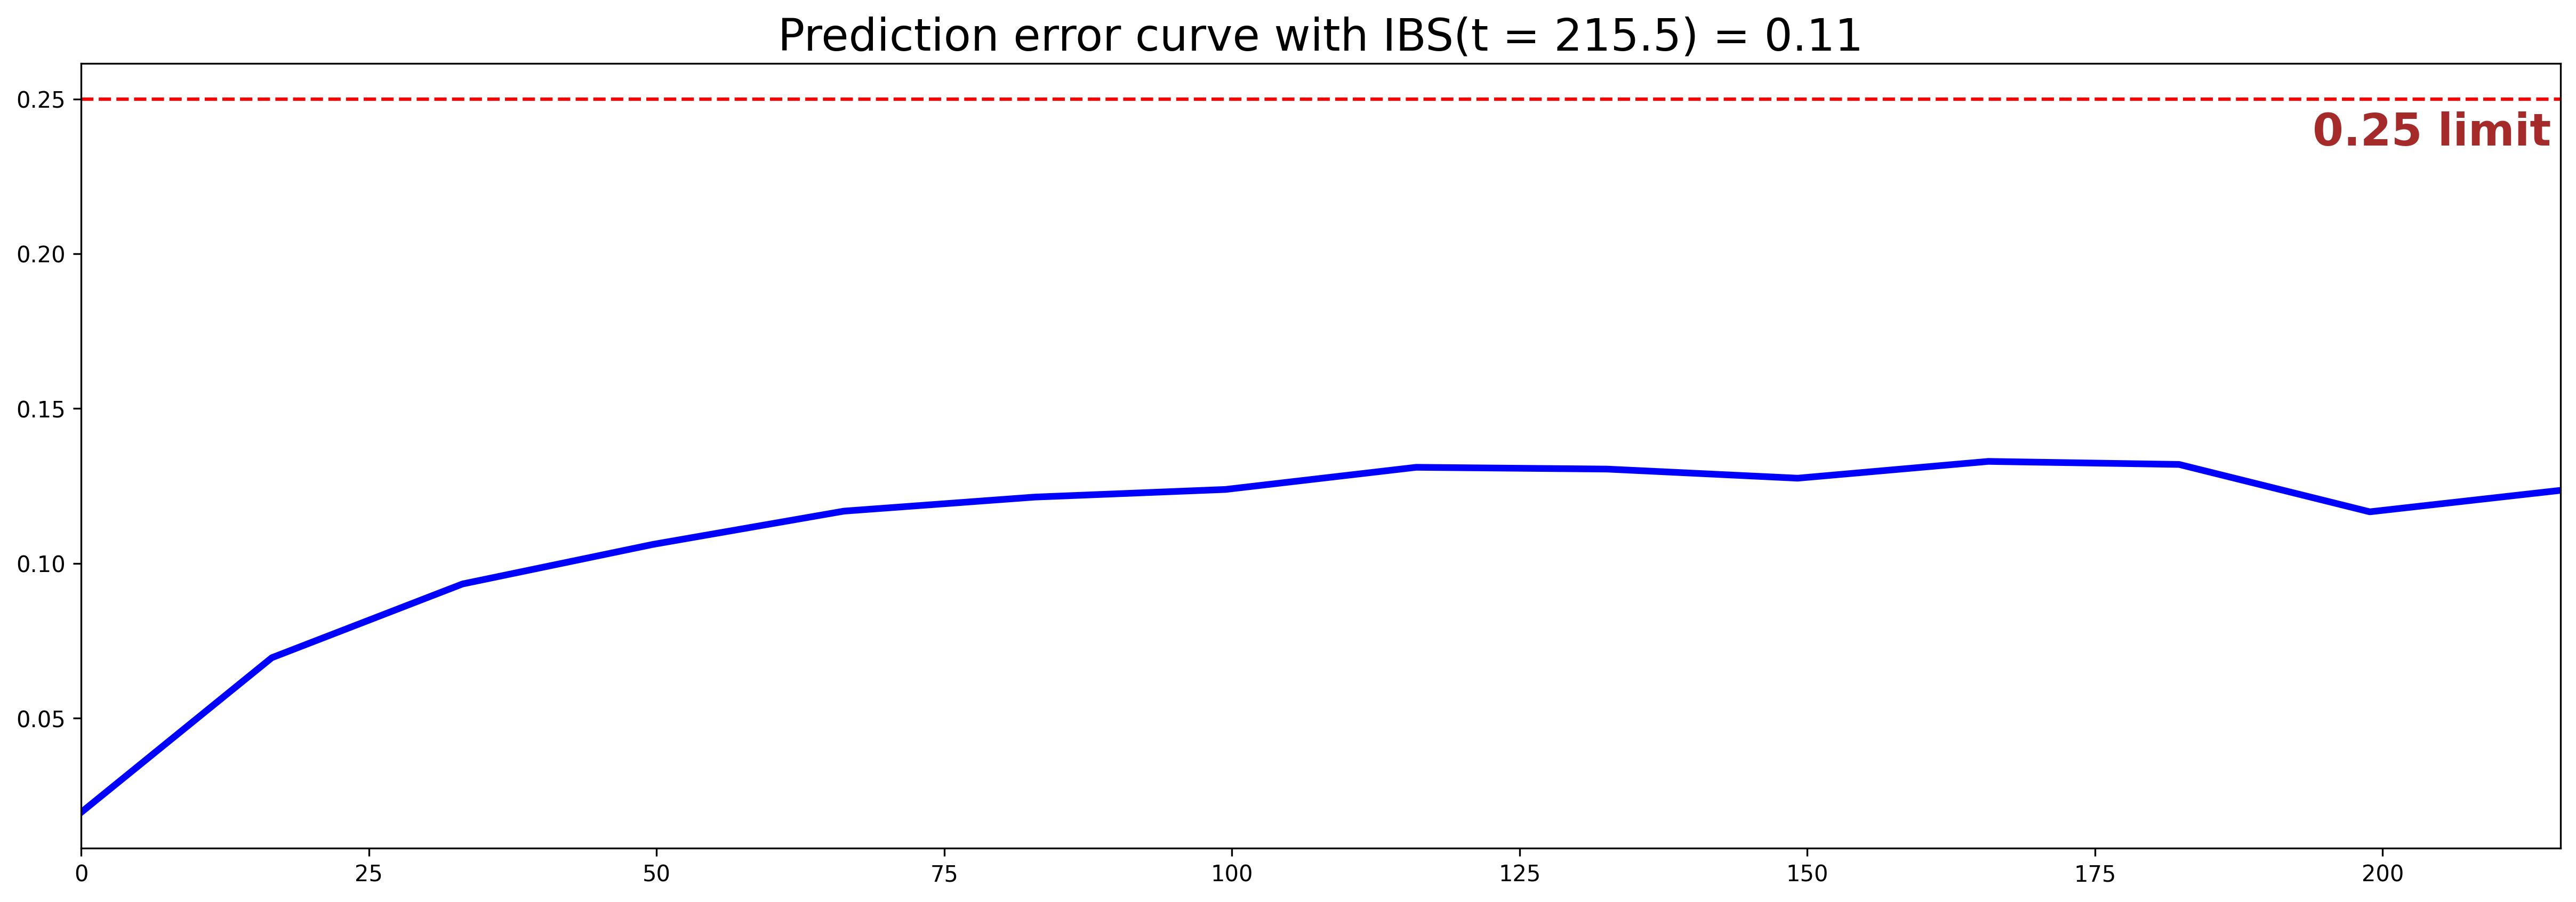

IBS: 0.11


In [399]:
from pysurvival.utils.display import integrated_brier_score
ibs = integrated_brier_score(nmtlr.model, X_test, T_test, E_test,figure_size=(20, 6.5) )
print('IBS: {:.2f}'.format(ibs))

In [400]:
nmtlr.tuning_result['best_param']

{'structure': [{'activation': 'ReLU', 'num_units': 81},
  {'activation': 'InverseSqrt', 'num_units': 47},
  {'activation': 'InverseSqrt', 'num_units': 80}],
 'optimizer': 'rmsprop',
 'bins': 16,
 'lr': 0.00096,
 'num_epochs': 205,
 'dropout': 0.4,
 'l2_reg': 0.0001,
 'l2_smooth': 0.0054,
 'batch_normalization': False}

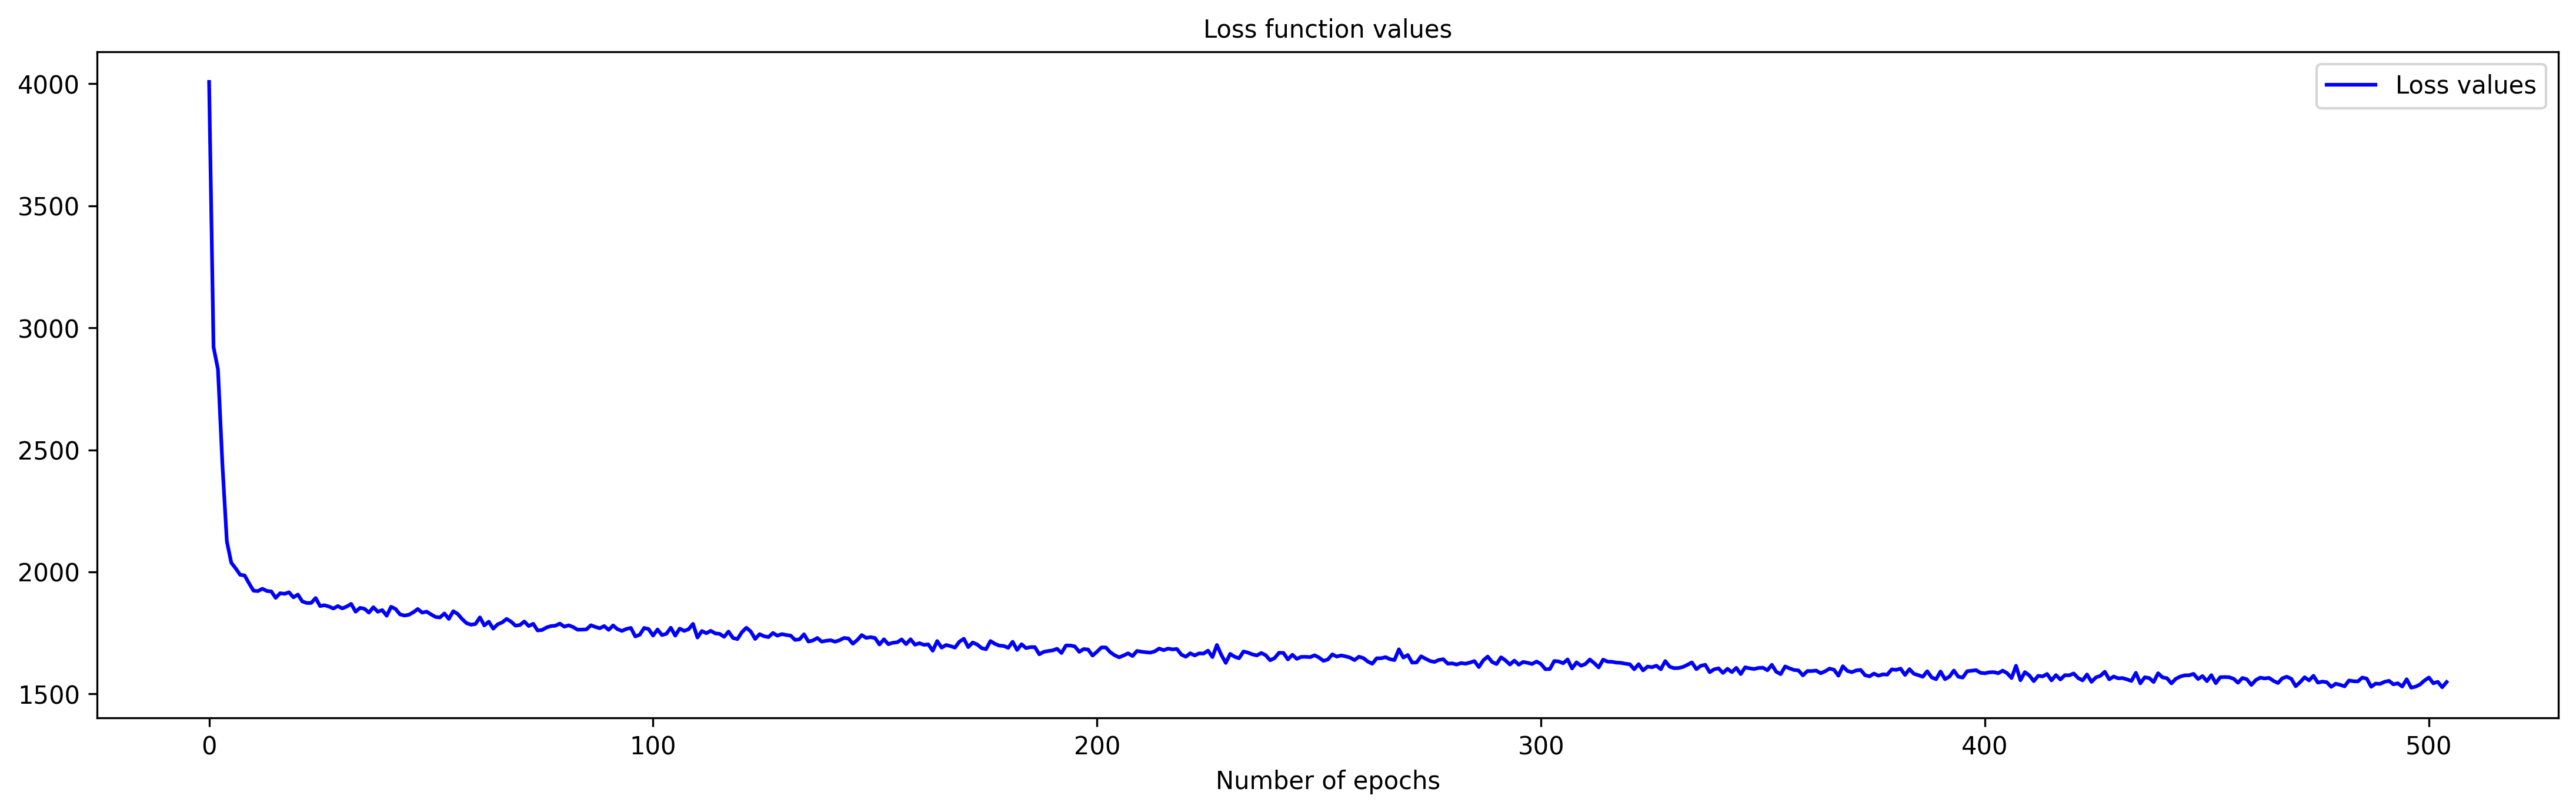

In [402]:
from pysurvival.utils.display import display_loss_values
display_loss_values(nmtlr.model)

#### Tuning DeepSurv

In [272]:
deepsurv = DeepSurv()
deepsurv.tuning_and_construct(X_train, T_train, E_train,max_iter=max_iter)
deepsurv_model = deepsurv.model

Number 1 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2991.77
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2777.49
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|*********************************************************************************************************************************************

mean_c_index:  0.6187834480615559 is the best so far
Number 2 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2182.98
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2155.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2122.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2149.25
% Completion: 100%|*************************************************

mean_c_index:  0.7760209613780413 is the best so far
Number 3 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3018.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2957.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3111.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3016.95
% Completion: 100%|*************************************************

mean_c_index:  0.822598477472981 is the best so far
Number 4 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2958.24
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2989.12
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3039.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2982.28
% Completion: 100%|*************************************************

mean_c_index:  0.7853983782799597 
Number 5 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2899.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2650.32
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2818.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2752.79
% Completion: 100%|*************************************************

mean_c_index:  0.8208777258318113 
Number 6 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2167.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2146.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2229.40
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2037.01
% Completion: 100%|*************************************************

mean_c_index:  0.7966597583566228 
Number 7 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3127.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3160.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3089.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3058.20
% Completion: 100%|*************************************************

mean_c_index:  0.8138650214433415 
Number 8 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3508.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3498.94
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3430.24
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3449.37
% Completion: 100%|*************************************************

mean_c_index:  0.611952118361767 
Number 9 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2998.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2917.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2934.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3064.16
% Completion: 100%|*************************************************

mean_c_index:  0.8377984444547252 is the best so far
Number 10 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2449.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2547.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2470.70
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2422.34
% Completion: 100%|*************************************************

mean_c_index:  0.7765641985406144 
Number 11 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3041.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3016.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3069.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2906.54
% Completion: 100%|*************************************************

mean_c_index:  0.8331344795277605 
Number 12 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2680.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2730.07
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2786.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2608.16
% Completion: 100%|*************************************************

mean_c_index:  0.785113750487391 
Number 13 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3355.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3174.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3337.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3254.40
% Completion: 100%|*************************************************

mean_c_index:  0.8062402885324067 
Number 14 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1591.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1576.60
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.7252212624548611 
Number 15 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1839.12
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1781.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1811.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1787.38
% Completion: 100%|*************************************************

mean_c_index:  0.7693327873670027 
Number 16 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3103.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3031.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3037.54
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2961.74
% Completion: 100%|*************************************************

mean_c_index:  0.7814631794783076 
Number 17 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2267.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2494.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2478.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2554.40
% Completion: 100%|*************************************************

mean_c_index:  0.8033486326595035 
Number 18 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2987.94
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3003.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3016.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2901.44
% Completion: 100%|*************************************************

mean_c_index:  0.8171173420453934 
Number 19 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2773.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2836.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2810.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2831.45
% Completion: 100%|*************************************************

mean_c_index:  0.815324026070704 
Number 20 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3312.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3194.54
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3256.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3314.92
% Completion: 100%|*************************************************

mean_c_index:  0.805362352654857 
Number 21 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2537.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2127.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2113.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2123.88
% Completion: 100%|*************************************************

mean_c_index:  0.7672716407373696 
Number 22 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3112.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3332.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3111.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3166.00
% Completion: 100%|*************************************************

mean_c_index:  0.7753207128641554 
Number 23 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2711.91
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2753.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2834.98
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2767.84
% Completion: 100%|*************************************************

mean_c_index:  0.8242636264861405 
Number 24 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2878.40
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2914.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2945.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2972.18
% Completion: 100%|*************************************************

mean_c_index:  0.834002412593861 
Number 25 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3113.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3112.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3071.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3037.43
% Completion: 100%|*************************************************

mean_c_index:  0.8298602874127681 
Number 26 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2634.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2600.54
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2777.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2608.97
% Completion: 100%|*************************************************

mean_c_index:  0.8004481197237562 
Number 27 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3194.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3190.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3236.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3204.52
% Completion: 100%|*************************************************

mean_c_index:  0.7919627691177779 
Number 28 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3047.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2923.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2916.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2893.39
% Completion: 100%|*************************************************

mean_c_index:  0.8220591044184864 
Number 29 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3184.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3158.13
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3218.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3240.48
% Completion: 100%|*************************************************

mean_c_index:  0.7850286675957487 
Number 30 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2851.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2923.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2845.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3073.11
% Completion: 100%|*************************************************

mean_c_index:  0.8318639908483215 
Number 31 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2025.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1979.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2052.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1876.87
% Completion: 100%|*************************************************

mean_c_index:  0.6602127958557731 
Number 32 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2072.51
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2116.62
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:

mean_c_index:  0.689092158330747 
Number 33 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2813.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2851.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2805.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2787.23
% Completion: 100%|*************************************************

mean_c_index:  0.829705721633762 
Number 34 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3218.74
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3245.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3169.49
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3235.56
% Completion: 100%|*************************************************

mean_c_index:  0.7565561868643732 
Number 35 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3001.13
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3012.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3039.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3046.65
% Completion: 100%|*************************************************

mean_c_index:  0.8253901021853421 
Number 36 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2614.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2758.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2689.48
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2654.14
% Completion: 100%|*************************************************

mean_c_index:  0.8127960776094522 
Number 37 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3113.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2888.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2962.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3111.23
% Completion: 100%|*************************************************

mean_c_index:  0.8190245297281855 
Number 38 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2735.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2916.24
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2875.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2855.58
% Completion: 100%|*************************************************

mean_c_index:  0.8092965174826425 
Number 39 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3009.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2948.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2968.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3052.83
% Completion: 100%|*************************************************

mean_c_index:  0.8217774595478954 
Number 40 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2961.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3119.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3029.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2941.36
% Completion: 100%|*************************************************

mean_c_index:  0.8163655928437334 
Number 41 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3498.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3505.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3397.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3428.02
% Completion: 100%|*************************************************

mean_c_index:  0.5465484478787463 
Number 42 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2989.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3071.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3050.74
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3096.69
% Completion: 100%|*************************************************

mean_c_index:  0.8244414663113371 
Number 43 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3081.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3223.82
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3183.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3114.76
% Completion: 100%|*************************************************

mean_c_index:  0.7945402301509281 
Number 44 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3337.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3443.24
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3517.74
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3354.01
% Completion: 100%|*************************************************

mean_c_index:  0.6261036152354753 
Number 45 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3044.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2971.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3025.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2971.71
% Completion: 100%|*************************************************

mean_c_index:  0.8327550555935941 
Number 46 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3022.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2995.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3028.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3022.78
% Completion: 100%|*************************************************

mean_c_index:  0.8263142138850121 
Number 47 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1902.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2217.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1954.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2895.11
% Completion: 100%|*************************************************

mean_c_index:  0.7434295104509839 
Number 48 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3477.13
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3540.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3405.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3490.09
% Completion: 100%|*************************************************

mean_c_index:  0.5553059991845236 
Number 49 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3363.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3311.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3395.49
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3123.69
% Completion: 100%|*************************************************

mean_c_index:  0.7445891703023829 
Number 50 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3030.22
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3040.23
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3100.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3121.18
% Completion: 100%|*************************************************

mean_c_index:  0.8310905079624948 
Number 51 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2942.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2752.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2913.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2703.25
% Completion: 100%|*************************************************

mean_c_index:  0.8257380494356721 
Number 52 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3478.07
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3284.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3407.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3234.41
% Completion: 100%|*************************************************

mean_c_index:  0.6612255209326144 
Number 53 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2838.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2913.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2934.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2950.58
% Completion: 100%|*************************************************

mean_c_index:  0.8315568477550453 
Number 54 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3486.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3483.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3423.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3476.45
% Completion: 100%|*************************************************

mean_c_index:  0.8082988660306801 
Number 55 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2817.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2666.61
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2670.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2832.40
% Completion: 100%|*************************************************

mean_c_index:  0.7354120765560083 
Number 56 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3026.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3025.32
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2995.74
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3006.18
% Completion: 100%|*************************************************

mean_c_index:  0.7872249285812944 
Number 57 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.7191442939649978 
Number 58 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3523.60
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3480.74
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3638.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3517.26
% Completion: 100%|*************************************************

mean_c_index:  0.7973954929615282 
Number 59 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2965.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3070.41
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3034.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3034.00
% Completion: 100%|*************************************************

mean_c_index:  0.8303172476906078 
Number 60 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2589.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2668.07
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2837.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2744.77
% Completion: 100%|*************************************************

mean_c_index:  0.7810698256672535 
Number 61 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3575.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3456.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3425.45
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3357.71
% Completion: 100%|*************************************************

mean_c_index:  0.6394654256871112 
Number 62 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2935.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3026.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2932.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3032.61
% Completion: 100%|*************************************************

mean_c_index:  0.8298309648620702 
Number 63 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3442.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3381.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3395.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3427.71
% Completion: 100%|*************************************************

mean_c_index:  0.6067429981401506 
Number 64 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3250.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3347.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3188.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3272.37
% Completion: 100%|*************************************************

mean_c_index:  0.7309428909332982 
Number 65 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2614.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2724.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2837.49
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2695.52
% Completion: 100%|*************************************************

mean_c_index:  0.8215142178841308 
Number 66 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3439.22
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3443.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3407.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3469.50
% Completion: 100%|*************************************************

mean_c_index:  0.7991758300192702 
Number 67 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2716.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1315.13
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1412.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1225.92
% Completion: 100%|*************************************************

mean_c_index:  0.7338618766990556 
Number 68 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2241.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2215.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2274.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2305.36
% Completion: 100%|*************************************************

mean_c_index:  0.7751763783305907 
Number 69 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2739.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2775.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2652.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2781.96
% Completion: 100%|*************************************************

mean_c_index:  0.8228356026217029 
Number 70 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3158.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3027.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3144.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3005.52
% Completion: 100%|*************************************************

mean_c_index:  0.7858336296892243 
Number 71 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2960.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2984.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3061.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2933.25
% Completion: 100%|*************************************************

mean_c_index:  0.8165415716074318 
Number 72 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3422.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3415.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3305.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3254.97
% Completion: 100%|*************************************************

mean_c_index:  0.7762423235060076 
Number 73 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2265.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2233.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2400.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2477.98
% Completion: 100%|*************************************************

mean_c_index:  0.8138012254884138 
Number 74 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3041.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3074.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3102.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3048.09
% Completion: 100%|*************************************************

mean_c_index:  0.7988210297329179 
Number 75 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2879.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2812.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2836.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2923.84
% Completion: 100%|*************************************************

mean_c_index:  0.8268554024383402 
Number 76 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2902.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2950.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2951.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2900.30
% Completion: 100%|*************************************************

mean_c_index:  0.8351186997726326 
Number 77 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2777.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2811.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2869.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2855.25
% Completion: 100%|*************************************************

mean_c_index:  0.8037498306600959 
Number 78 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2240.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2085.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2043.78
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1901.73
% Completion: 100%|*************************************************

mean_c_index:  0.7941853269978194 
Number 79 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2954.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3095.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2980.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2920.46
% Completion: 100%|*************************************************

mean_c_index:  0.8168449106617738 
Number 80 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2956.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2901.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2947.70
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3004.06
% Completion: 100%|*************************************************

mean_c_index:  0.8114738514688371 
Number 81 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1779.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1893.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1886.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2013.14
% Completion: 100%|*************************************************

mean_c_index:  0.7384653906515888 
Number 82 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3051.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2994.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3098.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2992.24
% Completion: 100%|*************************************************

mean_c_index:  0.8275990947777394 
Number 83 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3301.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3373.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3330.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3341.30
% Completion: 100%|*************************************************

mean_c_index:  0.7125233690808206 
Number 84 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1948.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1774.45
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1949.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2555.22
% Completion: 100%|*************************************************

mean_c_index:  0.7223779154580972 
Number 85 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1617.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1626.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1688.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1536.20
% Completion: 100%|*************************************************

mean_c_index:  0.6876427066909239 
Number 86 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3014.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2958.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2921.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2968.40
% Completion: 100%|*************************************************

mean_c_index:  0.8331531566718493 
Number 87 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2318.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1799.41
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1702.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1712.77
% Completion: 100%|*************************************************

mean_c_index:  0.71752212440217 
Number 88 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3288.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3412.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3427.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3497.15
% Completion: 100%|*************************************************

mean_c_index:  0.791248343513163 
Number 89 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2857.75
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2796.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2820.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2714.48
% Completion: 100%|*************************************************

mean_c_index:  0.8256375359119594 
Number 90 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3034.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3076.61
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2956.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3010.21
% Completion: 100%|*************************************************

mean_c_index:  0.8147366632109359 
Number 91 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3238.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3122.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3111.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3334.98
% Completion: 100%|*************************************************

mean_c_index:  0.815608950144101 
Number 92 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3334.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3417.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3520.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3338.76
% Completion: 100%|*************************************************

mean_c_index:  0.6510574247514939 
Number 93 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2388.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2411.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2389.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2391.96
% Completion: 100%|*************************************************

mean_c_index:  0.8056616134400194 
Number 94 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2478.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2535.94
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2577.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2618.15
% Completion: 100%|*************************************************

mean_c_index:  0.8003702407481317 
Number 95 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3519.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3563.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3498.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3478.87
% Completion: 100%|*************************************************

mean_c_index:  0.7929202416301471 
Number 96 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2715.40
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1907.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1733.54
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1900.16
% Completion: 100%|*************************************************

mean_c_index:  0.7444857597991559 
Number 97 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1736.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1720.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1613.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1691.31
% Completion: 100%|*************************************************

mean_c_index:  0.702390766863631 
Number 98 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3123.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3374.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3378.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3275.63
% Completion: 100%|*************************************************

mean_c_index:  0.7240444032698128 
Number 99 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1837.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2000.41
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1818.40
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1978.35
% Completion: 100%|*************************************************

mean_c_index:  0.7740877915808726 
Number 100 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3103.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3217.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3332.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3249.86
% Completion: 100%|*************************************************

mean_c_index:  0.7776963017690737 
Number 101 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2998.82
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2976.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2938.22
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2931.05
% Completion: 100%|*************************************************

mean_c_index:  0.8144467643617377 
Number 102 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3092.94
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2950.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3103.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2989.93
% Completion: 100%|*************************************************

mean_c_index:  0.8257267475033878 
Number 103 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3357.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3354.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3247.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3270.98
% Completion: 100%|*************************************************

mean_c_index:  0.7379352975549505 
Number 104 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3370.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3433.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3420.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3490.79
% Completion: 100%|*************************************************

mean_c_index:  0.7071499233264348 
Number 105 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3431.78
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3261.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3361.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3338.77
% Completion: 100%|*************************************************

mean_c_index:  0.6553217016526836 
Number 106 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2999.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2815.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3042.40
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2922.61
% Completion: 100%|*************************************************

mean_c_index:  0.8297269182254334 
Number 107 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2963.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2900.78
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3096.75
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2884.59
% Completion: 100%|*************************************************

mean_c_index:  0.8064326882685536 
Number 108 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2758.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2900.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2852.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2943.81
% Completion: 100%|*************************************************

mean_c_index:  0.8290035472772601 
Number 109 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3123.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3112.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3027.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3265.05
% Completion: 100%|*************************************************

mean_c_index:  0.7394230263617781 
Number 110 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2724.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2814.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2772.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2694.88
% Completion: 100%|*************************************************

mean_c_index:  0.7898816177695344 
Number 111 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2859.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2951.59
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3020.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2933.22
% Completion: 100%|*************************************************

mean_c_index:  0.8296549314203834 
Number 112 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3733.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3545.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3534.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3411.84
% Completion: 100%|*************************************************

mean_c_index:  0.6529480305762256 
Number 113 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3010.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2982.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3091.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3108.37
% Completion: 100%|*************************************************

mean_c_index:  0.8106183708267366 
Number 114 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3160.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2989.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2944.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3028.55
% Completion: 100%|*************************************************

mean_c_index:  0.8193027140014817 
Number 115 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2396.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2313.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2462.94
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2372.73
% Completion: 100%|*************************************************

mean_c_index:  0.762102553249683 
Number 116 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2998.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2929.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2850.75
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3028.61
% Completion: 100%|*************************************************

mean_c_index:  0.8018513162771207 
Number 117 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3001.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3006.13
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2908.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2935.89
% Completion: 100%|*************************************************

mean_c_index:  0.813095754523977 
Number 118 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2650.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2574.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2593.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2707.86
% Completion: 100%|*************************************************

mean_c_index:  0.7958745589139196 
Number 119 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3390.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3351.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3590.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3409.76
% Completion: 100%|*************************************************

mean_c_index:  0.5902825693580954 
Number 120 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3496.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3378.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3473.98
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3363.31
% Completion: 100%|*************************************************

mean_c_index:  0.7402645232723781 
Number 121 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3059.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2940.60
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2983.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3026.30
% Completion: 100%|*************************************************

mean_c_index:  0.8093937764534805 
Number 122 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3399.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3503.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3401.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3415.59
% Completion: 100%|*************************************************

mean_c_index:  0.7391968523874175 
Number 123 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3356.78
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3529.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3409.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3500.27
% Completion: 100%|*************************************************

mean_c_index:  0.545347909580453 
Number 124 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3185.49
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3189.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3319.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3253.82
% Completion: 100%|*************************************************

mean_c_index:  0.790522540094893 
Number 125 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2441.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2512.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2416.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2525.21
% Completion: 100%|*************************************************

mean_c_index:  0.760681761890262 
Number 126 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2964.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3036.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3011.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2978.73
% Completion: 100%|*************************************************

mean_c_index:  0.8276081166314502 
Number 127 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1952.45
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1924.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1798.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1871.01
% Completion: 100%|*************************************************

mean_c_index:  0.7470837460624125 
Number 128 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3063.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2973.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3260.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3214.48
% Completion: 100%|*************************************************

mean_c_index:  0.787801337468281 
Number 129 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2840.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2900.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2918.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2884.06
% Completion: 100%|*************************************************

mean_c_index:  0.8153988880776373 
Number 130 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3968.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3541.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3652.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4053.21
% Completion: 100%|*************************************************

mean_c_index:  0.6221094260654709 
Number 131 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2720.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2825.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2726.56
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.7716420760644186 
Number 132 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3627.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3849.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3503.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3750.48
% Completion: 100%|*************************************************

mean_c_index:  0.6041165450428609 
Number 133 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3456.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3512.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3347.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3500.75
% Completion: 100%|*************************************************

mean_c_index:  0.7073743266213808 
Number 134 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3186.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3050.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3058.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3071.49
% Completion: 100%|*************************************************

mean_c_index:  0.8123203305740618 
Number 135 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3135.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2923.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3052.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3013.30
% Completion: 100%|*************************************************

mean_c_index:  0.814421280052984 
Number 136 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2933.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2750.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2828.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2938.07
% Completion: 100%|*************************************************

mean_c_index:  0.8223668213245577 
Number 137 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3469.78
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3536.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3412.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3368.98
% Completion: 100%|*************************************************

mean_c_index:  0.697081283599162 
Number 138 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2384.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2209.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2323.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2375.60
% Completion: 100%|*************************************************

mean_c_index:  0.7721699115032188 
Number 139 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3308.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3219.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3333.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3406.88
% Completion: 100%|*************************************************

mean_c_index:  0.766993617710957 
Number 140 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3008.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2982.75
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3121.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3017.90
% Completion: 100%|*************************************************

mean_c_index:  0.8169319141742808 
Number 141 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3232.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3337.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3132.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3674.45
% Completion: 100%|*************************************************

mean_c_index:  0.6360424789594618 
Number 142 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3458.12
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3561.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3585.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3605.41
% Completion: 100%|*************************************************

mean_c_index:  0.5463608627988796 
Number 143 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3035.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3062.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3044.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3140.60
% Completion: 100%|*************************************************

mean_c_index:  0.7996972399882781 
Number 144 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2157.49
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2034.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1939.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2006.11
% Completion: 100%|*************************************************

mean_c_index:  0.778167962724748 
Number 145 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3078.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3080.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2902.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3113.72
% Completion: 100%|*************************************************

mean_c_index:  0.8024142313630387 
Number 146 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1989.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1999.60
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1902.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1925.62
% Completion: 100%|*************************************************

mean_c_index:  0.779387413589164 
Number 147 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2957.12
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2951.78
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2927.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2919.89
% Completion: 100%|*************************************************

mean_c_index:  0.8323968782476607 
Number 148 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3286.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3456.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3454.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3510.59
% Completion: 100%|*************************************************

mean_c_index:  0.6129215966676659 
Number 149 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2162.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2074.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2036.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2027.59
% Completion: 100%|*************************************************

mean_c_index:  0.7955334023947864 
Number 150 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1963.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2027.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2447.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2286.51
% Completion: 100%|*************************************************

mean_c_index:  0.7659143921421896 
Number 151 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3051.91
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2992.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3031.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2856.61
% Completion: 100%|*************************************************

mean_c_index:  0.8316778788204646 
Number 152 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3551.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3511.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3385.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3565.04
% Completion: 100%|*************************************************

mean_c_index:  0.6281590877206271 
Number 153 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3154.13
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3080.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3155.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3064.39
% Completion: 100%|*************************************************

mean_c_index:  0.714779085371346 
Number 154 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3110.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3170.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3180.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3118.31
% Completion: 100%|*************************************************

mean_c_index:  0.8261317599910759 
Number 155 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3400.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3389.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3317.41
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3273.09
% Completion: 100%|*************************************************

mean_c_index:  0.8002040348443089 
Number 156 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3189.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3152.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3206.40
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3186.62
% Completion: 100%|*************************************************

mean_c_index:  0.7235852436325099 
Number 157 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2573.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2477.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2564.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2543.33
% Completion: 100%|*************************************************

mean_c_index:  0.8132216047926514 
Number 158 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3410.23
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3469.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3452.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3417.98
% Completion: 100%|*************************************************

mean_c_index:  0.793214159394094 
Number 159 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2652.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2631.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2443.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2613.72
% Completion: 100%|*************************************************

mean_c_index:  0.7947816275878385 
Number 160 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2728.22
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2830.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2770.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2649.61
% Completion: 100%|*************************************************

mean_c_index:  0.804335653239287 
Number 161 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3534.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3693.36
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3496.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3369.01
% Completion: 100%|*************************************************

mean_c_index:  0.5808499523245615 
Number 162 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3027.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2922.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3080.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3011.77
% Completion: 100%|*************************************************

mean_c_index:  0.8302478565438651 
Number 163 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3522.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3593.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3605.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3646.06
% Completion: 100%|*************************************************

mean_c_index:  0.7894871535049675 
Number 164 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2980.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3042.82
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2917.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3085.39
% Completion: 100%|*************************************************

mean_c_index:  0.8051316698161045 
Number 165 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2883.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2832.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2807.61
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2871.36
% Completion: 100%|*************************************************

mean_c_index:  0.8312043013159359 
Number 166 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3355.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3049.49
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3143.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3181.73
% Completion: 100%|*************************************************

mean_c_index:  0.7718188642233962 
Number 167 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2796.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2756.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2876.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2755.68
% Completion: 100%|*************************************************

mean_c_index:  0.7717197040207023 
Number 168 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3804.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3862.41
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3402.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3407.14


mean_c_index:  0.5925623866052787 
Number 169 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2355.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2330.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2395.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2268.60
% Completion: 100%|*************************************************

mean_c_index:  0.8072386521591319 
Number 170 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3349.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3450.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3494.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3329.22
% Completion: 100%|*************************************************

mean_c_index:  0.8147455095951532 
Number 171 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3174.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3108.45
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3134.55
% Completion: 100%|***********************************************************************************************

mean_c_index:  0.79991190311463 
Number 172 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2406.36
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2320.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2280.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2526.02
% Completion: 100%|*************************************************

mean_c_index:  0.7920357148889775 
Number 173 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3440.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3443.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3484.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3288.60
% Completion: 100%|*************************************************

mean_c_index:  0.7492100153238674 
Number 174 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3274.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3208.54
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3039.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3149.19
% Completion: 100%|*************************************************

mean_c_index:  0.7457703592429891 
Number 175 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3006.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2981.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3047.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2940.16
% Completion: 100%|*************************************************

mean_c_index:  0.8167029360152828 
Number 176 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3098.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2990.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3075.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2954.80
% Completion: 100%|*************************************************

mean_c_index:  0.8275325277733743 
Number 177 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3031.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3091.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3152.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3130.96
% Completion: 100%|*************************************************

mean_c_index:  0.8237160511568161 
Number 178 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2115.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2097.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2046.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2024.80
% Completion: 100%|*************************************************

mean_c_index:  0.7579693022797585 
Number 179 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2873.22
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2979.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2919.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2837.33
% Completion: 100%|*************************************************

mean_c_index:  0.8321760328591556 
Number 180 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1763.49
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 5058.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1774.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2240.31
% Completion: 100%|*************************************************

mean_c_index:  0.7088180904426203 
Number 181 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2906.12
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2802.75
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2849.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2710.52
% Completion: 100%|*************************************************

mean_c_index:  0.8092485620171527 
Number 182 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3015.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2956.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3075.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3022.31
% Completion: 100%|*************************************************

mean_c_index:  0.8229334428206523 
Number 183 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3063.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3107.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3229.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3185.02
% Completion: 100%|*************************************************

mean_c_index:  0.7990250971588625 
Number 184 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2092.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2148.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2121.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2148.54
% Completion: 100%|*************************************************

mean_c_index:  0.60601069344776 
Number 185 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3051.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2887.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3017.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3047.00
% Completion: 100%|*************************************************

mean_c_index:  0.8318582230010103 
Number 186 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2989.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2989.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2999.60
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2974.12
% Completion: 100%|*************************************************

mean_c_index:  0.8121081924911742 
Number 187 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3423.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3500.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3490.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3434.86
% Completion: 100%|*************************************************

mean_c_index:  0.5809073107985324 
Number 188 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2621.48
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2618.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2494.69
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:

mean_c_index:  0.7431900360772797 
Number 189 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3013.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2973.22
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3019.91
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3095.31
% Completion: 100%|*************************************************

mean_c_index:  0.8314354453071366 
Number 190 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2698.94
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2409.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2603.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2353.29
% Completion: 100%|*************************************************

mean_c_index:  0.7584927840640068 
Number 191 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3007.22
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3093.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2992.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3078.34
% Completion: 100%|*************************************************

mean_c_index:  0.8306449942211092 
Number 192 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3056.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3053.70
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3102.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2992.89
% Completion: 100%|*************************************************

mean_c_index:  0.8058130553789777 
Number 193 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1674.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1640.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1533.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1650.42
% Completion: 100%|*************************************************

mean_c_index:  0.7085612920584469 
Number 194 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3016.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2958.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2810.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2954.63
% Completion: 100%|*************************************************

mean_c_index:  0.8420605913279966 is the best so far
Number 195 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3175.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3551.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3243.23
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3560.08
% Completion: 100%|*************************************************

mean_c_index:  0.5982124996174067 
Number 196 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2863.98
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3121.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3044.94
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3117.87
% Completion: 100%|*************************************************

mean_c_index:  0.8051089066182973 
Number 197 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2968.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3030.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2902.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2997.78
% Completion: 100%|*************************************************

mean_c_index:  0.8394998696755718 
Number 198 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3111.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3105.22
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3065.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3040.92
% Completion: 100%|*************************************************

mean_c_index:  0.7945589037122955 
Number 199 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2960.94
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2891.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2791.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2890.20
% Completion: 100%|*************************************************

mean_c_index:  0.8288725884025394 
Number 200 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2219.39
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2154.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2275.28
% Completion: 100%|***********************************************************************************************

mean_c_index:  0.73571770073878 
Number 201 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1679.22
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1577.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1593.12
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1559.87
% Completion: 100%|*************************************************

mean_c_index:  0.7012560275447759 
Number 202 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3122.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3118.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3173.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3161.41
% Completion: 100%|*************************************************

mean_c_index:  0.8069771785742355 
Number 203 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3073.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3004.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3002.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3054.04
% Completion: 100%|*************************************************

mean_c_index:  0.818299324071947 
Number 204 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2327.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2410.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2517.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2569.46
% Completion: 100%|*************************************************

mean_c_index:  0.7209551997057941 
Number 205 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2055.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2065.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2027.70
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2182.67
% Completion: 100%|*************************************************

mean_c_index:  0.7676256324862402 
Number 206 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3339.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3262.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3441.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3179.79
% Completion: 100%|*************************************************

mean_c_index:  0.7489274901208446 
Number 207 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3774.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3747.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3857.12
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3711.22
% Completion: 100%|*************************************************

mean_c_index:  0.5708719981713427 
Number 208 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3453.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3576.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3538.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3397.25
% Completion: 100%|*************************************************

mean_c_index:  0.6911396317634895 
Number 209 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3444.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3506.32
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3456.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3311.70
% Completion: 100%|*************************************************

mean_c_index:  0.7053770549841933 
Number 210 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3572.32
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3623.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3899.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3903.50
% Completion: 100%|*************************************************

mean_c_index:  0.5781610822483858 
Number 211 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3294.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3229.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3224.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3087.14
% Completion: 100%|*************************************************

mean_c_index:  0.7942297390644415 
Number 212 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2967.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2917.91
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3026.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3033.52
% Completion: 100%|*************************************************

mean_c_index:  0.8330350165200049 
Number 213 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3077.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3019.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2946.83
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.78898046849187 
Number 214 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2122.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1867.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2111.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2070.04
% Completion: 100%|*************************************************

mean_c_index:  0.7248818700465158 
Number 215 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3008.41
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3072.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3097.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2992.34
% Completion: 100%|*************************************************

mean_c_index:  0.7911938581482597 
Number 216 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2556.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2536.44
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.7718659256180199 
Number 217 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3440.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3502.13
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3483.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3423.96
% Completion: 100%|*************************************************

mean_c_index:  0.8045675322194551 
Number 218 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2551.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2502.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2502.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2531.52
% Completion: 100%|*************************************************

mean_c_index:  0.7769247629245093 
Number 219 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2325.07
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2360.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2301.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2348.68
% Completion: 100%|*************************************************

mean_c_index:  0.7496430507645447 
Number 220 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2986.32
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2941.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2860.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2880.29
% Completion: 100%|*************************************************

mean_c_index:  0.7966953351842837 
Number 221 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3122.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3113.41
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3047.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3078.76
% Completion: 100%|*************************************************

mean_c_index:  0.8127337244970354 
Number 222 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2179.12
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2135.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2295.70
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2095.08
% Completion: 100%|*************************************************

mean_c_index:  0.7701838834193551 
Number 223 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3137.46
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.7285570468904472 
Number 224 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2968.59
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3025.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3041.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3031.26
% Completion: 100%|*************************************************

mean_c_index:  0.8324106492866697 
Number 225 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


The #1 argument contains null values
mean_c_index:  0.6700178759198686 
Number 226 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2899.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2769.59
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2887.61
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2765.12
% Completion: 100%|*************************************************

mean_c_index:  0.828413574388979 
Number 227 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1650.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1633.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1670.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1728.39
% Completion: 100%|*************************************************

mean_c_index:  0.7270985643991297 
Number 228 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3360.94
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3350.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3398.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3500.00
% Completion: 100%|*************************************************

mean_c_index:  0.7867978094486441 
Number 229 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3033.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3006.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3016.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3105.75
% Completion: 100%|*************************************************

mean_c_index:  0.8120821287491505 
Number 230 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2981.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2954.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3066.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2873.55
% Completion: 100%|*************************************************

mean_c_index:  0.8162540552518396 
Number 231 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2926.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2854.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2840.61
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2875.45
% Completion: 100%|*************************************************

mean_c_index:  0.8366137344267186 
Number 232 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3478.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3403.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3414.23
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3404.50
% Completion: 100%|*************************************************

mean_c_index:  0.7927811986506634 
Number 233 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1574.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1583.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1531.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1691.12
% Completion: 100%|*************************************************

mean_c_index:  0.6950311185493181 
Number 234 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2936.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2955.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2843.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2947.91
% Completion: 100%|*************************************************

mean_c_index:  0.8080142389938523 
Number 235 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2733.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2751.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2577.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2708.51
% Completion: 100%|*************************************************

mean_c_index:  0.796989792812276 
Number 236 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1987.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2088.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1982.94
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1973.62
% Completion: 100%|*************************************************

mean_c_index:  0.7842668405311918 
Number 237 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1834.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1882.12
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1946.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1990.01
% Completion: 100%|*************************************************

mean_c_index:  0.719559745822536 
Number 238 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3093.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3038.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2926.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3088.71
% Completion: 100%|*************************************************

mean_c_index:  0.8110699210466606 
Number 239 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1669.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1771.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1812.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1625.53
% Completion: 100%|*************************************************

mean_c_index:  0.7699764202824901 
Number 240 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2777.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2762.75
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2763.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2698.61
% Completion: 100%|*************************************************

mean_c_index:  0.8175754554159367 
Number 241 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3054.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3098.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2916.78
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2922.71
% Completion: 100%|*************************************************

mean_c_index:  0.829979871327069 
Number 242 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2442.54
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2531.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2654.75
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2634.11
% Completion: 100%|*************************************************

mean_c_index:  0.8048232469987567 
Number 243 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3314.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3381.82
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3546.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3359.09
% Completion: 100%|*************************************************

mean_c_index:  0.5834864029309482 
Number 244 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2628.91
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2585.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2607.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2659.66
% Completion: 100%|*************************************************

mean_c_index:  0.799021436040563 
Number 245 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2138.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1982.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1881.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2013.11
% Completion: 100%|*************************************************

mean_c_index:  0.7975927058707695 
Number 246 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2831.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2883.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2822.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2703.16
% Completion: 100%|*************************************************

mean_c_index:  0.8333878952547131 
Number 247 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3095.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3163.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3447.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3100.52
% Completion: 100%|*************************************************

mean_c_index:  0.7566911339796123 
Number 248 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1963.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2003.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2018.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1936.22
% Completion: 100%|*************************************************

mean_c_index:  0.6896623864313169 
Number 249 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3018.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2870.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2958.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3055.56
% Completion: 100%|*************************************************

mean_c_index:  0.7914637424699568 
Number 250 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3363.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3397.40
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3466.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3649.53
% Completion: 100%|*************************************************

mean_c_index:  0.6304399415396784 
Number 251 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3494.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3579.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3438.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3506.68
% Completion: 100%|*************************************************

mean_c_index:  0.5924812528298934 
Number 252 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3429.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3558.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3587.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3620.15
% Completion: 100%|*************************************************

mean_c_index:  0.5656769076764104 
Number 253 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3563.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3363.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3320.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3454.06
% Completion: 100%|*************************************************

mean_c_index:  0.7373021843235488 
Number 254 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2554.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2647.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2511.13
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2638.66
% Completion: 100%|*************************************************

mean_c_index:  0.8137287249979401 
Number 255 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3111.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3169.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3071.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3136.32
% Completion: 100%|*************************************************

mean_c_index:  0.8248653974153435 
Number 256 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2923.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2901.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2979.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2800.68
% Completion: 100%|*************************************************

mean_c_index:  0.8199365623383935 
Number 257 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2938.75
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2956.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3102.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3054.55
% Completion: 100%|*************************************************

mean_c_index:  0.8288470108319365 
Number 258 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3381.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3361.91
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3379.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3306.97
% Completion: 100%|*************************************************

mean_c_index:  0.7482848960307619 
Number 259 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2864.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3025.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2933.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2932.20
% Completion: 100%|*************************************************

mean_c_index:  0.8352476669593807 
Number 260 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3063.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2946.07
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2951.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3031.91
% Completion: 100%|*************************************************

mean_c_index:  0.8246519115429308 
Number 261 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3000.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2963.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2931.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2912.22
% Completion: 100%|*************************************************

mean_c_index:  0.8286894911899478 
Number 262 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3069.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3203.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3225.78
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3137.12
% Completion: 100%|*************************************************

mean_c_index:  0.8235826928511083 
Number 263 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3466.12
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3429.12
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3418.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3471.46
% Completion: 100%|*************************************************

mean_c_index:  0.7559130453662706 
Number 264 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2902.45
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2883.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2809.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2919.35
% Completion: 100%|*************************************************

mean_c_index:  0.8216106492209357 
Number 265 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2644.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2626.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2624.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2578.85
% Completion: 100%|*************************************************

mean_c_index:  0.8258748422197044 
Number 266 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3196.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3183.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3188.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3141.28
% Completion: 100%|*************************************************

mean_c_index:  0.8159873581936827 
Number 267 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1793.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1764.98
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1746.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1869.76
% Completion: 100%|*************************************************

mean_c_index:  0.7628097188134303 
Number 268 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3040.48
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3059.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3090.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2931.45
% Completion: 100%|*************************************************

mean_c_index:  0.8105594098053512 
Number 269 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3156.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3152.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3247.13
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3179.05
% Completion: 100%|*************************************************

mean_c_index:  0.709779070413483 
Number 270 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3071.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3096.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2981.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3057.43
% Completion: 100%|*************************************************

mean_c_index:  0.8212659184092533 
Number 271 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2990.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3098.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2946.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2927.38
% Completion: 100%|*************************************************

mean_c_index:  0.824748774028528 
Number 272 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2339.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2213.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2293.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2201.82
% Completion: 100%|*************************************************

mean_c_index:  0.7363626838006357 
Number 273 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1995.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1961.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2024.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2088.17
% Completion: 100%|*************************************************

mean_c_index:  0.7066613275994971 
Number 274 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3422.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3421.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3481.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3562.22
% Completion: 100%|*************************************************

mean_c_index:  0.6044895046393963 
Number 275 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2743.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2820.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2695.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2807.38
% Completion: 100%|*************************************************

mean_c_index:  0.8267360692670538 
Number 276 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2379.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2432.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2476.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2373.84
% Completion: 100%|*************************************************

mean_c_index:  0.802383339088324 
Number 277 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3283.32
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3079.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3197.61
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3254.26
% Completion: 100%|*************************************************

mean_c_index:  0.8178364298212403 
Number 278 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2640.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2559.61
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2641.40
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2614.09
% Completion: 100%|*************************************************

mean_c_index:  0.8046867653759285 
Number 279 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2848.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2898.54
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2879.40
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2888.61
% Completion: 100%|*************************************************

mean_c_index:  0.8212565498929443 
Number 280 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2931.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2901.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2920.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2953.42
% Completion: 100%|*************************************************

mean_c_index:  0.830846893635232 
Number 281 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1304.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1276.22
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1307.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1293.59
% Completion: 100%|*************************************************

mean_c_index:  0.6921016256178502 
Number 282 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2963.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2987.75
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3071.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2887.46
% Completion: 100%|*************************************************

mean_c_index:  0.8331748038656354 
Number 283 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2808.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2892.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2705.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2669.76
% Completion: 100%|*************************************************

mean_c_index:  0.8220606050840402 
Number 284 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3022.36
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3072.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3095.94
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3024.77
% Completion: 100%|*************************************************

mean_c_index:  0.8340132553731344 
Number 285 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2932.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2973.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3004.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3016.31
% Completion: 100%|*************************************************

mean_c_index:  0.8222395420163956 
Number 286 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3109.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2967.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2950.49
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3126.49
% Completion: 100%|*************************************************

mean_c_index:  0.7913520863560606 
Number 287 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2740.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2732.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2745.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2777.12
% Completion: 100%|*************************************************

mean_c_index:  0.8215478181620078 
Number 288 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2837.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2916.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2981.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2872.36
% Completion: 100%|*************************************************

mean_c_index:  0.8367714603659181 
Number 289 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1935.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1845.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1881.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1917.23
% Completion: 100%|*************************************************

mean_c_index:  0.7489609671783181 
Number 290 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3066.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2972.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3047.40
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2941.80
% Completion: 100%|*************************************************

mean_c_index:  0.8217747444285189 
Number 291 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4013.82
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3732.49
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3780.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3495.69
% Completion: 100%|*************************************************

mean_c_index:  0.6480207226859547 
Number 292 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3364.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3314.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3146.61
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3278.10


mean_c_index:  0.7776536926803678 
Number 293 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2239.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2117.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2393.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2179.60
% Completion: 100%|*************************************************

mean_c_index:  0.8091484189599722 
Number 294 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2971.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2923.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2934.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2961.01
% Completion: 100%|*************************************************

mean_c_index:  0.8155746330439537 
Number 295 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2830.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2944.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2999.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2907.33
% Completion: 100%|*************************************************

mean_c_index:  0.8207869950214214 
Number 296 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3018.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3073.61
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3149.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2922.99
% Completion: 100%|*************************************************

mean_c_index:  0.829290791849645 
Number 297 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1952.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1992.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1982.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1936.21
% Completion: 100%|*************************************************

mean_c_index:  0.7173031852794953 
Number 298 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1454.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1529.94
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1523.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1590.33
% Completion: 100%|*************************************************

mean_c_index:  0.7289868440339753 
Number 299 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3199.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3499.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3400.13
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3367.89
% Completion: 100%|*************************************************

mean_c_index:  0.5840465771350682 
Number 300 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3026.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2963.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3015.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3140.68
% Completion: 100%|*************************************************

mean_c_index:  0.8288254782939948 
Number 301 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3010.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3049.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3014.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3015.37
% Completion: 100%|*************************************************

mean_c_index:  0.8100404671866759 
Number 302 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2362.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2224.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2446.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2264.41
% Completion: 100%|*************************************************

mean_c_index:  0.7615022763054261 
Number 303 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3445.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3341.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3441.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3435.01
% Completion: 100%|*************************************************

mean_c_index:  0.8199314568935454 
Number 304 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3004.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2946.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3047.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2857.05
% Completion: 100%|*************************************************

mean_c_index:  0.8108042863748895 
Number 305 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3182.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3435.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3294.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3279.91
% Completion: 100%|*************************************************

mean_c_index:  0.725926286714277 
Number 306 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2855.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2845.78
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2789.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2810.92
% Completion: 100%|*************************************************

mean_c_index:  0.8148985680391767 
Number 307 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2976.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3072.82
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3029.75
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2978.74
% Completion: 100%|*************************************************

mean_c_index:  0.8320266995264045 
Number 308 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1518.07
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1439.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1507.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1519.82
% Completion: 100%|*************************************************

mean_c_index:  0.70448626314733 
Number 309 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3532.22
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3534.61
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3576.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3579.72
% Completion: 100%|*************************************************

mean_c_index:  0.6113729554785653 
Number 310 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2921.41
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3004.59
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3054.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2925.58
% Completion: 100%|*************************************************

mean_c_index:  0.8368619056149387 
Number 311 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2932.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3005.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2970.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2955.15
% Completion: 100%|*************************************************

mean_c_index:  0.8226403645375587 
Number 312 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1769.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1907.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1933.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1908.64
% Completion: 100%|*************************************************

mean_c_index:  0.6685211409600214 
Number 313 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3123.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3013.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3081.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2952.50
% Completion: 100%|*************************************************

mean_c_index:  0.8195821625086719 
Number 314 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3271.74
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3316.24
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3230.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3299.85
% Completion: 100%|*************************************************

mean_c_index:  0.8124655380370539 
Number 315 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3410.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3476.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3613.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3578.25
% Completion: 100%|*************************************************

mean_c_index:  0.5606440538752636 
Number 316 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3131.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3262.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3107.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3144.69
% Completion: 100%|*************************************************

mean_c_index:  0.7984187700359653 
Number 317 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2951.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2934.36
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2968.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3001.46
% Completion: 100%|*************************************************

mean_c_index:  0.822269127521656 
Number 318 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2897.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2853.23
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2922.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2818.19
% Completion: 100%|*************************************************

mean_c_index:  0.8318874518888633 
Number 319 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2844.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2948.54
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2925.49
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2966.67
% Completion: 100%|*************************************************

mean_c_index:  0.8080894510670904 
Number 320 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2836.22
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2716.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2797.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2785.32
% Completion: 100%|*************************************************

mean_c_index:  0.8010628564677271 
Number 321 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3082.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2934.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3002.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3016.22
% Completion: 100%|*************************************************

mean_c_index:  0.8200690293348455 
Number 322 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1551.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1601.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1531.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1497.61
% Completion: 100%|*************************************************

mean_c_index:  0.6972405612912981 
Number 323 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3004.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2927.59
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3005.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3020.63
% Completion: 100%|*************************************************

mean_c_index:  0.827762910140666 
Number 324 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3510.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3479.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3564.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3394.64
% Completion: 100%|*************************************************

mean_c_index:  0.7242261354907802 
Number 325 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2009.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2186.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2356.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2151.16
% Completion: 100%|*************************************************

mean_c_index:  0.797577141063243 
Number 326 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3721.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3181.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3556.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3640.48
% Completion: 100%|*************************************************

mean_c_index:  0.6100498000725518 
Number 327 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3022.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3025.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2967.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2923.40
% Completion: 100%|*************************************************

mean_c_index:  0.8100744203650742 
Number 328 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3063.41
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3122.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3038.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3140.48
% Completion: 100%|*************************************************

mean_c_index:  0.8281411817772637 
Number 329 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2635.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2515.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2632.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2740.60
% Completion: 100%|*************************************************

mean_c_index:  0.7985753828509627 
Number 330 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3611.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3601.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3409.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3522.21
% Completion: 100%|*************************************************

mean_c_index:  0.5713485111617078 
Number 331 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1422.62
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1347.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1527.59
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:

mean_c_index:  0.6837688422662531 
Number 332 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2780.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2910.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2857.45
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2814.68
% Completion: 100%|*************************************************

mean_c_index:  0.8241426768501634 
Number 333 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2898.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3000.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3126.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3045.73
% Completion: 100%|*************************************************

mean_c_index:  0.8279061199315869 
Number 334 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2193.61
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2430.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2106.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2226.92
% Completion: 100%|*************************************************

mean_c_index:  0.7836562307232336 
Number 335 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3488.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3452.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3389.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3489.22
% Completion: 100%|*************************************************

mean_c_index:  0.58454699844001 
Number 336 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2620.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2593.54
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2587.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2691.61
% Completion: 100%|*************************************************

mean_c_index:  0.8021575906271107 
Number 337 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1722.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1726.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1784.41
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1859.53
% Completion: 100%|*************************************************

mean_c_index:  0.7327138595492875 
Number 338 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2811.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2834.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2852.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2897.45
% Completion: 100%|*************************************************

mean_c_index:  0.792884897820767 
Number 339 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2859.07
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2929.40
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2858.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2926.73
% Completion: 100%|*************************************************

mean_c_index:  0.7789839164356177 
Number 340 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2129.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2142.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2128.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2349.02
% Completion: 100%|*************************************************

mean_c_index:  0.7775720358890751 
Number 341 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2291.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2352.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2256.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2329.02
% Completion: 100%|*************************************************

mean_c_index:  0.7795717690202839 
Number 342 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1714.32
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2004.13
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|*********************************************************************************************************************************************

mean_c_index:  0.6846122039916491 
Number 343 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2944.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2994.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2983.98
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3065.07
% Completion: 100%|*************************************************

mean_c_index:  0.8176449173887322 
Number 344 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3069.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3090.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3154.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3128.83
% Completion: 100%|*************************************************

mean_c_index:  0.8165660388671139 
Number 345 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2271.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2373.98
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2366.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2042.29
% Completion: 100%|*************************************************

mean_c_index:  0.7745723352221254 
Number 346 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4574.48
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4048.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3744.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4330.39
% Completion: 100%|*************************************************

mean_c_index:  0.594708815890697 
Number 347 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3643.70
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3808.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3636.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3617.75
% Completion: 100%|*************************************************

mean_c_index:  0.5613826792739542 
Number 348 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2939.60
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2962.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3010.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2897.61
% Completion: 100%|*************************************************

mean_c_index:  0.8158442766744706 
Number 349 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3005.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3025.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3041.78
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2974.03
% Completion: 100%|*************************************************

mean_c_index:  0.8091855700489601 
Number 350 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3715.49
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3898.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3771.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3645.52
% Completion: 100%|*************************************************

mean_c_index:  0.5647468882268905 
Number 351 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3495.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3372.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3515.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3549.10
% Completion: 100%|*************************************************

mean_c_index:  0.7697187549759936 
Number 352 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3290.32
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3300.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3331.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3317.55
% Completion: 100%|*************************************************

mean_c_index:  0.8085903229599047 
Number 353 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2949.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3101.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2928.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3087.62
% Completion: 100%|*************************************************

mean_c_index:  0.8177839528195238 
Number 354 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2958.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2953.07
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3045.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3073.29
% Completion: 100%|*************************************************

mean_c_index:  0.8189218910879106 
Number 355 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2390.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2448.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2442.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2484.61
% Completion: 100%|*************************************************

mean_c_index:  0.7967415866456818 
Number 356 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1773.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1826.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1918.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1843.21
% Completion: 100%|*************************************************

mean_c_index:  0.6658099512051457 
Number 357 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3356.74
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3461.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3373.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3338.39
% Completion: 100%|*************************************************

mean_c_index:  0.670446525418728 
Number 358 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3290.91
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2994.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3077.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3272.85
% Completion: 100%|*************************************************

mean_c_index:  0.7586776888495256 
Number 359 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2795.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2879.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2910.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2940.60
% Completion: 100%|*************************************************

mean_c_index:  0.8150057421548542 
Number 360 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2768.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2953.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2875.10
% Completion: 100%|*************************************************

mean_c_index:  0.8298397473008571 
Number 361 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3371.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3439.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3431.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3365.51
% Completion: 100%|*************************************************

mean_c_index:  0.8033844898211143 
Number 362 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3207.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3269.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3196.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3203.06
% Completion: 100%|*************************************************

mean_c_index:  0.6711275516601772 
Number 363 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3305.94
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3391.12
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3324.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3394.85
% Completion: 100%|*************************************************

mean_c_index:  0.637392139532769 
Number 364 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2787.12
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2998.91
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2835.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2822.65
% Completion: 100%|*************************************************

mean_c_index:  0.8228874879945025 
Number 365 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2820.70
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2969.41
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.836864620239987 
Number 366 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2925.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2885.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2985.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2998.87
% Completion: 100%|*************************************************

mean_c_index:  0.8089989118531559 
Number 367 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3058.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3050.98
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3076.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2988.32
% Completion: 100%|*************************************************

mean_c_index:  0.8251675677903391 
Number 368 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3530.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3345.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3430.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3533.40
% Completion: 100%|*************************************************

mean_c_index:  0.6610415458557249 
Number 369 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3472.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3488.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3404.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3463.12
% Completion: 100%|*************************************************

mean_c_index:  0.8181449753284736 
Number 370 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3331.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3231.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3418.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3239.94
% Completion: 100%|*************************************************

mean_c_index:  0.7102175902752743 
Number 371 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2961.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3033.48
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3046.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3105.49
% Completion: 100%|*************************************************

mean_c_index:  0.8297208111373495 
Number 372 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1720.12
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1794.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1650.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1674.81
% Completion: 100%|*************************************************

mean_c_index:  0.7336201721819973 
Number 373 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2793.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2439.75
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2742.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2638.73
% Completion: 100%|*************************************************

mean_c_index:  0.7853193885947131 
Number 374 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2963.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2941.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2989.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2989.32
% Completion: 100%|*************************************************

mean_c_index:  0.8049918135195921 
Number 375 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1965.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2046.91
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2039.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2036.82
% Completion: 100%|*************************************************

mean_c_index:  0.7525110803550106 
Number 376 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3025.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3094.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3179.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3029.63
% Completion: 100%|*************************************************

mean_c_index:  0.8300658669262277 
Number 377 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2122.70
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2131.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2070.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2172.48
% Completion: 100%|*************************************************

mean_c_index:  0.7548265223683369 
Number 378 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3006.74
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2987.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3026.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3074.18
% Completion: 100%|*************************************************

mean_c_index:  0.8053422914438114 
Number 379 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2867.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2751.24
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2923.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2805.72
% Completion: 100%|*************************************************

mean_c_index:  0.8130648163263328 
Number 380 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1587.82
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1611.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1568.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2036.32
% Completion: 100%|*************************************************

mean_c_index:  0.718566400053697 
Number 381 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2857.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2921.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2971.74
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2981.99
% Completion: 100%|*************************************************

mean_c_index:  0.8142855175698985 
Number 382 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3538.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3515.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3359.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3454.56
% Completion: 100%|*************************************************

mean_c_index:  0.6217988531623672 
Number 383 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2072.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2216.48
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2072.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1995.97
% Completion: 100%|*************************************************

mean_c_index:  0.7505136484042525 
Number 384 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3200.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3170.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3084.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3159.69
% Completion: 100%|*************************************************

mean_c_index:  0.8080390276127043 
Number 385 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3049.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3084.61
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3036.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3086.76
% Completion: 100%|*************************************************

mean_c_index:  0.8137154859255744 
Number 386 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3206.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3018.40
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3093.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3059.89
% Completion: 100%|*************************************************

mean_c_index:  0.7956851086936408 
Number 387 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3378.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3379.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3269.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3310.66
% Completion: 100%|*************************************************

mean_c_index:  0.6185332962855354 
Number 388 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3549.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3509.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3668.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3345.90
% Completion: 100%|*************************************************

mean_c_index:  0.5734337647664038 
Number 389 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3333.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3282.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3198.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3310.24
% Completion: 100%|*************************************************

mean_c_index:  0.8153471002147761 
Number 390 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2424.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2383.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2323.49
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2394.18
% Completion: 100%|*************************************************

mean_c_index:  0.793075656908368 
Number 391 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2825.98
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2847.45
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2768.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2781.87
% Completion: 100%|*************************************************

mean_c_index:  0.8088297164680874 
Number 392 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2977.48
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3029.36
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2935.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2962.74
% Completion: 100%|*************************************************

mean_c_index:  0.8240921237413505 
Number 393 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2834.07
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2907.41
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2776.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2872.48
% Completion: 100%|*************************************************

mean_c_index:  0.8100543742706714 
Number 394 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2932.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2930.78
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2823.91
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2987.28
% Completion: 100%|*************************************************

mean_c_index:  0.8117275377250637 
Number 395 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3481.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3337.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3420.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3512.83
% Completion: 100%|*************************************************

mean_c_index:  0.805793032006453 
Number 396 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2879.94
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3014.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2888.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2962.38
% Completion: 100%|*************************************************

mean_c_index:  0.8151641936632472 
Number 397 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2391.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2221.41
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2300.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2255.38
% Completion: 100%|*************************************************

mean_c_index:  0.7884150322274909 
Number 398 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1656.20
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1630.85
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|*********************************************************************************************************************************************

mean_c_index:  0.7327570943783902 
Number 399 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3106.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3091.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3088.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3038.23
% Completion: 100%|*************************************************

mean_c_index:  0.8122638040525814 
Number 400 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3501.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3388.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3486.41
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3414.20
% Completion: 100%|*************************************************

mean_c_index:  0.794497123651267 
Number 401 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2926.45
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2994.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3061.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2996.08
% Completion: 100%|*************************************************

mean_c_index:  0.8304751581012978 
Number 402 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2608.24
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2695.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2393.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2580.87
% Completion: 100%|*************************************************

mean_c_index:  0.7809741977062472 
Number 403 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3701.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3570.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3766.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3511.51
% Completion: 100%|*************************************************

mean_c_index:  0.6026283623848705 
Number 404 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3519.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3543.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3406.24
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3365.68
% Completion: 100%|*************************************************

mean_c_index:  0.7406977689126122 
Number 405 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3026.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3003.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3079.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3164.12
% Completion: 100%|*************************************************

mean_c_index:  0.7935878553790437 
Number 406 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2446.75
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2483.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2414.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2494.08
% Completion: 100%|*************************************************

mean_c_index:  0.6139503854020162 
Number 407 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3419.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3535.24
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3392.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3502.83
% Completion: 100%|*************************************************

mean_c_index:  0.7729328785736942 
Number 408 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1582.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1608.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1688.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1590.06
% Completion: 100%|*************************************************

mean_c_index:  0.6871454993484529 
Number 409 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3098.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3121.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3101.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3177.65
% Completion: 100%|*************************************************

mean_c_index:  0.7979165615907446 
Number 410 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2529.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2603.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2736.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2563.89
% Completion: 100%|*************************************************

mean_c_index:  0.8034510380598135 
Number 411 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1560.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1552.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1762.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1571.13
% Completion: 100%|*************************************************

mean_c_index:  0.6702155166103276 
Number 412 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3253.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3400.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3100.54
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3476.80
% Completion: 100%|*************************************************

mean_c_index:  0.6280140903086844 
Number 413 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3036.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2922.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2871.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2903.34
% Completion: 100%|*************************************************

mean_c_index:  0.8179249455295793 
Number 414 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1798.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1880.24
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1915.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1799.14
% Completion: 100%|*************************************************

mean_c_index:  0.755058177858698 
Number 415 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2130.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1989.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2034.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1899.21
% Completion: 100%|*************************************************

mean_c_index:  0.5737624366607947 
Number 416 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3421.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3401.78
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3552.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3397.94
% Completion: 100%|*************************************************

mean_c_index:  0.7574446322522524 
Number 417 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2274.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2186.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2401.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2289.63
% Completion: 100%|*************************************************

mean_c_index:  0.759673675358439 
Number 418 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2983.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3009.60
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3125.41
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3303.89
% Completion: 100%|*************************************************

mean_c_index:  0.8232472262729302 
Number 419 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2880.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2912.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2995.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2799.32
% Completion: 100%|*************************************************

mean_c_index:  0.8271306964826829 
Number 420 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2819.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3036.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2876.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2895.38
% Completion: 100%|*************************************************

mean_c_index:  0.8214430431208066 
Number 421 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3358.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3320.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3223.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3381.06
% Completion: 100%|*************************************************

mean_c_index:  0.7703685540741103 
Number 422 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2858.82
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2979.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3000.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3088.53
% Completion: 100%|*************************************************

mean_c_index:  0.7895839839687258 
Number 423 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3254.07
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3367.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3406.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3359.09
% Completion: 100%|*************************************************

mean_c_index:  0.7160709396448987 
Number 424 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3014.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2921.74
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2946.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2862.38
% Completion: 100%|*************************************************

mean_c_index:  0.8234796476167402 
Number 425 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2146.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2278.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2182.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2142.77
% Completion: 100%|*************************************************

mean_c_index:  0.6836692948773404 
Number 426 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2325.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2358.54
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2183.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2277.12
% Completion: 100%|*************************************************

mean_c_index:  0.7964455680731806 
Number 427 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3054.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3092.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3157.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3131.19
% Completion: 100%|*************************************************

mean_c_index:  0.8211367582066904 
Number 428 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3115.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3041.36
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3181.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3103.85
% Completion: 100%|*************************************************

mean_c_index:  0.8157113348942427 
Number 429 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3091.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3069.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3140.75
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3069.14
% Completion: 100%|*************************************************

mean_c_index:  0.8160289007455109 
Number 430 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3079.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3045.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3016.74
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3096.78
% Completion: 100%|*************************************************

mean_c_index:  0.8190092834493417 
Number 431 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3096.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2895.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2805.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2866.97
% Completion: 100%|*************************************************

mean_c_index:  0.8263832546441285 
Number 432 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3565.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3472.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3412.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3348.26
% Completion: 100%|*************************************************

mean_c_index:  0.805001531190207 
Number 433 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2733.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2856.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2705.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2954.10
% Completion: 100%|*************************************************

mean_c_index:  0.7980594404688619 
Number 434 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3083.78
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2988.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2962.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2945.46
% Completion: 100%|*************************************************

mean_c_index:  0.8178441475835667 
Number 435 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2972.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3062.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3049.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3007.48
% Completion: 100%|*************************************************

mean_c_index:  0.8268150613958749 
Number 436 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1914.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1997.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2015.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2027.95
% Completion: 100%|*************************************************

mean_c_index:  0.7517295011382685 
Number 437 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3235.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3195.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3168.49
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3167.66
% Completion: 100%|*************************************************

mean_c_index:  0.8204494878129586 
Number 438 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3443.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3436.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3406.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3435.26
% Completion: 100%|*************************************************

mean_c_index:  0.8174280139717472 
Number 439 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2086.78
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2478.74
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2405.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2183.87
% Completion: 100%|*************************************************

mean_c_index:  0.7320045760897121 
Number 440 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2852.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3062.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2971.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3001.45
% Completion: 100%|*************************************************

mean_c_index:  0.7908490762446273 
Number 441 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3248.98
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3187.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3300.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3150.66
% Completion: 100%|*************************************************

mean_c_index:  0.7553144538238976 
Number 442 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3319.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3260.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3309.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3252.29
% Completion: 100%|*************************************************

mean_c_index:  0.772131480567942 
Number 443 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3600.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3452.13
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3477.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3503.24
% Completion: 100%|*************************************************

mean_c_index:  0.796055567457639 
Number 444 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3017.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2979.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3018.54
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2858.63
% Completion: 100%|*************************************************

mean_c_index:  0.8121619076579816 
Number 445 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2960.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3002.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3024.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3027.92
% Completion: 100%|*************************************************

mean_c_index:  0.8308154329667655 
Number 446 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3189.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3092.07
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3148.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3147.23
% Completion: 100%|*************************************************

mean_c_index:  0.8243000975538688 
Number 447 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3161.49
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3035.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3112.59
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3028.63
% Completion: 100%|*************************************************

mean_c_index:  0.8097910937557495 
Number 448 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1975.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2019.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2588.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2034.57
% Completion: 100%|*************************************************

mean_c_index:  0.7416070144149064 
Number 449 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3059.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3065.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3038.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3012.96
% Completion: 100%|*************************************************

mean_c_index:  0.8273737452189233 
Number 450 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3142.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3030.91
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3029.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2922.38
% Completion: 100%|*************************************************

mean_c_index:  0.8211667548778137 
Number 451 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3235.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3063.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3121.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3130.82
% Completion: 100%|*************************************************

mean_c_index:  0.7816519113775622 
Number 452 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3114.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3039.24
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3114.36
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3010.79
% Completion: 100%|*************************************************

mean_c_index:  0.8071435270731546 
Number 453 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2970.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2959.49
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2898.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3037.67
% Completion: 100%|*************************************************

mean_c_index:  0.8352921779976501 
Number 454 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3552.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3354.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3440.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3349.54
% Completion: 100%|*************************************************

mean_c_index:  0.8245326454208707 
Number 455 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3608.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3452.49
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3544.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3541.60
% Completion: 100%|*************************************************

mean_c_index:  0.5897669075357136 
Number 456 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2241.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2315.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2281.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2116.08
% Completion: 100%|*************************************************

mean_c_index:  0.7432292734527249 
Number 457 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2332.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2244.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2225.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2083.05
% Completion: 100%|*************************************************

mean_c_index:  0.7688762375677672 
Number 458 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3119.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3089.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3205.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3081.55
% Completion: 100%|*************************************************

mean_c_index:  0.8231937923732426 
Number 459 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3728.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3740.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3399.98
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3816.08
% Completion: 100%|*************************************************

mean_c_index:  0.5856876601936121 
Number 460 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2963.61
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2935.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2971.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3038.69
% Completion: 100%|*************************************************

mean_c_index:  0.8132112144015398 
Number 461 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1814.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1778.40
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1886.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1898.34
% Completion: 100%|*************************************************

mean_c_index:  0.7265407831504703 
Number 462 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3614.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3314.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3704.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3474.67
% Completion: 100%|*************************************************

mean_c_index:  0.5520832056201069 
Number 463 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3017.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2932.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3070.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3061.54
% Completion: 100%|*************************************************

mean_c_index:  0.835920577172017 
Number 464 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2891.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2990.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2913.70
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2962.01
% Completion: 100%|*************************************************

mean_c_index:  0.8148389668861327 
Number 465 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2766.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2745.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2651.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2679.72
% Completion: 100%|*************************************************

mean_c_index:  0.8167645657986867 
Number 466 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3160.49
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3107.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3232.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3221.82
% Completion: 100%|*************************************************

mean_c_index:  0.806154420930377 
Number 467 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3049.32
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2973.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3057.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3082.34
% Completion: 100%|*************************************************

mean_c_index:  0.8090226969593907 
Number 468 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2670.23
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2699.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2636.45
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2674.88
% Completion: 100%|*************************************************

mean_c_index:  0.8211596629848099 
Number 469 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2885.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3015.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3019.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3115.66
% Completion: 100%|*************************************************

mean_c_index:  0.8293079336317385 
Number 470 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1786.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1752.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1688.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1721.22
% Completion: 100%|*************************************************

mean_c_index:  0.728343446779262 
Number 471 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3454.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3413.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3341.54
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3528.49
% Completion: 100%|*************************************************

mean_c_index:  0.7425946846184057 
Number 472 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3194.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3158.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3184.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3114.30
% Completion: 100%|*************************************************

mean_c_index:  0.8149997490929838 
Number 473 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2592.78
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2734.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2623.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2527.46
% Completion: 100%|*************************************************

mean_c_index:  0.7972592529090472 
Number 474 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3199.61
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3277.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3338.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3305.97
% Completion: 100%|*************************************************

mean_c_index:  0.6831868428332224 
Number 475 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2415.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2361.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2426.78
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2442.24
% Completion: 100%|*************************************************

mean_c_index:  0.7789256633591736 
Number 476 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2414.41
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2112.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2202.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2204.86
% Completion: 100%|*************************************************

mean_c_index:  0.7817156979642353 
Number 477 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3052.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3044.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3049.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2974.30
% Completion: 100%|*************************************************

mean_c_index:  0.8295539401858198 
Number 478 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2747.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2730.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2595.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2717.91
% Completion: 100%|*************************************************

mean_c_index:  0.7826434931914752 
Number 479 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3359.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3573.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3404.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3381.45
% Completion: 100%|*************************************************

mean_c_index:  0.7706898495354682 
Number 480 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3003.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2873.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3080.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2951.10
% Completion: 100%|*************************************************

mean_c_index:  0.8212181602331252 
Number 481 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3267.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3058.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3105.41
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3287.54
% Completion: 100%|*************************************************

mean_c_index:  0.8280284908230614 
Number 482 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1952.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1957.07
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2051.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2636.68
% Completion: 100%|*************************************************

mean_c_index:  0.7801549651900193 
Number 483 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2898.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2939.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2955.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2988.13
% Completion: 100%|*************************************************

mean_c_index:  0.821756868640156 
Number 484 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1616.45
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1666.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1641.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1776.06
% Completion: 100%|*************************************************

mean_c_index:  0.7555782922400683 
Number 485 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2806.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2768.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2936.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2864.21
% Completion: 100%|*************************************************

mean_c_index:  0.7904124539813973 
Number 486 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3394.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3543.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3406.12
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3485.64
% Completion: 100%|*************************************************

mean_c_index:  0.6513364230209383 
Number 487 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2920.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2893.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3044.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3038.22
% Completion: 100%|*************************************************

mean_c_index:  0.8240754071696209 
Number 488 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2772.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2936.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2856.70
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2895.49
% Completion: 100%|*************************************************

mean_c_index:  0.8067048627396497 
Number 489 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3431.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3502.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3456.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3397.27
% Completion: 100%|*************************************************

mean_c_index:  0.6262817155476694 
Number 490 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2692.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2705.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2582.74
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2599.45
% Completion: 100%|*************************************************

mean_c_index:  0.8340309583261607 
Number 491 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2975.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3035.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2918.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3044.27
% Completion: 100%|*************************************************

mean_c_index:  0.8349585026455655 
Number 492 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3301.41
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3208.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3207.07
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3253.83
% Completion: 100%|*************************************************

mean_c_index:  0.8174887559094819 
Number 493 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3131.70
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3020.45
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3064.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3062.98
% Completion: 100%|*************************************************

mean_c_index:  0.8262868281328691 
Number 494 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2428.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2360.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2478.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2465.36
% Completion: 100%|*************************************************

mean_c_index:  0.790621970859857 
Number 495 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3137.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2956.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3068.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2970.78
% Completion: 100%|*************************************************

mean_c_index:  0.83328979644131 
Number 496 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2536.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2552.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2562.07
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2677.24
% Completion: 100%|*************************************************

mean_c_index:  0.7996697849074967 
Number 497 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1405.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1334.23
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1364.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1428.71
% Completion: 100%|*************************************************

mean_c_index:  0.752733938658044 
Number 498 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2999.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3029.22
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3033.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2942.82
% Completion: 100%|*************************************************

mean_c_index:  0.8367121202423011 
Number 499 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2343.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2572.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2540.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2462.44
% Completion: 100%|*************************************************

mean_c_index:  0.8079072798429516 
Number 500 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2096.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2274.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1981.82
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2022.60
% Completion: 100%|*************************************************

mean_c_index:  0.7678604669949156 
Number 501 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2518.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2662.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2570.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2562.59
% Completion: 100%|*************************************************

mean_c_index:  0.7973150409228339 
Number 502 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2386.65
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


The #1 argument contains null values
mean_c_index:  nan 
Number 503 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2323.13
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3204.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2119.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2333.75
% Completion: 100%|*************************************************

mean_c_index:  0.7511900542823368 
Number 504 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2515.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2535.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2490.91
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2533.98
% Completion: 100%|*************************************************

mean_c_index:  0.7801272129816926 
Number 505 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3124.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3192.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3164.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3158.66
% Completion: 100%|*************************************************

mean_c_index:  0.7549926354806701 
Number 506 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2995.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3168.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3025.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2929.15
% Completion: 100%|*************************************************

mean_c_index:  0.802450764790865 
Number 507 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3004.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2994.36
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3215.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3150.99
% Completion: 100%|*************************************************

mean_c_index:  0.8065385711800175 
Number 508 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2772.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2747.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2725.13
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2819.21
% Completion: 100%|*************************************************

mean_c_index:  0.7724851861193309 
Number 509 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3076.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3024.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3190.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3131.73
% Completion: 100%|*************************************************

mean_c_index:  0.8121259890889094 
Number 510 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2998.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2982.48
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2915.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2984.90
% Completion: 100%|*************************************************

mean_c_index:  0.8373363794725638 
Number 511 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2892.70
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2911.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2866.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3011.90
% Completion: 100%|*************************************************

mean_c_index:  0.8195354331825933 
Number 512 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2908.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3063.23
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2992.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3060.73
% Completion: 100%|*************************************************

mean_c_index:  0.7939432758344209 
Number 513 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2864.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2923.41
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3046.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2777.28
% Completion: 100%|*************************************************

mean_c_index:  0.823863674754536 
Number 514 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2870.24
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2826.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2790.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2778.26
% Completion: 100%|*************************************************

mean_c_index:  0.8129812550897142 
Number 515 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2681.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2891.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2774.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2851.13
% Completion: 100%|*************************************************

mean_c_index:  0.802462481439618 
Number 516 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2202.40
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2256.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2337.24
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2355.65
% Completion: 100%|*************************************************

mean_c_index:  0.7950272191268755 
Number 517 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2176.13
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2056.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2901.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2397.91
% Completion: 100%|*************************************************

mean_c_index:  0.7768569595511248 
Number 518 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3859.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3133.82
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3727.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3659.96
% Completion: 100%|*************************************************

mean_c_index:  0.6047655728659279 
Number 519 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3308.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3151.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3146.74
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2939.37
% Completion: 100%|*************************************************

mean_c_index:  0.8129041420014891 
Number 520 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3468.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3371.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3507.49
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3421.71
% Completion: 100%|*************************************************

mean_c_index:  0.7204971861873274 
Number 521 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3631.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3612.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3688.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3727.45
% Completion: 100%|*************************************************

mean_c_index:  0.7960001135240417 
Number 522 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3021.12
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3046.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3009.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2977.24
% Completion: 100%|*************************************************

mean_c_index:  0.8164479189006812 
Number 523 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2885.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3062.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3123.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3046.59
% Completion: 100%|*************************************************

mean_c_index:  0.8256492441068268 
Number 524 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3423.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3530.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3474.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3477.41
% Completion: 100%|*************************************************

mean_c_index:  0.7701138777463616 
Number 525 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3178.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3164.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3334.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3277.67
% Completion: 100%|*************************************************

mean_c_index:  0.7204074311872908 
Number 526 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3524.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3453.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3353.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3464.46
% Completion: 100%|*************************************************

mean_c_index:  0.5949527328315494 
Number 527 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3018.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2994.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2857.13
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2977.49
% Completion: 100%|*************************************************

mean_c_index:  0.8321818797909917 
Number 528 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2357.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2258.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2178.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2354.85
% Completion: 100%|*************************************************

mean_c_index:  0.7588342056770336 
Number 529 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3499.98
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3348.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3428.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3507.62
% Completion: 100%|*************************************************

mean_c_index:  0.5982390875127622 
Number 530 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2852.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2955.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2753.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2743.86
% Completion: 100%|*************************************************

mean_c_index:  0.8091025941775956 
Number 531 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1651.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1922.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2490.61
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1692.46
% Completion: 100%|*************************************************

mean_c_index:  0.7303199021296948 
Number 532 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3015.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2891.36
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3051.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3035.21
% Completion: 100%|*************************************************

mean_c_index:  0.824897038461439 
Number 533 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2958.24
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3028.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2976.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2964.30
% Completion: 100%|*************************************************

mean_c_index:  0.8264509326442651 
Number 534 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3026.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3053.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3052.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3018.35
% Completion: 100%|*************************************************

mean_c_index:  0.8238233715874183 
Number 535 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2941.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2968.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3060.59
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2941.24
% Completion: 100%|*************************************************

mean_c_index:  0.823802812372732 
Number 536 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3272.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3335.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3189.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3340.01
% Completion: 100%|*************************************************

mean_c_index:  0.7876854572822081 
Number 537 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1886.07
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1776.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1806.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1774.34
% Completion: 100%|*************************************************

mean_c_index:  0.7687965008203329 
Number 538 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1926.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2104.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2013.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1963.47
% Completion: 100%|*************************************************

mean_c_index:  0.7603949661772387 
Number 539 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1965.07
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2000.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2099.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1940.85
% Completion: 100%|*************************************************

mean_c_index:  0.728626721000732 
Number 540 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3415.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3094.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3588.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3489.56
% Completion: 100%|*************************************************

mean_c_index:  0.6453318844918938 
Number 541 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3088.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3015.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3026.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3027.50
% Completion: 100%|*************************************************

mean_c_index:  0.820305569242404 
Number 542 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2866.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2825.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2867.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2882.51
% Completion: 100%|*************************************************

mean_c_index:  0.7997451070146943 
Number 543 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3004.45
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3073.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2956.54
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3041.30
% Completion: 100%|*************************************************

mean_c_index:  0.8066571114199219 
Number 544 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3078.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3138.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3040.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2980.94
% Completion: 100%|*************************************************

mean_c_index:  0.8287512399128438 
Number 545 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3579.23
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3649.59
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3768.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3728.72
% Completion: 100%|*************************************************

mean_c_index:  0.5399601520384902 
Number 546 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1917.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1850.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1971.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1897.03
% Completion: 100%|*************************************************

mean_c_index:  0.7529265150492426 
Number 547 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3430.23
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3499.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3438.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3391.25
% Completion: 100%|*************************************************

mean_c_index:  0.6324935113967165 
Number 548 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3167.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3096.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3217.22
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3147.53
% Completion: 100%|*************************************************

mean_c_index:  0.8149554536080916 
Number 549 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3139.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3143.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2961.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3069.74
% Completion: 100%|*************************************************

mean_c_index:  0.8196412196657687 
Number 550 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2324.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2310.40
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2229.78
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2220.58
% Completion: 100%|*************************************************

mean_c_index:  0.7857186462653363 
Number 551 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2623.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2740.60
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2572.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2642.47
% Completion: 100%|*************************************************

mean_c_index:  0.7894061245157883 
Number 552 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3176.82
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3189.60
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2928.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3137.68
% Completion: 100%|*************************************************

mean_c_index:  0.8278863193206305 
Number 553 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3638.98
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3695.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3724.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3656.88
% Completion: 100%|*************************************************

mean_c_index:  0.7892043128190824 
Number 554 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2369.61
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2485.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2420.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2419.16
% Completion: 100%|*************************************************

mean_c_index:  0.7870747188898324 
Number 555 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3501.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3388.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3517.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3402.15
% Completion: 100%|*************************************************

mean_c_index:  0.7730279259331747 
Number 556 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2792.61
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2854.17
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************************************************************

mean_c_index:  0.7787007888484669 
Number 557 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3068.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3169.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3196.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3242.05
% Completion: 100%|*************************************************

mean_c_index:  0.8204806310006706 
Number 558 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2494.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2408.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2491.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2509.14
% Completion: 100%|*************************************************

mean_c_index:  0.772065730868971 
Number 559 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1991.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2051.22
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2077.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2062.79
% Completion: 100%|*************************************************

mean_c_index:  0.7824008657130025 
Number 560 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2521.24
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2698.70
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2625.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2551.28
% Completion: 100%|*************************************************

mean_c_index:  0.8049762795670024 
Number 561 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3482.74
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3248.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3437.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3533.50
% Completion: 100%|*************************************************

The #1 argument contains null values
mean_c_index:  0.7195917613236287 
Number 562 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2630.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2656.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2552.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2552.59
% Completion: 100%|*************************************************

mean_c_index:  0.8005725431471136 
Number 563 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2169.49
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2209.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2286.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2211.34
% Completion: 100%|*************************************************

mean_c_index:  0.8172130313934678 
Number 564 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2892.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3085.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2950.98
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2814.78
% Completion: 100%|*************************************************

mean_c_index:  0.7759869388667366 
Number 565 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2970.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2988.12
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3069.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3020.76
% Completion: 100%|*************************************************

mean_c_index:  0.797111169111037 
Number 566 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2618.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2673.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2651.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2664.39
% Completion: 100%|*************************************************

mean_c_index:  0.7790431741476925 
Number 567 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1814.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1735.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1803.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1790.63
% Completion: 100%|*************************************************

mean_c_index:  0.7358072894555991 
Number 568 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2384.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2445.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2440.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2468.74
% Completion: 100%|*************************************************

mean_c_index:  0.7578740240723287 
Number 569 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3470.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3419.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3473.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3403.07
% Completion: 100%|*************************************************

mean_c_index:  0.596122737105585 
Number 570 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3402.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3380.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3571.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3624.97
% Completion: 100%|*************************************************

mean_c_index:  0.8001913709261149 
Number 571 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3332.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3406.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3322.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3295.49
% Completion: 100%|*************************************************

mean_c_index:  0.7380080216668546 
Number 572 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2505.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2575.40
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2529.98
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2551.12
% Completion: 100%|*************************************************

mean_c_index:  0.7774886027853546 
Number 573 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3565.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3458.36
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3426.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3460.25
% Completion: 100%|*************************************************

mean_c_index:  0.6471192604326826 
Number 574 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3422.59
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3469.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3449.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3324.49
% Completion: 100%|*************************************************

mean_c_index:  0.7747441826980946 
Number 575 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3344.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3602.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3452.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3512.33
% Completion: 100%|*************************************************

mean_c_index:  0.7778639369455448 
Number 576 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2973.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2987.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2979.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3065.89
% Completion: 100%|*************************************************

mean_c_index:  0.8129049658286982 
Number 577 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3621.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3696.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3901.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3508.10
% Completion: 100%|*************************************************

mean_c_index:  0.6036033539504776 
Number 578 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2950.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3080.32
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3099.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3130.70
% Completion: 100%|*************************************************

mean_c_index:  0.8237692573530854 
Number 579 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3040.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2980.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3028.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3042.45
% Completion: 100%|*************************************************

mean_c_index:  0.8145299588251056 
Number 580 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2968.07
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3044.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3076.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2820.32
% Completion: 100%|*************************************************

mean_c_index:  0.8337053620391434 
Number 581 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2966.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2990.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3069.82
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.792695402848544 
Number 582 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3355.07
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3432.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3320.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3427.08
% Completion: 100%|*************************************************

mean_c_index:  0.7619487697436477 
Number 583 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3436.98
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3326.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3280.60
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3244.03
% Completion: 100%|*************************************************

mean_c_index:  0.7716262462014849 
Number 584 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3179.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3230.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3123.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3212.78
% Completion: 100%|*************************************************

mean_c_index:  0.8190286078631823 
Number 585 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2911.75
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3003.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2947.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2766.15
% Completion: 100%|*************************************************

mean_c_index:  0.8267419619481251 
Number 586 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3104.45
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2926.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3158.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2996.71
% Completion: 100%|*************************************************

mean_c_index:  0.8235818720625439 
Number 587 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3273.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3357.07
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3347.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3207.88
% Completion: 100%|*************************************************

mean_c_index:  0.8240200426108553 
Number 588 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3317.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3172.41
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3214.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3162.13
% Completion: 100%|*************************************************

mean_c_index:  0.7918694009492209 
Number 589 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2853.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2866.49
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2903.60
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2732.34
% Completion: 100%|*************************************************

mean_c_index:  0.8014668793747315 
Number 590 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3394.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3504.98
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3408.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3461.28
% Completion: 100%|*************************************************

mean_c_index:  0.6931358327728898 
Number 591 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3492.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3531.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3450.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3439.45
% Completion: 100%|*************************************************

mean_c_index:  0.79852454835667 
Number 592 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2916.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2947.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2757.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2830.67
% Completion: 100%|*************************************************

mean_c_index:  0.817767660626424 
Number 593 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3056.49
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3214.54
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2984.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3114.39
% Completion: 100%|*************************************************

mean_c_index:  0.8057035929546679 
Number 594 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3099.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3061.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3125.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3191.18
% Completion: 100%|*************************************************

mean_c_index:  0.823413069620698 
Number 595 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3068.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3002.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3124.32
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3051.97
% Completion: 100%|*************************************************

mean_c_index:  0.8291187718192724 
Number 596 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3196.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3167.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3280.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3179.76
% Completion: 100%|*************************************************

mean_c_index:  0.6910355445179982 
Number 597 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3013.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3010.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2978.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3082.66
% Completion: 100%|*************************************************

mean_c_index:  0.829884503526543 
Number 598 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3115.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3214.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3172.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3065.24
% Completion: 100%|*************************************************

mean_c_index:  0.7397952507045994 
Number 599 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3043.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2861.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2941.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2899.37
% Completion: 100%|*************************************************

mean_c_index:  0.8256930804866085 
Number 600 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2325.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2279.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2093.23
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2335.13
% Completion: 100%|*************************************************

mean_c_index:  0.7594435211650377 
Number 601 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3070.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3092.70
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3050.13
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3078.31
% Completion: 100%|*************************************************

mean_c_index:  0.8291301113871363 
Number 602 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3675.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3967.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4076.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3688.76
% Completion: 100%|*************************************************

mean_c_index:  0.721689852432363 
Number 603 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3074.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2945.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2967.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3034.69
% Completion: 100%|*************************************************

mean_c_index:  0.8308626107185111 
Number 604 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3417.12
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3434.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3196.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3363.83
% Completion: 100%|*************************************************

mean_c_index:  0.6654660691916555 
Number 605 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3381.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3407.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3283.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3317.79
% Completion: 100%|*************************************************

mean_c_index:  0.7183344434562671 
Number 606 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3447.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3298.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3666.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3821.96
% Completion: 100%|*************************************************

mean_c_index:  0.5710238417731743 
Number 607 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2259.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2260.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2227.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2288.94
% Completion: 100%|*************************************************

mean_c_index:  0.7537215057769975 
Number 608 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1955.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1946.60
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1920.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1957.45
% Completion: 100%|*************************************************

mean_c_index:  0.7376759468831288 
Number 609 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2844.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2918.82
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2895.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3030.72
% Completion: 100%|*************************************************

mean_c_index:  0.8245048278152243 
Number 610 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3009.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3100.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3057.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2994.56
% Completion: 100%|*************************************************

mean_c_index:  0.8308713084595265 
Number 611 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3432.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3435.12
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3482.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3415.34
% Completion: 100%|*************************************************

mean_c_index:  0.8056951077352277 
Number 612 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1391.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1474.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1366.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1347.99
% Completion: 100%|*************************************************

mean_c_index:  0.7670075827339231 
Number 613 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3008.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2956.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3038.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3022.40
% Completion: 100%|*************************************************

mean_c_index:  0.8157448678268533 
Number 614 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3067.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3006.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3142.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2984.35
% Completion: 100%|*************************************************

mean_c_index:  0.826136310078313 
Number 615 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2915.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2913.59
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2954.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2800.06
% Completion: 100%|*************************************************

mean_c_index:  0.8012598237655653 
Number 616 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3055.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3098.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2960.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2929.09
% Completion: 100%|*************************************************

mean_c_index:  0.8246397487253644 
Number 617 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3151.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3166.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3252.32
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3158.54
% Completion: 100%|*************************************************

mean_c_index:  0.7126641580019356 
Number 618 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2018.70
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1850.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1771.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1883.22
% Completion: 100%|*************************************************

mean_c_index:  0.7521888181698622 
Number 619 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1894.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1859.59
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1986.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1736.16
% Completion: 100%|*************************************************

mean_c_index:  0.751303612161866 
Number 620 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3629.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3529.82
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3575.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3617.71
% Completion: 100%|*************************************************

mean_c_index:  0.6894050831877647 
Number 621 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3001.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2944.59
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2824.49
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2943.68
% Completion: 100%|*************************************************

mean_c_index:  0.8253729402514463 
Number 622 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3073.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3092.12
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3146.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3148.81
% Completion: 100%|*************************************************

mean_c_index:  0.8270465677909877 
Number 623 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2817.45
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2828.94
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2844.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2983.20
% Completion: 100%|*************************************************

mean_c_index:  0.8116497061582363 
Number 624 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3435.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3479.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3440.61
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3595.99
% Completion: 100%|*************************************************

mean_c_index:  0.7809725044252628 
Number 625 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3341.74
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3509.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3511.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3453.34
% Completion: 100%|*************************************************

mean_c_index:  0.7454316919997147 
Number 626 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3022.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3035.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3052.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2992.58
% Completion: 100%|*************************************************

mean_c_index:  0.8045577098700175 
Number 627 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3118.07
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3086.82
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3060.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3091.22
% Completion: 100%|*************************************************

mean_c_index:  0.8031513685315996 
Number 628 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2889.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2946.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2820.13
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2828.42
% Completion: 100%|*************************************************

mean_c_index:  0.7905514058002517 
Number 629 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3055.45
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2956.78
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3083.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2906.29
% Completion: 100%|*************************************************

mean_c_index:  0.8321939849392503 
Number 630 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2169.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2269.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2219.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2115.81
% Completion: 100%|*************************************************

mean_c_index:  0.7928915049772618 
Number 631 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2042.54
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2053.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2123.91
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1985.93
% Completion: 100%|*************************************************

mean_c_index:  0.777648275256105 
Number 632 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3038.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3031.70
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3061.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3068.60
% Completion: 100%|*************************************************

mean_c_index:  0.8354621207948091 
Number 633 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3503.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3484.91
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3373.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3375.68
% Completion: 100%|*************************************************

mean_c_index:  0.6644093408206845 
Number 634 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2276.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2203.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2117.91
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2006.30
% Completion: 100%|*************************************************

mean_c_index:  0.7894172629468265 
Number 635 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3215.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3237.36
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3158.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3210.35
% Completion: 100%|*************************************************

mean_c_index:  0.7976954555322936 
Number 636 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3524.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3393.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3383.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3438.03
% Completion: 100%|*************************************************

mean_c_index:  0.5805587900302339 
Number 637 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2545.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2686.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2543.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2538.57
% Completion: 100%|*************************************************

mean_c_index:  0.7715133495407042 
Number 638 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2033.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2337.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3037.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2007.56
% Completion: 100%|*************************************************

mean_c_index:  0.7682956432839625 
Number 639 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3007.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2944.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3000.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3028.59
% Completion: 100%|*************************************************

mean_c_index:  0.8308388455434998 
Number 640 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2833.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2582.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2680.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2638.30
% Completion: 100%|*************************************************

mean_c_index:  0.8210463065646098 
Number 641 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2455.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2374.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2380.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2390.57
% Completion: 100%|*************************************************

mean_c_index:  0.7592176227019088 
Number 642 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3269.49
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3435.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3248.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3394.15
% Completion: 100%|*************************************************

mean_c_index:  0.7041661591408002 
Number 643 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3068.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3048.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3115.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3075.33
% Completion: 100%|*************************************************

mean_c_index:  0.8105910243356277 
Number 644 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3162.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2952.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3012.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2990.56
% Completion: 100%|*************************************************

mean_c_index:  0.8230504768214854 
Number 645 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2890.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2913.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3012.48
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3051.32
% Completion: 100%|*************************************************

mean_c_index:  0.8330248205572127 
Number 646 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3207.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3030.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3209.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3117.08
% Completion: 100%|*************************************************

mean_c_index:  0.7854151550480462 
Number 647 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3268.45
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3797.91
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3489.24
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3539.60
% Completion: 100%|*************************************************

mean_c_index:  0.5553354776864714 
Number 648 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2971.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2985.48
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2907.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2996.52
% Completion: 100%|*************************************************

mean_c_index:  0.825273554521867 
Number 649 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3352.75
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3324.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3319.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3345.93
% Completion: 100%|*************************************************

mean_c_index:  0.8142329370137734 
Number 650 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1772.07
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2061.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2057.44
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.7291391533419278 
Number 651 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2923.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2844.23
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2850.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2979.83
% Completion: 100%|*************************************************

mean_c_index:  0.8387927542202558 
Number 652 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3090.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2974.61
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3000.49
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3095.12
% Completion: 100%|*************************************************

mean_c_index:  0.8317259316092646 
Number 653 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3124.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3071.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3161.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3207.20
% Completion: 100%|*************************************************

mean_c_index:  0.8119371195763734 
Number 654 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3451.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3449.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3357.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3491.39
% Completion: 100%|*************************************************

mean_c_index:  0.5701283975131476 
Number 655 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3561.12
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3545.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3327.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3355.96
% Completion: 100%|*************************************************

mean_c_index:  0.6002232856756758 
Number 656 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3407.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3467.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3409.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3466.65
% Completion: 100%|*************************************************

mean_c_index:  0.765638175637415 
Number 657 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3566.48
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3456.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3545.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3586.66
% Completion: 100%|*************************************************

mean_c_index:  0.59399676067727 
Number 658 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3042.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3056.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3045.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3078.06
% Completion: 100%|*************************************************

mean_c_index:  0.8301004553105636 
Number 659 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2427.82
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2354.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2435.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2379.10
% Completion: 100%|*************************************************

mean_c_index:  0.8016846980900517 
Number 660 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2855.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2853.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2837.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2877.50
% Completion: 100%|*************************************************

mean_c_index:  0.8285603061130621 
Number 661 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3010.48
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2949.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2983.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3097.23
% Completion: 100%|*************************************************

mean_c_index:  0.7895961781020229 
Number 662 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2378.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2301.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2382.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2299.52
% Completion: 100%|*************************************************

mean_c_index:  0.8009055434854103 
Number 663 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3060.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3319.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3073.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3071.35
% Completion: 100%|*************************************************

mean_c_index:  0.7826045549296208 
Number 664 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2895.32
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2847.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2838.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2913.45
% Completion: 100%|*************************************************

mean_c_index:  0.8280416621984015 
Number 665 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2536.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2556.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2434.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2519.11
% Completion: 100%|*************************************************

mean_c_index:  0.6755405607493389 
Number 666 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|**********************************************************************************************************************************|The gradie

mean_c_index:  0.7134734075747611 
Number 667 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3641.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3678.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3499.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3605.49
% Completion: 100%|*************************************************

mean_c_index:  0.7351300983613195 
Number 668 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3432.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3418.70
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3574.48
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3427.01
% Completion: 100%|*************************************************

mean_c_index:  0.813725789312552 
Number 669 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3098.45
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3061.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3017.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2979.51
% Completion: 100%|*************************************************

mean_c_index:  0.8293717529976048 
Number 670 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3150.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3095.70
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3207.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3285.49
% Completion: 100%|*************************************************

mean_c_index:  0.7770477537629368 
Number 671 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3410.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3605.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3528.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3966.27
% Completion: 100%|*************************************************

mean_c_index:  0.7652015142308234 
Number 672 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3023.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3076.13
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3093.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3042.08
% Completion: 100%|*************************************************

mean_c_index:  0.8205467781830693 
Number 673 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3488.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3402.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3502.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3526.76
% Completion: 100%|*************************************************

mean_c_index:  0.8041267977261155 
Number 674 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2938.91
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3058.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3080.24
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3045.07
% Completion: 100%|*************************************************

mean_c_index:  0.796913746712588 
Number 675 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2996.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2875.45
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2952.60
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2987.64
% Completion: 100%|*************************************************

mean_c_index:  0.8224955785089483 
Number 676 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3042.78
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3181.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3081.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3118.27
% Completion: 100%|*************************************************

mean_c_index:  0.8000772712367967 
Number 677 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2363.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2365.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2366.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2304.71
% Completion: 100%|*************************************************

mean_c_index:  0.7691648674981326 
Number 678 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3398.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3531.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3518.24
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3435.10
% Completion: 100%|*************************************************

mean_c_index:  0.5600461420688657 
Number 679 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2848.94
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2837.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2880.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2884.50
% Completion: 100%|*************************************************

mean_c_index:  0.8221312136373186 
Number 680 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3346.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3462.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3421.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3474.08
% Completion: 100%|*************************************************

mean_c_index:  0.6891166632581841 
Number 681 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1916.61
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2041.61
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2159.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2230.13
% Completion: 100%|*************************************************

mean_c_index:  0.7827960343409729 
Number 682 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3027.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2978.40
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3009.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2983.67
% Completion: 100%|*************************************************

mean_c_index:  0.8059907001905987 
Number 683 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3555.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3496.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3321.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3503.77
% Completion: 100%|*************************************************

mean_c_index:  0.6956442243281868 
Number 684 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3051.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2833.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3019.32
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3089.14
% Completion: 100%|*************************************************

mean_c_index:  0.8315052546254147 
Number 685 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2973.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2975.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3046.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3008.16
% Completion: 100%|*************************************************

mean_c_index:  0.7874117968901805 
Number 686 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2724.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2942.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2743.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2820.71
% Completion: 100%|*************************************************

mean_c_index:  0.8283930836446659 
Number 687 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3565.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3486.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3338.54
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3515.33
% Completion: 100%|*************************************************

mean_c_index:  0.7879565335247015 
Number 688 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3459.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3346.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3348.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3549.31
% Completion: 100%|*************************************************

mean_c_index:  0.7606001465432588 
Number 689 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3252.07
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3561.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3517.23
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3532.57
% Completion: 100%|*************************************************

mean_c_index:  0.7930047935878621 
Number 690 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3839.22
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3752.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3661.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3530.82
% Completion: 100%|*************************************************

mean_c_index:  0.6037375453506902 
Number 691 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3117.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3128.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3106.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3286.82
% Completion: 100%|*************************************************

mean_c_index:  0.8058051665059237 
Number 692 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3473.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3353.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3532.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3411.80
% Completion: 100%|*************************************************

mean_c_index:  0.7629576711677941 
Number 693 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2831.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2884.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3036.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2984.33
% Completion: 100%|*************************************************

mean_c_index:  0.8228673380906134 
Number 694 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2984.23
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2829.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2915.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2856.16
% Completion: 100%|*************************************************

mean_c_index:  0.8249616522542519 
Number 695 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2805.12
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2756.95
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.8250040300707084 
Number 696 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2827.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2859.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2894.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2969.82
% Completion: 100%|*************************************************

mean_c_index:  0.8307772475953978 
Number 697 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3051.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3082.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3215.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2998.15
% Completion: 100%|*************************************************

mean_c_index:  0.7463234133407716 
Number 698 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2813.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2793.07
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2691.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2830.74
% Completion: 100%|*************************************************

mean_c_index:  0.8038428868299284 
Number 699 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3040.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3089.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3184.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3142.94
% Completion: 100%|*************************************************

mean_c_index:  0.8062477203372073 
Number 700 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3508.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3545.75
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3470.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3358.45
% Completion: 100%|*************************************************

mean_c_index:  0.654157903532459 
Number 701 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2846.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3096.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2975.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2875.30
% Completion: 100%|*************************************************

mean_c_index:  0.8318311286358137 
Number 702 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2421.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2510.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2337.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2378.19
% Completion: 100%|*************************************************

mean_c_index:  0.7788430213355534 
Number 703 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3390.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3222.82
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3377.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3304.34
% Completion: 100%|*************************************************

mean_c_index:  0.8090302069088638 
Number 704 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2567.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2517.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2629.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2663.83
% Completion: 100%|*************************************************

mean_c_index:  0.7792724808264382 
Number 705 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2944.13
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2916.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3014.22
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2938.42
% Completion: 100%|*************************************************

mean_c_index:  0.8261039978630578 
Number 706 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1715.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1476.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1522.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1521.72
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-

mean_c_index:  0.7379186183623515 
Number 707 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3291.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3144.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3333.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3209.39
% Completion: 100%|*************************************************

mean_c_index:  0.7674932472926772 
Number 708 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2930.86
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.7542135871636362 
Number 709 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2774.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2827.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2824.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2847.81
% Completion: 100%|*************************************************

mean_c_index:  0.784653604984828 
Number 710 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3035.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3034.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2936.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3004.21
% Completion: 100%|*************************************************

mean_c_index:  0.8282336130991231 
Number 711 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1652.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1710.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1659.32
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1732.01
% Completion: 100%|*************************************************

mean_c_index:  0.7415552762784371 
Number 712 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3252.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3387.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3322.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3116.94
% Completion: 100%|*************************************************

mean_c_index:  0.6476451676343253 
Number 713 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2973.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3042.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2972.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2945.40
% Completion: 100%|*************************************************

mean_c_index:  0.8265625272019346 
Number 714 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3017.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3124.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2995.32
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2963.85
% Completion: 100%|*************************************************

mean_c_index:  0.8234862246547081 
Number 715 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2997.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3019.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2922.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2959.38
% Completion: 100%|*************************************************

mean_c_index:  0.8398728607321034 
Number 716 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2432.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2555.13
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2423.98
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2467.42
% Completion: 100%|*************************************************

mean_c_index:  0.8047591013316511 
Number 717 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2734.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2694.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2864.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2749.57
% Completion: 100%|*************************************************

mean_c_index:  0.8082166212348891 
Number 718 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3556.48
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3528.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3412.32
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3459.60
% Completion: 100%|*************************************************

mean_c_index:  0.5591371797951669 
Number 719 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2880.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2742.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2752.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2762.48
% Completion: 100%|*************************************************

mean_c_index:  0.8145071179478677 
Number 720 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3423.70
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3683.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3316.24
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3421.53
% Completion: 100%|*************************************************

mean_c_index:  0.6345796740354068 
Number 721 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2838.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2950.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2887.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2805.64
% Completion: 100%|*************************************************

mean_c_index:  0.8083711140211003 
Number 722 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3017.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3110.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2951.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3098.36
% Completion: 100%|*************************************************

mean_c_index:  0.8294546896964278 
Number 723 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2767.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2726.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2794.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2831.42
% Completion: 100%|*************************************************

mean_c_index:  0.7895722349712392 
Number 724 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3492.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3600.22
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3400.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3555.93
% Completion: 100%|*************************************************

mean_c_index:  0.6007607788136479 
Number 725 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3094.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3154.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3049.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3013.90
% Completion: 100%|*************************************************

mean_c_index:  0.8097105674171161 
Number 726 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2956.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2927.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2982.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2938.36
% Completion: 100%|*************************************************

mean_c_index:  0.8108887574867956 
Number 727 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2499.70
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2607.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2578.59
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2656.11
% Completion: 100%|*************************************************

mean_c_index:  0.805473410585094 
Number 728 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2716.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2737.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2639.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2743.98
% Completion: 100%|*************************************************

mean_c_index:  0.7966233010102919 
Number 729 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3472.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3480.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3390.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3409.67
% Completion: 100%|*************************************************

mean_c_index:  0.7174928997049405 
Number 730 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2708.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2683.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2764.24
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2827.13
% Completion: 100%|*************************************************

mean_c_index:  0.8204030634683314 
Number 731 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2512.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2593.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2611.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2628.89
% Completion: 100%|*************************************************

mean_c_index:  0.8167544506008436 
Number 732 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3381.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3404.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3511.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3508.23
% Completion: 100%|*************************************************

mean_c_index:  0.7940957704634326 
Number 733 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2741.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2753.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2749.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2846.11
% Completion: 100%|*************************************************

mean_c_index:  0.824748145681933 
Number 734 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3471.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3472.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3359.78
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3382.62
% Completion: 100%|*************************************************

mean_c_index:  0.8167810161304864 
Number 735 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2603.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2542.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2589.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2613.71
% Completion: 100%|*************************************************

mean_c_index:  0.78815977278349 
Number 736 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2935.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2853.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2908.40
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2886.52
% Completion: 100%|*************************************************

mean_c_index:  0.8302742781920698 
Number 737 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2486.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2704.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2577.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2684.40
% Completion: 100%|*************************************************

mean_c_index:  0.7957172093739762 
Number 738 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2068.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1889.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2347.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1924.54
% Completion: 100%|*************************************************

mean_c_index:  0.7932320288500051 
Number 739 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3419.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3424.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3477.13
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3389.44
% Completion: 100%|*************************************************

mean_c_index:  0.8029012063546455 
Number 740 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2896.45
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2940.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2950.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2944.38
% Completion: 100%|*************************************************

mean_c_index:  0.841388175483927 
Number 741 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3128.45
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2808.22
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2999.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2990.82
% Completion: 100%|*************************************************

mean_c_index:  0.7881501178180133 
Number 742 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3460.60
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3489.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3452.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3447.69
% Completion: 100%|*************************************************

mean_c_index:  0.5677557986167358 
Number 743 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3541.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3417.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3317.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3441.37
% Completion: 100%|*************************************************

mean_c_index:  0.5905769839867018 
Number 744 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3525.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3365.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3197.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3532.00
% Completion: 100%|*************************************************

mean_c_index:  0.7643550554601273 
Number 745 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3190.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3067.59
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2974.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3114.91
% Completion: 100%|*************************************************

mean_c_index:  0.8212743869404433 
Number 746 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3437.59
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3523.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3452.98
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3467.70
% Completion: 100%|*************************************************

mean_c_index:  0.6685117971698514 
Number 747 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3139.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2959.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3096.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3110.79
% Completion: 100%|*************************************************

mean_c_index:  0.7959240497187795 
Number 748 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3108.98
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2965.32
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3088.54
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2896.81
% Completion: 100%|*************************************************

mean_c_index:  0.8185553358912541 
Number 749 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4691.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3834.82
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3944.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4636.45
% Completion: 100%|*************************************************

mean_c_index:  0.6023731333519823 
Number 750 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2865.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2877.24
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3058.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2897.25
% Completion: 100%|*************************************************

mean_c_index:  0.8112782266903314 
Number 751 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2134.13
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2086.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2092.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2073.84
% Completion: 100%|*************************************************

mean_c_index:  0.7544205320561967 
Number 752 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3854.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3698.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 5611.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3757.68
% Completion: 100%|*************************************************

mean_c_index:  0.5618882220712287 
Number 753 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3014.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3097.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3047.82
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3046.76
% Completion: 100%|*************************************************

mean_c_index:  0.8016982809255688 
Number 754 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3218.41
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3239.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3596.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3203.66
% Completion: 100%|*************************************************

mean_c_index:  0.7068470199244848 
Number 755 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3392.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3436.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3428.78
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3358.05
% Completion: 100%|*************************************************

mean_c_index:  0.7954923096268199 
Number 756 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3002.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3096.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2991.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2918.28
% Completion: 100%|*************************************************

mean_c_index:  0.8323339995910066 
Number 757 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3097.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3026.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2993.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3028.41
% Completion: 100%|*************************************************

mean_c_index:  0.8181370765206314 
Number 758 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3322.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3393.40
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3263.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3175.46
% Completion: 100%|*************************************************

mean_c_index:  0.817160597903313 
Number 759 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3004.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2945.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3094.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2990.35
% Completion: 100%|*************************************************

mean_c_index:  0.783387713707586 
Number 760 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2945.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3175.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3083.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3099.68
% Completion: 100%|*************************************************

mean_c_index:  0.7768393142120862 
Number 761 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2989.22
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3101.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2989.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2976.77
% Completion: 100%|*************************************************

mean_c_index:  0.8306157554050891 
Number 762 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1520.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1413.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1474.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1448.60
% Completion: 100%|*************************************************

mean_c_index:  0.6695410364037689 
Number 763 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3688.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3553.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3586.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3452.26
% Completion: 100%|*************************************************

mean_c_index:  0.6204446721680993 
Number 764 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3458.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3743.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3735.91
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3588.35
% Completion: 100%|*************************************************

mean_c_index:  0.5857601622466895 
Number 765 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2368.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2476.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2338.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2509.72
% Completion: 100%|*************************************************

mean_c_index:  0.7806584318258063 
Number 766 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2868.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2885.07
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2869.51
% Completion: 100%|*************************************************

mean_c_index:  0.7923772755917883 
Number 767 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3128.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2839.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2951.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2906.35
% Completion: 100%|*************************************************

mean_c_index:  0.8175571422776173 
Number 768 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2814.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2742.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2827.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2868.53
% Completion: 100%|*************************************************

mean_c_index:  0.8039769721264463 
Number 769 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2493.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2269.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2353.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2397.01
% Completion: 100%|*************************************************

mean_c_index:  0.7927401938638623 
Number 770 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2644.32
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2801.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2717.98
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2745.92
% Completion: 100%|*************************************************

mean_c_index:  0.8107283794516768 
Number 771 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3150.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2540.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2591.54
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2810.28
% Completion: 100%|*************************************************

mean_c_index:  0.7555252925183569 
Number 772 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1949.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2073.98
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1970.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2032.22
% Completion: 100%|*************************************************

mean_c_index:  0.7851486445528556 
Number 773 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2880.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2885.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2885.13
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2867.94
% Completion: 100%|*************************************************

mean_c_index:  0.8031328871424751 
Number 774 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1570.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1583.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1526.49
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1640.38
% Completion: 100%|*************************************************

mean_c_index:  0.6979850440724059 
Number 775 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3050.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2944.60
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3036.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3032.48
% Completion: 100%|*************************************************

mean_c_index:  0.8249811052185023 
Number 776 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1512.59
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1549.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1465.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1548.81
% Completion: 100%|*************************************************

mean_c_index:  0.6608582602278801 
Number 777 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2989.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3083.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2910.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3029.32
% Completion: 100%|*************************************************

mean_c_index:  0.8371528658128708 
Number 778 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1627.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1711.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1783.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1549.90
% Completion: 100%|*************************************************

mean_c_index:  0.6862727932041891 
Number 779 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2099.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2016.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1907.12
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2087.24
% Completion: 100%|*************************************************

mean_c_index:  0.7445971806991201 
Number 780 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2929.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2981.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2882.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2880.48
% Completion: 100%|*************************************************

mean_c_index:  0.8335348700107245 
Number 781 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3159.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3113.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3025.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3078.54
% Completion: 100%|*************************************************

mean_c_index:  0.7784571597825025 
Number 782 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3120.54
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3041.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3153.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2934.17
% Completion: 100%|*************************************************

mean_c_index:  0.8309288641511439 
Number 783 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3040.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3080.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3033.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2958.91
% Completion: 100%|*************************************************

mean_c_index:  0.8303434822092226 
Number 784 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3127.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3054.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2944.82
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2992.38
% Completion: 100%|*************************************************

mean_c_index:  0.8354302984657762 
Number 785 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3444.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3489.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3561.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3425.26
% Completion: 100%|*************************************************

mean_c_index:  0.6106654992251136 
Number 786 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3430.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3512.82
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3882.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3416.45
% Completion: 100%|*************************************************

mean_c_index:  0.6370028264917493 
Number 787 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3012.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2999.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2897.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3091.77
% Completion: 100%|*************************************************

mean_c_index:  0.829755935512674 
Number 788 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3020.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3062.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3073.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3024.95
% Completion: 100%|*************************************************

mean_c_index:  0.795911120292661 
Number 789 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2945.41
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3024.91
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2983.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3125.23
% Completion: 100%|*************************************************

mean_c_index:  0.6478940979186969 
Number 790 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2973.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2976.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2943.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2874.95
% Completion: 100%|*************************************************

mean_c_index:  0.8331510705631093 
Number 791 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2985.23
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3119.60
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2959.36
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3044.05
% Completion: 100%|*************************************************

mean_c_index:  0.8316652550527237 
Number 792 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1815.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1694.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1730.82
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1726.79
% Completion: 100%|*************************************************

mean_c_index:  0.7201803984858838 
Number 793 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3514.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3496.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3385.32
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3429.29
% Completion: 100%|*************************************************

mean_c_index:  0.6805334466870702 
Number 794 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3093.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3126.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3096.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3135.68
% Completion: 100%|*************************************************

mean_c_index:  0.8222848353570527 
Number 795 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2813.98
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2864.23
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2899.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2916.17
% Completion: 100%|*************************************************

mean_c_index:  0.8259824617101594 
Number 796 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2144.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2119.94
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2149.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2093.17
% Completion: 100%|*************************************************

mean_c_index:  0.7640515964088045 
Number 797 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3007.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3073.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3052.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2979.68
% Completion: 100%|*************************************************

mean_c_index:  0.8321598722818363 
Number 798 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1753.91
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1798.01
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1825.59
% Completion: 100%|***********************************************************************************************

mean_c_index:  0.7182214968880244 
Number 799 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3467.59
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3530.78
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3398.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3389.83
% Completion: 100%|*************************************************

mean_c_index:  0.6774490809539693 
Number 800 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3052.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3042.54
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2989.23
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3016.72
% Completion: 100%|*************************************************

mean_c_index:  0.8027252320225203 
Number 801 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2463.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2329.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2507.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2436.98
% Completion: 100%|*************************************************

mean_c_index:  0.7967750465434145 
Number 802 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3323.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3317.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3415.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3407.45
% Completion: 100%|*************************************************

mean_c_index:  0.8103946817621068 
Number 803 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3174.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3141.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3278.61
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3210.22
% Completion: 100%|*************************************************

mean_c_index:  0.8025676597369766 
Number 804 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2696.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2735.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2781.49
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2852.25
% Completion: 100%|*************************************************

mean_c_index:  0.8286544998953509 
Number 805 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2008.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2015.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1869.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1879.99
% Completion: 100%|*************************************************

mean_c_index:  0.7629932734070197 
Number 806 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2975.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2945.22
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2905.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2862.73
% Completion: 100%|*************************************************

mean_c_index:  0.8111544346383006 
Number 807 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3275.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3347.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3353.23
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3427.00
% Completion: 100%|*************************************************

mean_c_index:  0.6485482412739157 
Number 808 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3007.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3024.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3177.13
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2925.80
% Completion: 100%|*************************************************

mean_c_index:  0.812779370978024 
Number 809 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2752.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3000.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2931.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2987.08
% Completion: 100%|*************************************************

mean_c_index:  0.8216772028642124 
Number 810 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3396.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3429.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3405.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3468.83
% Completion: 100%|*************************************************

mean_c_index:  0.8171795602219245 
Number 811 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2789.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2873.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2938.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2698.12
% Completion: 100%|*************************************************

mean_c_index:  0.8132468854226195 
Number 812 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2985.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2928.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3021.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3045.21
% Completion: 100%|*************************************************

mean_c_index:  0.8095750591518913 
Number 813 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3427.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3500.98
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3369.94
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3412.26
% Completion: 100%|*************************************************

mean_c_index:  0.5823174352571702 
Number 814 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1517.45
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1625.32
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1586.74
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1655.36
% Completion: 100%|*************************************************

mean_c_index:  0.7501773795188814 
Number 815 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3216.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3153.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3240.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3050.92
% Completion: 100%|*************************************************

mean_c_index:  0.7703249355047017 
Number 816 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3608.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3711.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3603.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3569.01
% Completion: 100%|*************************************************

mean_c_index:  0.6149923026807607 
Number 817 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3180.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3165.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3308.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3140.70
% Completion: 100%|*************************************************

mean_c_index:  0.8140172146117539 
Number 818 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2823.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2839.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3051.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2884.15
% Completion: 100%|*************************************************

mean_c_index:  0.7512114887014234 
Number 819 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3471.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3457.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3488.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3439.51
% Completion: 100%|*************************************************

mean_c_index:  0.7731030171946777 
Number 820 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3134.45
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3134.78
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3085.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3144.75
% Completion: 100%|*************************************************

mean_c_index:  0.7606789522834846 
Number 821 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3014.41
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2944.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2975.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2988.75
% Completion: 100%|*************************************************

mean_c_index:  0.8300630424111167 
Number 822 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3055.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3010.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2966.78
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3005.46
% Completion: 100%|*************************************************

mean_c_index:  0.8223912111233732 
Number 823 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3039.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3064.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3168.59
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3256.06
% Completion: 100%|*************************************************

mean_c_index:  0.8198109900978745 
Number 824 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2977.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3148.24
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3052.04
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2973.35
% Completion: 100%|*************************************************

mean_c_index:  0.7939610844388614 
Number 825 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1973.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1882.24
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1869.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1905.56
% Completion: 100%|*************************************************

mean_c_index:  0.7475568245304448 
Number 826 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2228.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2406.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2386.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2410.50
% Completion: 100%|*************************************************

mean_c_index:  0.73639818439067 
Number 827 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2931.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3039.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2880.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2906.81
% Completion: 100%|*************************************************

mean_c_index:  0.7989895279577823 
Number 828 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2837.49
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2927.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2751.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2860.67
% Completion: 100%|*************************************************

mean_c_index:  0.8234426535561582 
Number 829 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2980.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2914.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2884.48
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2917.04
% Completion: 100%|*************************************************

mean_c_index:  0.8054861240915322 
Number 830 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2940.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2870.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2960.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2897.15
% Completion: 100%|*************************************************

mean_c_index:  0.8267741667258772 
Number 831 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3079.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3078.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3154.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3179.59
% Completion: 100%|*************************************************

mean_c_index:  0.7640475402727676 
Number 832 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2990.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2934.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2958.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2996.27
% Completion: 100%|*************************************************

mean_c_index:  0.8201052588107585 
Number 833 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2860.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2941.74
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2911.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2892.49
% Completion: 100%|*************************************************

mean_c_index:  0.7597839157412813 
Number 834 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2602.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2531.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2448.24
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2653.30
% Completion: 100%|*************************************************

mean_c_index:  0.801805062156894 
Number 835 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2600.94
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2720.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2558.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2545.54
% Completion: 100%|*************************************************

mean_c_index:  0.7605695220942009 
Number 836 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1857.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1799.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1842.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1839.33
% Completion: 100%|*************************************************

mean_c_index:  0.7001009327139078 
Number 837 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2086.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2139.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2194.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2150.10
% Completion: 100%|*************************************************

mean_c_index:  0.7770741181203151 
Number 838 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2876.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2932.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2958.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2969.16
% Completion: 100%|*************************************************

mean_c_index:  0.8146356392093157 
Number 839 iteration ... 


% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer


mean_c_index:  0.6648420162434936 
Number 840 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2789.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2848.98
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2559.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2734.13
% Completion: 100%|*************************************************

mean_c_index:  0.8053666239766235 
Number 841 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3567.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3618.74
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3579.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3600.24
% Completion: 100%|*************************************************

mean_c_index:  0.6664940555983241 
Number 842 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3109.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3071.70
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2917.32
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3030.17
% Completion: 100%|*************************************************

mean_c_index:  0.8126332887970777 
Number 843 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2849.17
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2846.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2858.24
% Completion: 100%|***********************************************************************************************

mean_c_index:  0.7738789207742629 
Number 844 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3111.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2886.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3077.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2939.95
% Completion: 100%|*************************************************

mean_c_index:  0.8193191750728047 
Number 845 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3047.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3025.78
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3070.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3008.94
% Completion: 100%|*************************************************

mean_c_index:  0.8198108244986759 
Number 846 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2961.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2980.91
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3031.13
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2867.23
% Completion: 100%|*************************************************

mean_c_index:  0.8287245497802991 
Number 847 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3045.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3062.75
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3020.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3034.50
% Completion: 100%|*************************************************

mean_c_index:  0.7996916814976835 
Number 848 iteration ... 

% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************************************************************************************************|The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*************************************************

mean_c_index:  0.7963398293376551 
Number 849 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2510.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2532.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2557.91
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2454.09
% Completion: 100%|*************************************************

mean_c_index:  0.7906439076353513 
Number 850 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2948.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2844.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2852.36
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2921.91
% Completion: 100%|*************************************************

mean_c_index:  0.8201704302914294 
Number 851 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3494.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3338.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3427.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3500.41
% Completion: 100%|*************************************************

mean_c_index:  0.8040791174018123 
Number 852 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2046.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2111.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2107.24
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2069.22
% Completion: 100%|*************************************************

mean_c_index:  0.7485560110571974 
Number 853 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2285.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2317.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2414.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2430.48
% Completion: 100%|*************************************************

mean_c_index:  0.7789108929027838 
Number 854 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1705.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1582.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1849.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1870.53
% Completion: 100%|*************************************************

mean_c_index:  0.7569145052297888 
Number 855 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3240.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3457.75
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3472.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3336.65
% Completion: 100%|*************************************************

mean_c_index:  0.7373957570310511 
Number 856 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3027.61
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2993.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3014.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2885.29
% Completion: 100%|*************************************************

mean_c_index:  0.8237963612530514 
Number 857 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3179.91
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3201.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3299.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3182.26
% Completion: 100%|*************************************************

mean_c_index:  0.808418602413923 
Number 858 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3661.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3669.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3614.61
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3587.98
% Completion: 100%|*************************************************

mean_c_index:  0.560897653918115 
Number 859 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2430.22
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2283.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2493.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2401.58
% Completion: 100%|*************************************************

mean_c_index:  0.7929923984412875 
Number 860 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2887.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2816.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2829.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2884.03
% Completion: 100%|*************************************************

mean_c_index:  0.8213846445354639 
Number 861 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3146.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3129.45
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3266.54
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3068.72
% Completion: 100%|*************************************************

mean_c_index:  0.8093483081704237 
Number 862 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3688.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3678.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3771.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3772.55
% Completion: 100%|*************************************************

mean_c_index:  0.6803320369940092 
Number 863 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2525.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2702.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2518.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2481.85
% Completion: 100%|*************************************************

mean_c_index:  0.8181493607962367 
Number 864 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1987.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2015.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2020.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1950.27
% Completion: 100%|*************************************************

mean_c_index:  0.7328973515503462 
Number 865 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3402.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3337.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3518.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3425.82
% Completion: 100%|*************************************************

mean_c_index:  0.7059488124247111 
Number 866 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2288.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2264.69


The #1 argument contains null values
mean_c_index:  0.6250369208988135 
Number 867 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2940.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2817.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2752.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2880.85
% Completion: 100%|*************************************************

mean_c_index:  0.7388913899049929 
Number 868 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3004.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2946.36
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3075.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2966.90
% Completion: 100%|*************************************************

mean_c_index:  0.8120048215216119 
Number 869 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3126.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2976.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3132.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3094.22
% Completion: 100%|*************************************************

mean_c_index:  0.816401474045153 
Number 870 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3116.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3009.60
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3020.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3120.11
% Completion: 100%|*************************************************

mean_c_index:  0.8351656432538684 
Number 871 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2657.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2638.41
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2587.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2670.66
% Completion: 100%|*************************************************

mean_c_index:  0.8219954883586074 
Number 872 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3256.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3421.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3588.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3615.68
% Completion: 100%|*************************************************

mean_c_index:  0.6258357224948791 
Number 873 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2489.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2557.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2441.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2514.18
% Completion: 100%|*************************************************

mean_c_index:  0.7376095335886229 
Number 874 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1799.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1827.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1840.59
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1808.47
% Completion: 100%|*************************************************

mean_c_index:  0.750217399876313 
Number 875 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3170.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3164.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3250.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3262.54
% Completion: 100%|*************************************************

mean_c_index:  0.799472066370478 
Number 876 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2875.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2890.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2950.82
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2801.88
% Completion: 100%|*************************************************

mean_c_index:  0.8123637882933619 
Number 877 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3009.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2825.60
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3068.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3164.72
% Completion: 100%|*************************************************

mean_c_index:  0.7998480434644131 
Number 878 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3398.45
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3446.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3375.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3425.77
% Completion: 100%|*************************************************

mean_c_index:  0.7613738074568428 
Number 879 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3047.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3038.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2980.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2948.73
% Completion: 100%|*************************************************

mean_c_index:  0.815730669168877 
Number 880 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3020.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3149.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3089.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3023.22
% Completion: 100%|*************************************************

mean_c_index:  0.8035293099858343 
Number 881 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2931.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3011.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2959.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2992.04
% Completion: 100%|*************************************************

mean_c_index:  0.8298732605583137 
Number 882 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1803.60
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1698.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1854.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1743.69
% Completion: 100%|*************************************************

mean_c_index:  0.7463038474569406 
Number 883 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2776.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2731.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2725.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2691.48
% Completion: 100%|*************************************************

mean_c_index:  0.8096783555215241 
Number 884 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2293.13
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2337.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2183.12
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2323.37
% Completion: 100%|*************************************************

mean_c_index:  0.7990132459849799 
Number 885 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2714.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2573.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2547.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2510.37
% Completion: 100%|*************************************************

mean_c_index:  0.8079145355038065 
Number 886 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2987.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2949.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2942.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2950.54
% Completion: 100%|*************************************************

mean_c_index:  0.8172314583299715 
Number 887 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2871.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2980.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3053.49
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2921.56
% Completion: 100%|*************************************************

mean_c_index:  0.8311090096487309 
Number 888 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2660.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2859.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2685.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2917.17
% Completion: 100%|*************************************************

mean_c_index:  0.8118599529644962 
Number 889 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3133.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3197.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3142.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3132.79
% Completion: 100%|*************************************************

mean_c_index:  0.8028275334843619 
Number 890 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2661.76
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2584.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2538.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2439.61
% Completion: 100%|*************************************************

mean_c_index:  0.8010892726423883 
Number 891 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2119.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1978.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2184.60
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2006.71
% Completion: 100%|*************************************************

mean_c_index:  0.7630342121290352 
Number 892 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3003.61
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3055.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3024.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3078.52
% Completion: 100%|*************************************************

mean_c_index:  0.8324481859593023 
Number 893 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3006.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2984.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2948.94
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3133.05
% Completion: 100%|*************************************************

mean_c_index:  0.8256321197368159 
Number 894 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2044.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1893.32
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1947.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2184.86
% Completion: 100%|*************************************************

mean_c_index:  0.7826981791264841 
Number 895 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1918.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1991.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1978.60
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1894.43
% Completion: 100%|*************************************************

mean_c_index:  0.7805847898850417 
Number 896 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1980.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1871.07
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1804.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2035.90
% Completion: 100%|*************************************************

mean_c_index:  0.7263154896436297 
Number 897 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3489.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3511.34
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3433.36
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3391.90
% Completion: 100%|*************************************************

mean_c_index:  0.7863566126261381 
Number 898 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3195.70
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3336.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3263.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3229.59
% Completion: 100%|*************************************************

mean_c_index:  0.8115751074167281 
Number 899 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3103.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3099.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3002.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3094.30
% Completion: 100%|*************************************************

mean_c_index:  0.8267839104941428 
Number 900 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3407.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3358.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3528.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3438.82
% Completion: 100%|*************************************************

mean_c_index:  0.5988501585798678 
Number 901 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1797.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1922.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3790.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1980.31
% Completion: 100%|*************************************************

mean_c_index:  0.7538920280153072 
Number 902 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1969.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1976.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1839.07
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1889.89
% Completion: 100%|*************************************************

mean_c_index:  0.7892348078987977 
Number 903 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2795.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2696.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2681.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2661.13
% Completion: 100%|*************************************************

mean_c_index:  0.8106765288077161 
Number 904 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1377.27
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1248.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1289.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1349.12
% Completion: 100%|*************************************************

mean_c_index:  0.768184908568427 
Number 905 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2116.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2154.22
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2116.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2031.83
% Completion: 100%|*************************************************

mean_c_index:  0.7957141413372405 
Number 906 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3578.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3724.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3757.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3585.15
% Completion: 100%|*************************************************

mean_c_index:  0.7769125299390851 
Number 907 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2742.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2667.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2769.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2761.77
% Completion: 100%|*************************************************

mean_c_index:  0.7871791337391546 
Number 908 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3248.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3181.98
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3190.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3185.16
% Completion: 100%|*************************************************

mean_c_index:  0.7352359114500697 
Number 909 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2750.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2832.51
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2751.24
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2745.19
% Completion: 100%|*************************************************

mean_c_index:  0.7991616907604226 
Number 910 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1978.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1834.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1865.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1912.05
% Completion: 100%|*************************************************

mean_c_index:  0.7164271229548602 
Number 911 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3103.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3169.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2979.82
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2935.07
% Completion: 100%|*************************************************

mean_c_index:  0.8333840761667852 
Number 912 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3006.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3065.84
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3044.48
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3111.08
% Completion: 100%|*************************************************

mean_c_index:  0.8024845696270765 
Number 913 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3363.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3442.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3527.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3459.70
% Completion: 100%|*************************************************

mean_c_index:  0.7183094307497603 
Number 914 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2983.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3101.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2994.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3030.68
% Completion: 100%|*************************************************

mean_c_index:  0.8265546459774897 
Number 915 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3457.45
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3581.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3339.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3486.15
% Completion: 100%|*************************************************

mean_c_index:  0.7764257148026434 
Number 916 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2530.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2664.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2580.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2532.11
% Completion: 100%|*************************************************

mean_c_index:  0.783023291218617 
Number 917 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3006.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3014.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2999.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3097.42
% Completion: 100%|*************************************************

mean_c_index:  0.8098346996844059 
Number 918 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2762.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2774.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2726.22
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2862.79
% Completion: 100%|*************************************************

mean_c_index:  0.8173736789032544 
Number 919 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3149.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3162.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3073.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3134.35
% Completion: 100%|*************************************************

mean_c_index:  0.8150509261157526 
Number 920 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2960.22
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3137.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2892.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2930.13
% Completion: 100%|*************************************************

mean_c_index:  0.8169660021751426 
Number 921 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2054.48
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2212.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2017.82
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2002.37
% Completion: 100%|*************************************************

mean_c_index:  0.7466245917174931 
Number 922 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2197.75
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2243.23
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2265.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2241.07
% Completion: 100%|*************************************************

mean_c_index:  0.7917330096931646 
Number 923 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3286.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3216.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3251.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3161.99
% Completion: 100%|*************************************************

mean_c_index:  0.793791432760891 
Number 924 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2982.56
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2997.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2922.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2992.81
% Completion: 100%|*************************************************

mean_c_index:  0.8154749807869124 
Number 925 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2913.75
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2872.07
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2866.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2930.93
% Completion: 100%|*************************************************

mean_c_index:  0.8258051464042587 
Number 926 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3017.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3105.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2973.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2999.52
% Completion: 100%|*************************************************

mean_c_index:  0.8118338922739964 
Number 927 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2679.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2532.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2548.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2460.44
% Completion: 100%|*************************************************

mean_c_index:  0.7709582161826967 
Number 928 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3072.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3119.70
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3049.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3105.49
% Completion: 100%|*************************************************

mean_c_index:  0.804450355428291 
Number 929 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1734.94
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1787.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1783.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1803.00
% Completion: 100%|*************************************************

mean_c_index:  0.7561590247343205 
Number 930 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1780.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1790.35
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2017.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1770.91
% Completion: 100%|*************************************************

mean_c_index:  0.7230536021077734 
Number 931 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1931.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2003.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1928.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1943.62
% Completion: 100%|*************************************************

mean_c_index:  0.7469984047162539 
Number 932 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3013.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3014.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2969.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2897.05
% Completion: 100%|*************************************************

mean_c_index:  0.840600165017505 
Number 933 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3042.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3061.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3029.95
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3014.93
% Completion: 100%|*************************************************

mean_c_index:  0.8184478469936332 
Number 934 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2916.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3063.03
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3025.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3007.86
% Completion: 100%|*************************************************

mean_c_index:  0.82614031818696 
Number 935 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3318.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3232.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3206.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3155.90
% Completion: 100%|*************************************************

mean_c_index:  0.7122375485769797 
Number 936 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3056.47
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3193.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3091.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3093.46
% Completion: 100%|*************************************************

mean_c_index:  0.7977123721923591 
Number 937 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3893.91
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3630.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3572.46
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3402.81
% Completion: 100%|*************************************************

mean_c_index:  0.6400811099451496 
Number 938 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3675.61
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3532.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3521.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3507.62
% Completion: 100%|*************************************************

mean_c_index:  0.6929067606807334 
Number 939 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2672.77
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2853.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2746.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2758.63
% Completion: 100%|*************************************************

mean_c_index:  0.7836090758302661 
Number 940 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1493.36
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1537.64
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1390.53
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:

mean_c_index:  0.6855387644698882 
Number 941 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3413.60
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3444.94
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3344.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3443.70
% Completion: 100%|*************************************************

mean_c_index:  0.7774640040774685 
Number 942 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3248.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3042.12
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3107.52
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3129.80
% Completion: 100%|*************************************************

mean_c_index:  0.8304231240881954 
Number 943 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3422.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3455.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3392.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3485.85
% Completion: 100%|*************************************************

mean_c_index:  0.8030458698767451 
Number 944 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3162.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3138.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2993.12
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3075.93
% Completion: 100%|*************************************************

mean_c_index:  0.8211981296237212 
Number 945 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3462.94
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3442.49
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3581.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3443.49
% Completion: 100%|*************************************************

mean_c_index:  0.8014769912930276 
Number 946 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3397.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3435.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3463.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3480.89
% Completion: 100%|*************************************************

mean_c_index:  0.712142366851848 
Number 947 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1733.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1751.75
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1836.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1788.41
% Completion: 100%|*************************************************

mean_c_index:  0.7456599553311405 
Number 948 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2445.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2397.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2410.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2380.19
% Completion: 100%|*************************************************

mean_c_index:  0.8112202948225186 
Number 949 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2593.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2229.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2553.36
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2528.94
% Completion: 100%|*************************************************

mean_c_index:  0.7910734473789123 
Number 950 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2529.41
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2304.02
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|*********************************************************************************************************************************************

mean_c_index:  0.8139730731588738 
Number 951 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3199.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3129.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3090.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3119.46
% Completion: 100%|*************************************************

mean_c_index:  0.7882926414712723 
Number 952 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3470.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3533.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3455.59
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3463.43
% Completion: 100%|*************************************************

mean_c_index:  0.754128634930149 
Number 953 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2947.30
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2849.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2972.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2867.96
% Completion: 100%|*************************************************

mean_c_index:  0.7883578100162636 
Number 954 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2747.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2630.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2791.93
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2721.08
% Completion: 100%|*************************************************

mean_c_index:  0.7632838400346127 
Number 955 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3502.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3402.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3481.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3440.15
% Completion: 100%|*************************************************

mean_c_index:  0.6920444538987702 
Number 956 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2308.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2344.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2293.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2399.54
% Completion: 100%|*************************************************

mean_c_index:  0.7867286224224782 
Number 957 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3512.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3528.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3409.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3652.76
% Completion: 100%|*************************************************

mean_c_index:  0.7706329045628004 
Number 958 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2595.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2683.89
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2520.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2575.29
% Completion: 100%|*************************************************

mean_c_index:  0.8156446033326787 
Number 959 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2609.24
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2654.69
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2762.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2746.72
% Completion: 100%|*************************************************

mean_c_index:  0.8133278290689347 
Number 960 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3435.72
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3368.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3439.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3456.69
% Completion: 100%|*************************************************

mean_c_index:  0.6439630522285873 
Number 961 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1868.68
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1773.14
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1844.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1830.76
% Completion: 100%|*************************************************

mean_c_index:  0.6961228054787283 
Number 962 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3745.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3657.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3647.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3646.57
% Completion: 100%|*************************************************

mean_c_index:  0.6272838338872213 
Number 963 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3476.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3444.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3585.65
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 4256.68
% Completion: 100%|*************************************************

mean_c_index:  0.5945942768892538 
Number 964 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2353.55
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2388.50
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2552.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2552.37
% Completion: 100%|*************************************************

mean_c_index:  0.7972135173509334 
Number 965 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2852.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2845.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2892.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2771.08
% Completion: 100%|*************************************************

mean_c_index:  0.8276568430235015 
Number 966 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3429.22
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3356.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3413.70
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3372.61
% Completion: 100%|*************************************************

mean_c_index:  0.7944779273687188 
Number 967 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2986.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2989.63
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3084.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2908.47
% Completion: 100%|*************************************************

mean_c_index:  0.8193172512955693 
Number 968 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2424.36
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2371.79
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2345.11
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2452.33
% Completion: 100%|*************************************************

mean_c_index:  0.8156519351061917 
Number 969 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3237.75
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3542.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3452.26
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3352.09
% Completion: 100%|*************************************************

mean_c_index:  0.6451128357514776 
Number 970 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3181.07
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3061.61
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3137.81
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3196.44
% Completion: 100%|*************************************************

mean_c_index:  0.8149754998048573 
Number 971 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3646.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3767.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3679.22
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3784.04
% Completion: 100%|*************************************************

mean_c_index:  0.7031013242350672 
Number 972 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3285.36
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3352.74
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3368.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3273.51
% Completion: 100%|*************************************************

mean_c_index:  0.8067221645967064 
Number 973 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2151.38
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1888.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2100.01
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2099.13
% Completion: 100%|*************************************************

mean_c_index:  0.7546195981625832 
Number 974 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3637.43
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3697.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3620.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3567.49
% Completion: 100%|*************************************************

mean_c_index:  0.7397635747011551 
Number 975 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3307.08
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3398.45
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3536.75
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3384.78
% Completion: 100%|*************************************************

mean_c_index:  0.5 
Number 976 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3438.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3418.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3470.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3544.99
% Completion: 100%|*************************************************

mean_c_index:  0.6233783807700175 
Number 977 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3051.32
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3056.12
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3066.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3148.54
% Completion: 100%|*************************************************

mean_c_index:  0.8222815960892165 
Number 978 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2588.96
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2672.17
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2686.71
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2662.02
% Completion: 100%|*************************************************

mean_c_index:  0.8124750556415961 
Number 979 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3044.25
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2962.88
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3004.85
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2990.92
% Completion: 100%|*************************************************

mean_c_index:  0.8234960007894454 
Number 980 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2204.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2158.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2180.48
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2254.68
% Completion: 100%|*************************************************

mean_c_index:  0.734665368842441 
Number 981 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3302.90
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3225.02
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3083.06
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3124.06
% Completion: 100%|*************************************************

mean_c_index:  0.8127894623810809 
Number 982 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3015.19
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3024.28
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3030.18
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3057.45
% Completion: 100%|*************************************************

mean_c_index:  0.8195620551396349 
Number 983 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3069.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3099.31
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3072.45
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2993.98
% Completion: 100%|*************************************************

mean_c_index:  0.8110712179738815 
Number 984 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2982.57
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3115.44
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3178.80
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3056.12
% Completion: 100%|*************************************************

mean_c_index:  0.8020687238111179 
Number 985 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2632.92
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2762.42
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2696.67
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2766.07
% Completion: 100%|*************************************************

mean_c_index:  0.7961550300766149 
Number 986 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3344.74
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3290.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3269.59
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3293.87
% Completion: 100%|*************************************************

mean_c_index:  0.7614733265131444 
Number 987 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2566.99
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2541.09
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2616.07
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2662.70
% Completion: 100%|*************************************************

mean_c_index:  0.7730425503193283 
Number 988 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3032.33
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2969.59
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3000.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2991.29
% Completion: 100%|*************************************************

mean_c_index:  0.8205647414818704 
Number 989 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3143.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3118.00
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3109.58
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3002.07
% Completion: 100%|*************************************************

mean_c_index:  0.8127983822193556 
Number 990 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2319.62
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2429.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2457.20
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2183.44
% Completion: 100%|*************************************************

mean_c_index:  0.7661359821455656 
Number 991 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3547.83
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3603.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3635.10
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3464.17
% Completion: 100%|*************************************************

mean_c_index:  0.6715232088548865 
Number 992 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2422.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2414.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2675.59
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2420.87
% Completion: 100%|*************************************************

mean_c_index:  0.794331233330593 
Number 993 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2731.37
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2702.29
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2672.98
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2707.43
% Completion: 100%|*************************************************

mean_c_index:  0.8225270835999321 
Number 994 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1524.39
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1607.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1406.76
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************************************************************

mean_c_index:  0.719607194529593 
Number 995 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1987.66
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2067.86
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1992.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 1932.20
% Completion: 100%|*************************************************

mean_c_index:  0.757432828132733 
Number 996 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2510.73
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2677.97
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2424.87
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2399.26
% Completion: 100%|*************************************************

mean_c_index:  0.7844930852075086 
Number 997 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2609.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2422.05
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2477.54
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2357.57
% Completion: 100%|*************************************************

mean_c_index:  0.7934936516925293 
Number 998 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2945.70
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3162.15
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3063.21
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 2965.15
% Completion: 100%|*************************************************

mean_c_index:  0.8251406110750479 
Number 999 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3506.78
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3451.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3443.16
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3521.66
% Completion: 100%|*************************************************

mean_c_index:  0.6905135749024977 
Number 1000 iteration ... 

% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3341.64
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3324.75
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3417.53
% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3449.31
% Completion: 100%|*************************************************

mean_c_index:  0.7899887679438814 


% Completion: 100%|*******************************************************************************************************************************************************************************************************|Loss: 3810.36


In [403]:
c_index_train = concordance_index(deepsurv.model, X_train, T_train, E_train)
c_index_test = concordance_index(deepsurv.model, X_test, T_test, E_test)
print('C-index of train: {:.4f}; C-index of test: {:.4f}'.format(c_index_train,c_index_test)) #C-index: 0.6996


C-index of train: 0.8542; C-index of test: 0.8219


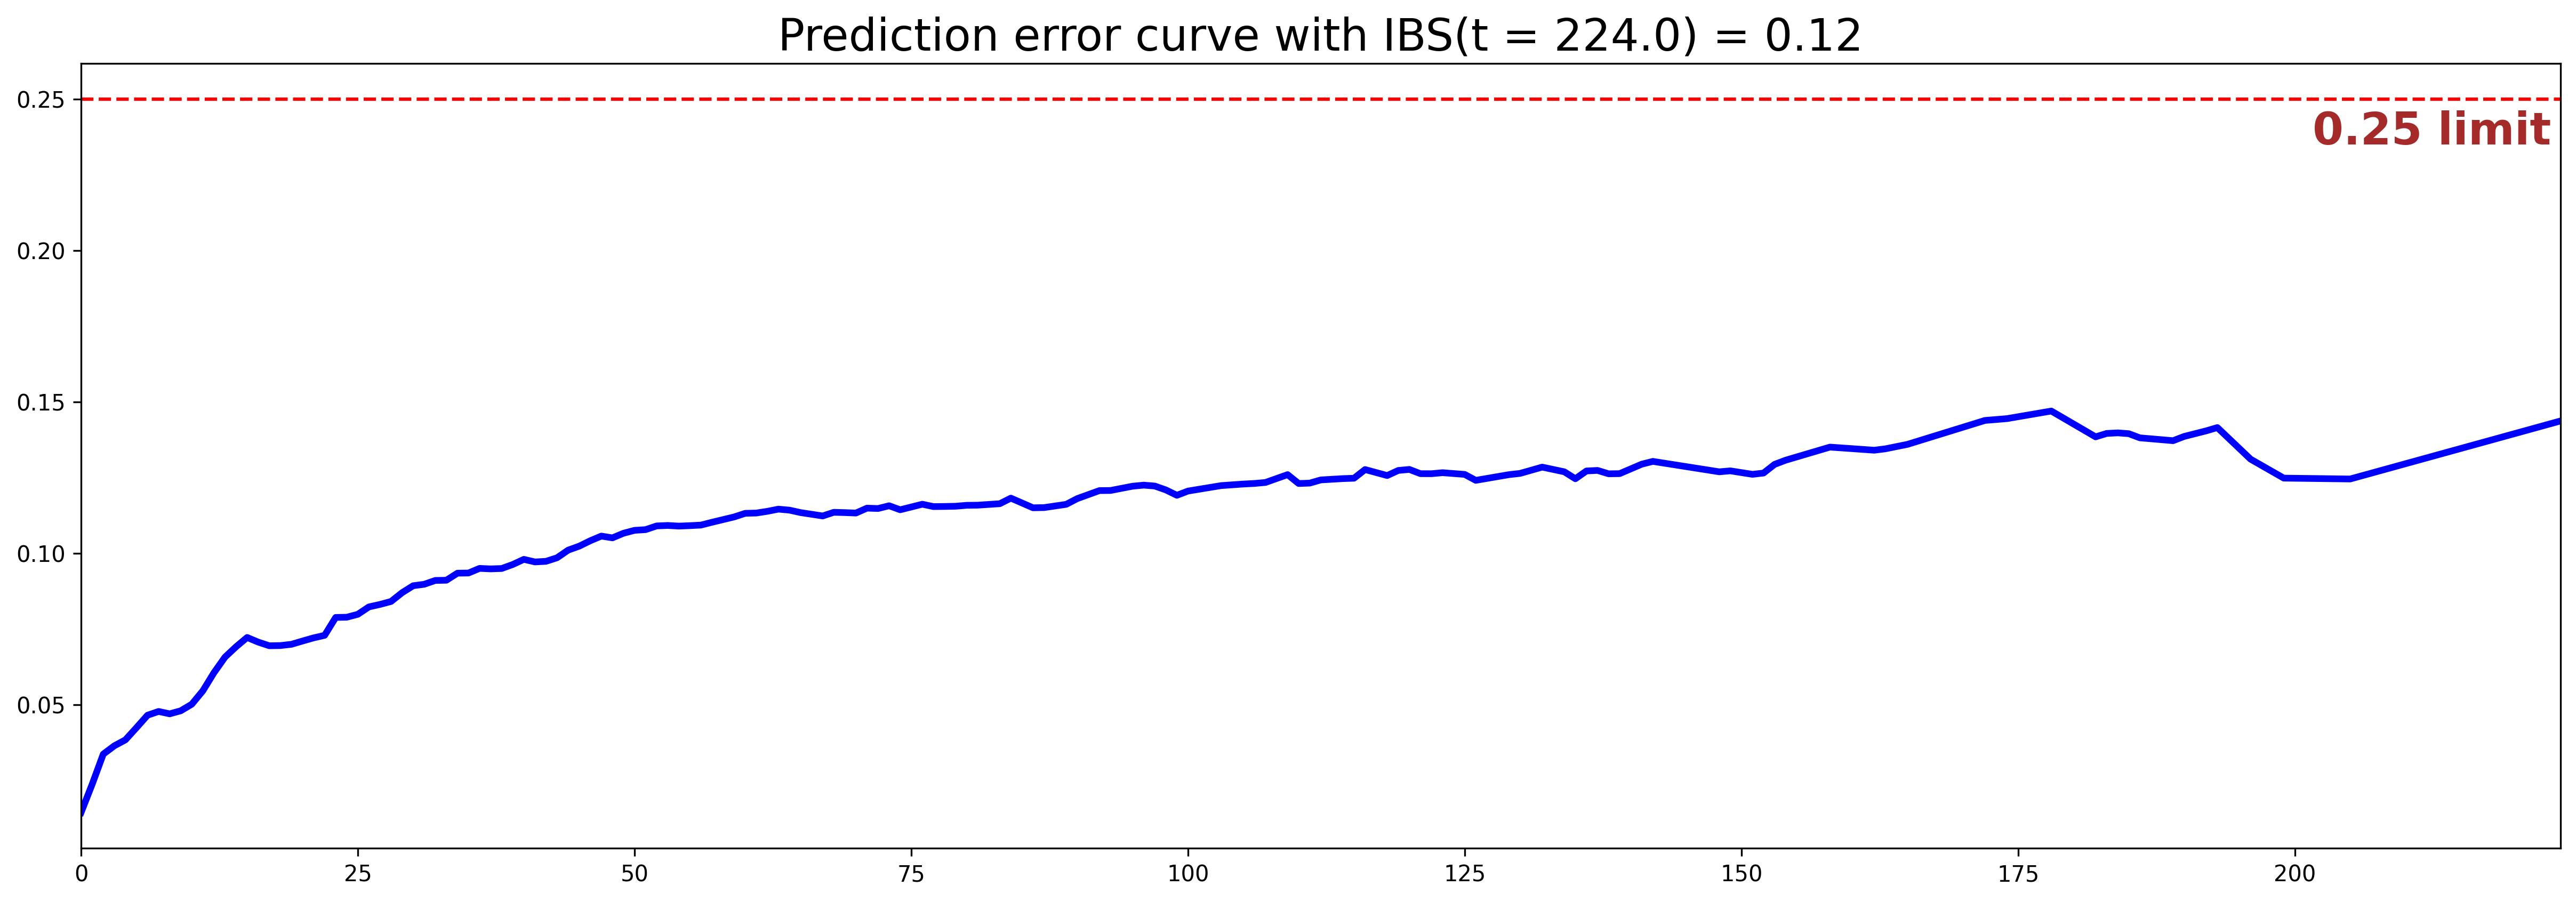

IBS: 0.12


In [404]:
from pysurvival.utils.display import integrated_brier_score
ibs = integrated_brier_score(deepsurv.model, X_test, T_test, E_test, figure_size=(20, 6.5) )
print('IBS: {:.2f}'.format(ibs))

In [405]:
deepsurv.tuning_result['best_param']

{'structure': [{'activation': 'ReLU', 'num_units': 68},
  {'activation': 'SinReLU', 'num_units': 85}],
 'optimizer': 'sgd',
 'lr': 0.00026,
 'num_epochs': 2471,
 'dropout': 0.4,
 'l2_reg': 0.0084,
 'batch_normalization': False}

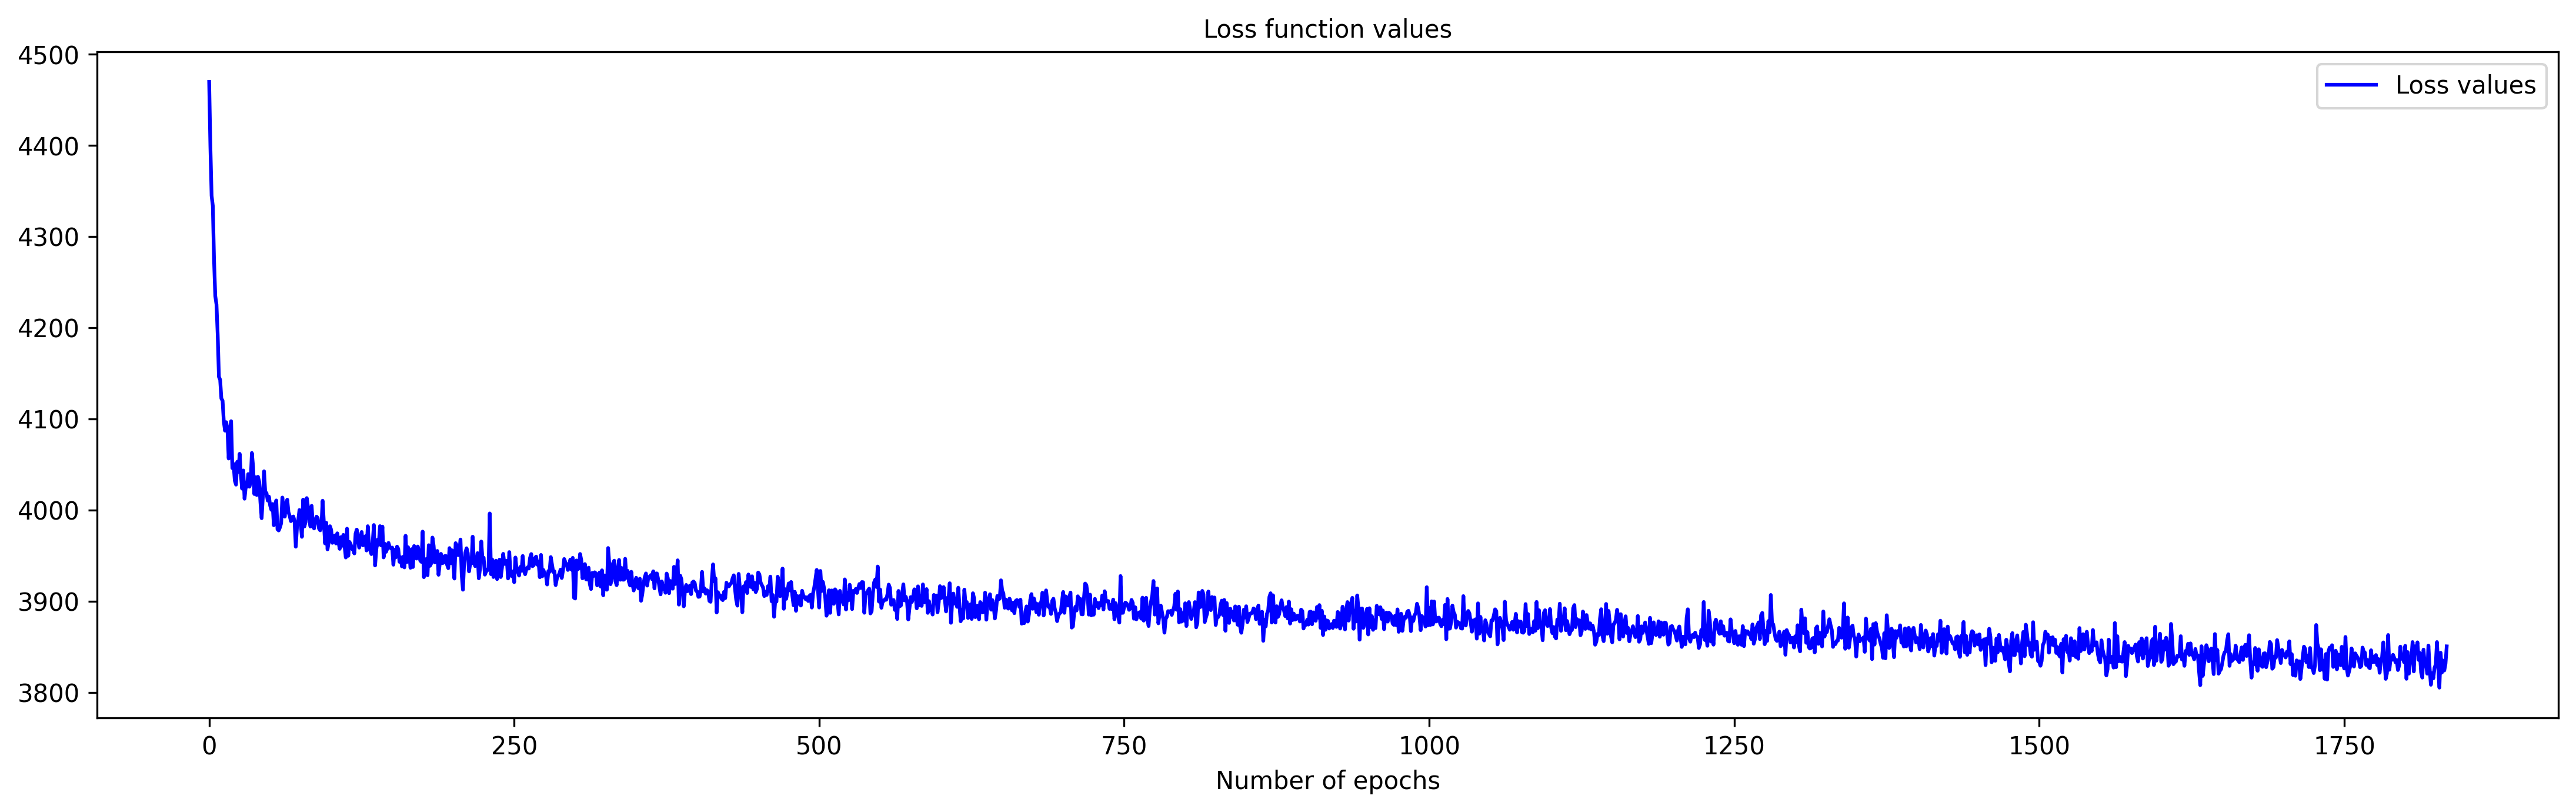

In [277]:
display_loss_values(deepsurv.model)

#### Tuning RSF

In [279]:
rsf = RSF()
rsf.tuning_and_construct(X_train, T_train, E_train,max_iter=max_iter)
rsf_model = rsf.model
c_index = concordance_index(rsf_model, X_test, T_test, E_test)
print('C-index: {:.4f}'.format(c_index))# C-index: 0.7236

Number 1 iteration ... mean_c_index:  0.798889839428799 is the best so far
Number 2 iteration ... mean_c_index:  0.8238315295270426 is the best so far
Number 3 iteration ... mean_c_index:  0.812573942893577 
Number 4 iteration ... mean_c_index:  0.8012832502725292 
Number 5 iteration ... mean_c_index:  0.8286893673074228 is the best so far
Number 6 iteration ... mean_c_index:  0.8158072770726221 
Number 7 iteration ... mean_c_index:  0.7806969110333272 
Number 8 iteration ... mean_c_index:  0.8282856691307918 
Number 9 iteration ... mean_c_index:  0.8067134235239877 
Number 10 iteration ... mean_c_index:  0.8235679444009261 
Number 11 iteration ... mean_c_index:  0.8187879648712698 
Number 12 iteration ... mean_c_index:  0.8153865620709932 
Number 13 iteration ... mean_c_index:  0.7791408420391911 
Number 14 iteration ... mean_c_index:  0.8265964264045872 
Number 15 iteration ... mean_c_index:  0.8106490421204166 
Number 16 iteration ... mean_c_index:  0.8121153698925593 
Number 17 ite

Number 275 iteration ... mean_c_index:  0.8086408416650077 
Number 276 iteration ... mean_c_index:  0.8236343527251613 
Number 277 iteration ... mean_c_index:  0.8099557356688655 
Number 278 iteration ... mean_c_index:  0.8225548350293174 
Number 279 iteration ... mean_c_index:  0.8236958959127969 
Number 280 iteration ... mean_c_index:  0.8240562759981177 
Number 281 iteration ... mean_c_index:  0.8231168412581104 
Number 282 iteration ... mean_c_index:  0.8235054449612995 
Number 283 iteration ... mean_c_index:  0.7815095427280772 
Number 284 iteration ... mean_c_index:  0.7951703170977187 
Number 285 iteration ... mean_c_index:  0.8105510874554831 
Number 286 iteration ... mean_c_index:  0.8235322631591767 
Number 287 iteration ... mean_c_index:  0.8112403510166954 
Number 288 iteration ... mean_c_index:  0.8113196786904926 
Number 289 iteration ... mean_c_index:  0.8077848416646913 
Number 290 iteration ... mean_c_index:  0.8040065430562212 
Number 291 iteration ... mean_c_index:  

Number 412 iteration ... mean_c_index:  0.8272852545054328 
Number 413 iteration ... mean_c_index:  0.7801985816281514 
Number 414 iteration ... mean_c_index:  0.8087444591799547 
Number 415 iteration ... mean_c_index:  0.7895067224513099 
Number 416 iteration ... mean_c_index:  0.8285018182519408 
Number 417 iteration ... mean_c_index:  0.8024307470872506 
Number 418 iteration ... mean_c_index:  0.7638627556143296 
Number 419 iteration ... mean_c_index:  0.7637388752518124 
Number 420 iteration ... mean_c_index:  0.8008444431311699 
Number 421 iteration ... mean_c_index:  0.8252946021601761 
Number 422 iteration ... mean_c_index:  0.8167343742709349 
Number 423 iteration ... mean_c_index:  0.7705034479124327 
Number 424 iteration ... mean_c_index:  0.814880359257641 
Number 425 iteration ... mean_c_index:  0.7775898776766281 
Number 426 iteration ... mean_c_index:  0.803077176903962 
Number 427 iteration ... mean_c_index:  0.8236850236370736 
Number 428 iteration ... mean_c_index:  0.

Number 549 iteration ... mean_c_index:  0.7950065611896312 
Number 550 iteration ... mean_c_index:  0.8199287901365633 
Number 551 iteration ... mean_c_index:  0.8131553477609372 
Number 552 iteration ... mean_c_index:  0.8287686092020629 
Number 553 iteration ... mean_c_index:  0.8279111039334065 
Number 554 iteration ... mean_c_index:  0.7827452437009986 
Number 555 iteration ... mean_c_index:  0.8200232753853814 
Number 556 iteration ... mean_c_index:  0.8295036078803723 
Number 557 iteration ... mean_c_index:  0.8082768077598426 
Number 558 iteration ... mean_c_index:  0.8131356910556589 
Number 559 iteration ... mean_c_index:  0.8222429422813713 
Number 560 iteration ... mean_c_index:  0.8109458192898188 
Number 561 iteration ... mean_c_index:  0.8212608084138223 
Number 562 iteration ... mean_c_index:  0.8121040493524813 
Number 563 iteration ... mean_c_index:  0.80098460733925 
Number 564 iteration ... mean_c_index:  0.8175042679020323 
Number 565 iteration ... mean_c_index:  0.

Number 686 iteration ... mean_c_index:  0.8174735249744414 
Number 687 iteration ... mean_c_index:  0.8093800417646191 
Number 688 iteration ... mean_c_index:  0.8296648938521287 
Number 689 iteration ... mean_c_index:  0.8191335699449827 
Number 690 iteration ... mean_c_index:  0.8261655315353778 
Number 691 iteration ... mean_c_index:  0.7910470232551858 
Number 692 iteration ... mean_c_index:  0.826124283939474 
Number 693 iteration ... mean_c_index:  0.8274278232582943 
Number 694 iteration ... mean_c_index:  0.8084531223939523 
Number 695 iteration ... mean_c_index:  0.7999893618021566 
Number 696 iteration ... mean_c_index:  0.8199958539075805 
Number 697 iteration ... mean_c_index:  0.8202482204680626 
Number 698 iteration ... mean_c_index:  0.8008525096721988 
Number 699 iteration ... mean_c_index:  0.8318871872901014 
Number 700 iteration ... mean_c_index:  0.8178379635588502 
Number 701 iteration ... mean_c_index:  0.8106573954568003 
Number 702 iteration ... mean_c_index:  0

Number 959 iteration ... mean_c_index:  0.806664990416443 
Number 960 iteration ... mean_c_index:  0.8259292149829476 
Number 961 iteration ... mean_c_index:  0.810750212510983 
Number 962 iteration ... mean_c_index:  0.8200777462085845 
Number 963 iteration ... mean_c_index:  0.8285115863556779 
Number 964 iteration ... mean_c_index:  0.8302584145902848 
Number 965 iteration ... mean_c_index:  0.8264795284118021 
Number 966 iteration ... mean_c_index:  0.8097875319788201 
Number 967 iteration ... mean_c_index:  0.8142113700902825 
Number 968 iteration ... mean_c_index:  0.8094604196335335 
Number 969 iteration ... mean_c_index:  0.8105358288076031 
Number 970 iteration ... mean_c_index:  0.8157521161448633 
Number 971 iteration ... mean_c_index:  0.8184444813301468 
Number 972 iteration ... mean_c_index:  0.7963397617517884 
Number 973 iteration ... mean_c_index:  0.8040344125724188 
Number 974 iteration ... mean_c_index:  0.8233562506117362 
Number 975 iteration ... mean_c_index:  0.

In [406]:
c_index_train = concordance_index(rsf.model, X_train, T_train, E_train)
c_index_test = concordance_index(rsf.model, X_test, T_test, E_test)
print('C-index of train: {:.4f}; C-index of test: {:.4f}'.format(c_index_train,c_index_test)) #C-index: 0.6996


C-index of train: 0.8288; C-index of test: 0.8029


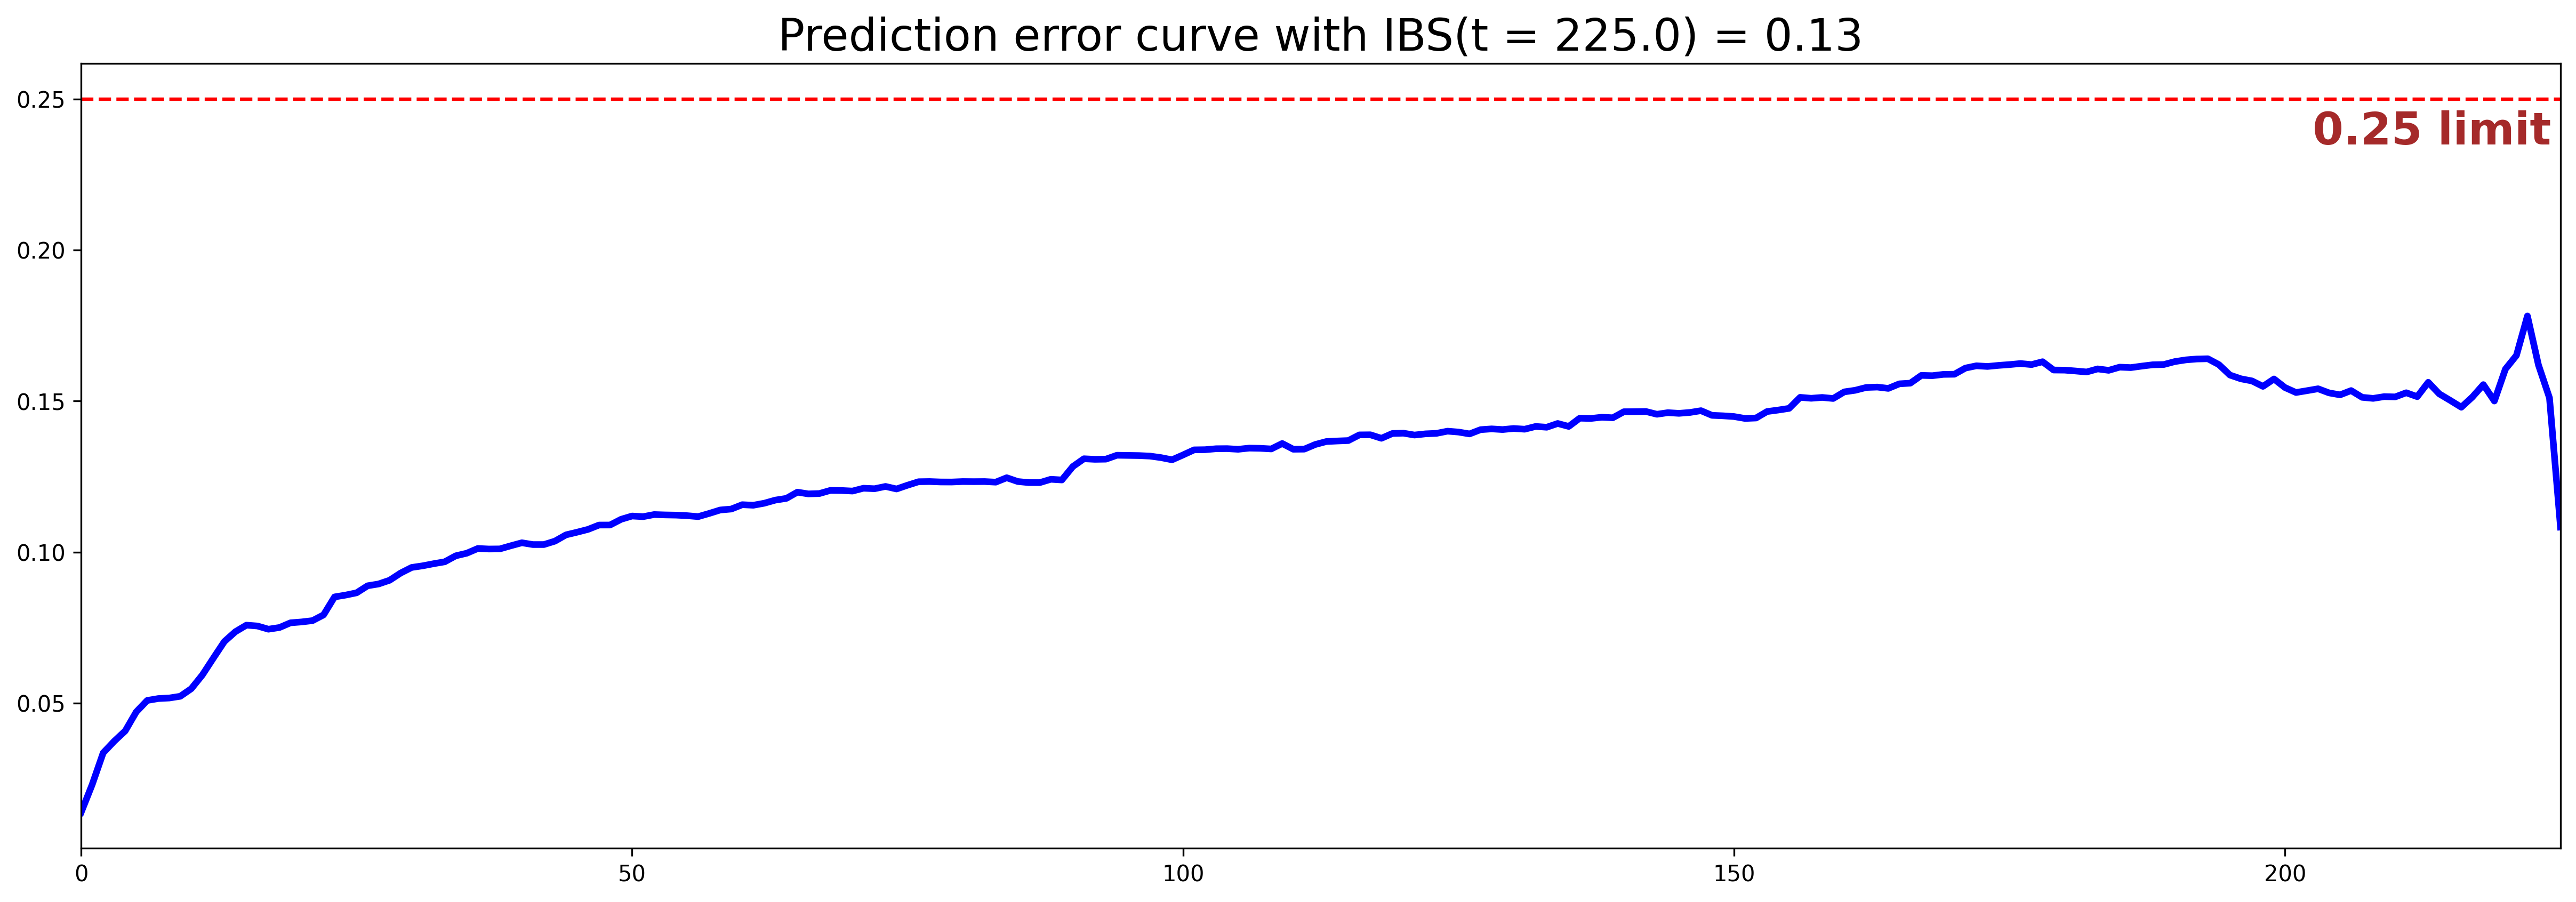

IBS: 0.13


In [407]:
from pysurvival.utils.display import integrated_brier_score
ibs = integrated_brier_score(rsf.model, X_test, T_test, E_test, figure_size=(20, 6.5) )
print('IBS: {:.2f}'.format(ibs))

In [282]:
rsf.tuning_result['best_param']

{'num_trees': 491,
 'max_features': 'log2',
 'min_node_size': 24,
 'sample_size_pct': 0.6,
 'importance_mode': 'permutation'}

## Metrics

In [286]:
save_path = './output/'
import os
if not os.path.exists(save_path):
    os.mkdir(save_path)

### Generate data for prediction error curve

In [ ]:
from pysurvival.utils.metrics import brier_score
t_max = max(T_test)

times_cph, brier_scores_cph = brier_score(cph_model, X_test, T_test, E_test, t_max=t_max, use_mean_point=True)
ibs_cph =  np.trapz(brier_scores_cph, times_cph)/t_max 

times_nmtlr, brier_scores_nmtlr = brier_score(nmtlr.model,  X_test, T_test, E_test, t_max=t_max, use_mean_point=True)
ibs_nmtlr =  np.trapz(brier_scores_nmtlr, times_nmtlr)/t_max

times_deepsurv, brier_scores_deepsurv = brier_score(deepsurv.model,  X_test, T_test, E_test, t_max=t_max, use_mean_point=True)
ibs_deepsurv =  np.trapz(brier_scores_deepsurv, times_deepsurv)/t_max

times_rsf, brier_scores_rsf = brier_score(rsf.model,  X_test, T_test, E_test, t_max=t_max, use_mean_point=True)
ibs_rsf =  np.trapz(brier_scores_rsf, times_rsf)/t_max

pd.DataFrame(
    {'times':times_cph+times_nmtlr+times_deepsurv+times_rsf,
    'brier_scores':brier_scores_cph+brier_scores_nmtlr+brier_scores_deepsurv+brier_scores_rsf,
    'models':['CoxPH (IBS: {:.4f})'.format(ibs_cph) for i in brier_scores_cph] + ['NMTLR (IBS: {:.4f})'.format(ibs_nmtlr) for i in brier_scores_nmtlr]+['DeepSurv (IBS: {:.4f})'.format(ibs_deepsurv) for i in brier_scores_deepsurv]+['RSF (IBS: {:.4f})'.format(ibs_rsf) for i in brier_scores_rsf]
            }).to_csv(os.path.join(save_path,'brier_score.csv'))

### Generate data for calibration curves and roc curves

In [ ]:
def generate_prediction_by_year(time_=12,file_name='1 year prediction.csv'):
    index = -((T_test<=time_) & (E_test == 0))
    X_ = X_test.loc[index,:].reset_index(drop=True)
    T_ = T_test[index].reset_index(drop=True)
    E_ = E_test[index].reset_index(drop=True)
    survival_cph = cph_model.predict_survival(X_,t=time_)
    survival_nmtlr = nmtlr.model.predict_survival(X_,t=time_)
    survival_deepsurv = deepsurv.model.predict_survival(X_,t=time_)
    survival_rsf = rsf.model.predict_survival(X_,t=time_)

    pd.DataFrame(
        {'event':[1 if T_[i] >= time_ else 0 for i in range(len(T_))] * 4,
        'survival':survival_cph.tolist()+survival_nmtlr.tolist()+survival_deepsurv.tolist()+survival_rsf.tolist(),
        'models':['CoxPH' for i in T_] + ['NMTLR' for i in T_]+['DeepSurv' for i in T_]+['RSF' for i in T_]
                }).to_csv(os.path.join(save_path,file_name))
generate_prediction_by_year(time_=12,file_name='1 year prediction.csv')
generate_prediction_by_year(time_=36,file_name='3 year prediction.csv')
generate_prediction_by_year(time_=60,file_name='5 year prediction.csv')
generate_prediction_by_year(time_=120,file_name='10 year prediction.csv')

### Generate data for Loss converge graph

In [351]:
pd.DataFrame(
{'loss_values':deepsurv.model.loss_values}
).to_csv(os.path.join(save_path,'deesurv_loss_values.csv'))

In [352]:
pd.DataFrame(
{'loss_values':nmtlr.model.loss_values}
).to_csv(os.path.join(save_path,'nmtlr_loss_values.csv'))

###  Feature importance plot

In [353]:
for col in X_train:
    print(col)
X_train.columns

Age
Distant metastasis
Gender
Grade
Histological type
Primary site
Surgery
Tumor extension
Tumor size


Index(['Age', 'Distant metastasis', 'Gender', 'Grade', 'Histological type',
       'Primary site', 'Surgery', 'Tumor extension', 'Tumor size'],
      dtype='object')

In [367]:
def variableImportance(model, X, T, E):
    ctmp = concordance_index(model, X, T, E)
    imps = []
    for column in X:
        tmpX = X.copy()
        tmpX[column] = np.random.permutation(tmpX[column])
        ctmp2 = concordance_index(model, tmpX, T, E)
        imps.append((ctmp - ctmp2)/ctmp)
    return imps

In [372]:
imp_df = pd.DataFrame(
    {
        'DeepSurv': variableImportance(deepsurv.model, X_test, T_test, E_test),
        'NMTLR': variableImportance(nmtlr.model, X_test, T_test, E_test),
        'RSF': variableImportance(rsf.model, X_test, T_test, E_test),
    },
    index= X_test.columns
)
imp_df['Average'] = imp_df.mean(axis=1)
print(imp_df)

                    DeepSurv     NMTLR       RSF   Average
Age                 0.103887  0.129591  0.095485  0.109654
Distant metastasis  0.034785  0.053779  0.042437  0.043667
Gender              0.010009  0.008154  0.000111  0.006091
Grade               0.030944  0.026790  0.033712  0.030482
Histological type   0.034564  0.043916  0.031181  0.036554
Primary site        0.022711  0.015049  0.006007  0.014589
Surgery             0.006003  0.000291 -0.001490  0.001601
Tumor extension     0.007857  0.037976  0.017377  0.021070
Tumor size          0.077076  0.059439  0.059115  0.065210


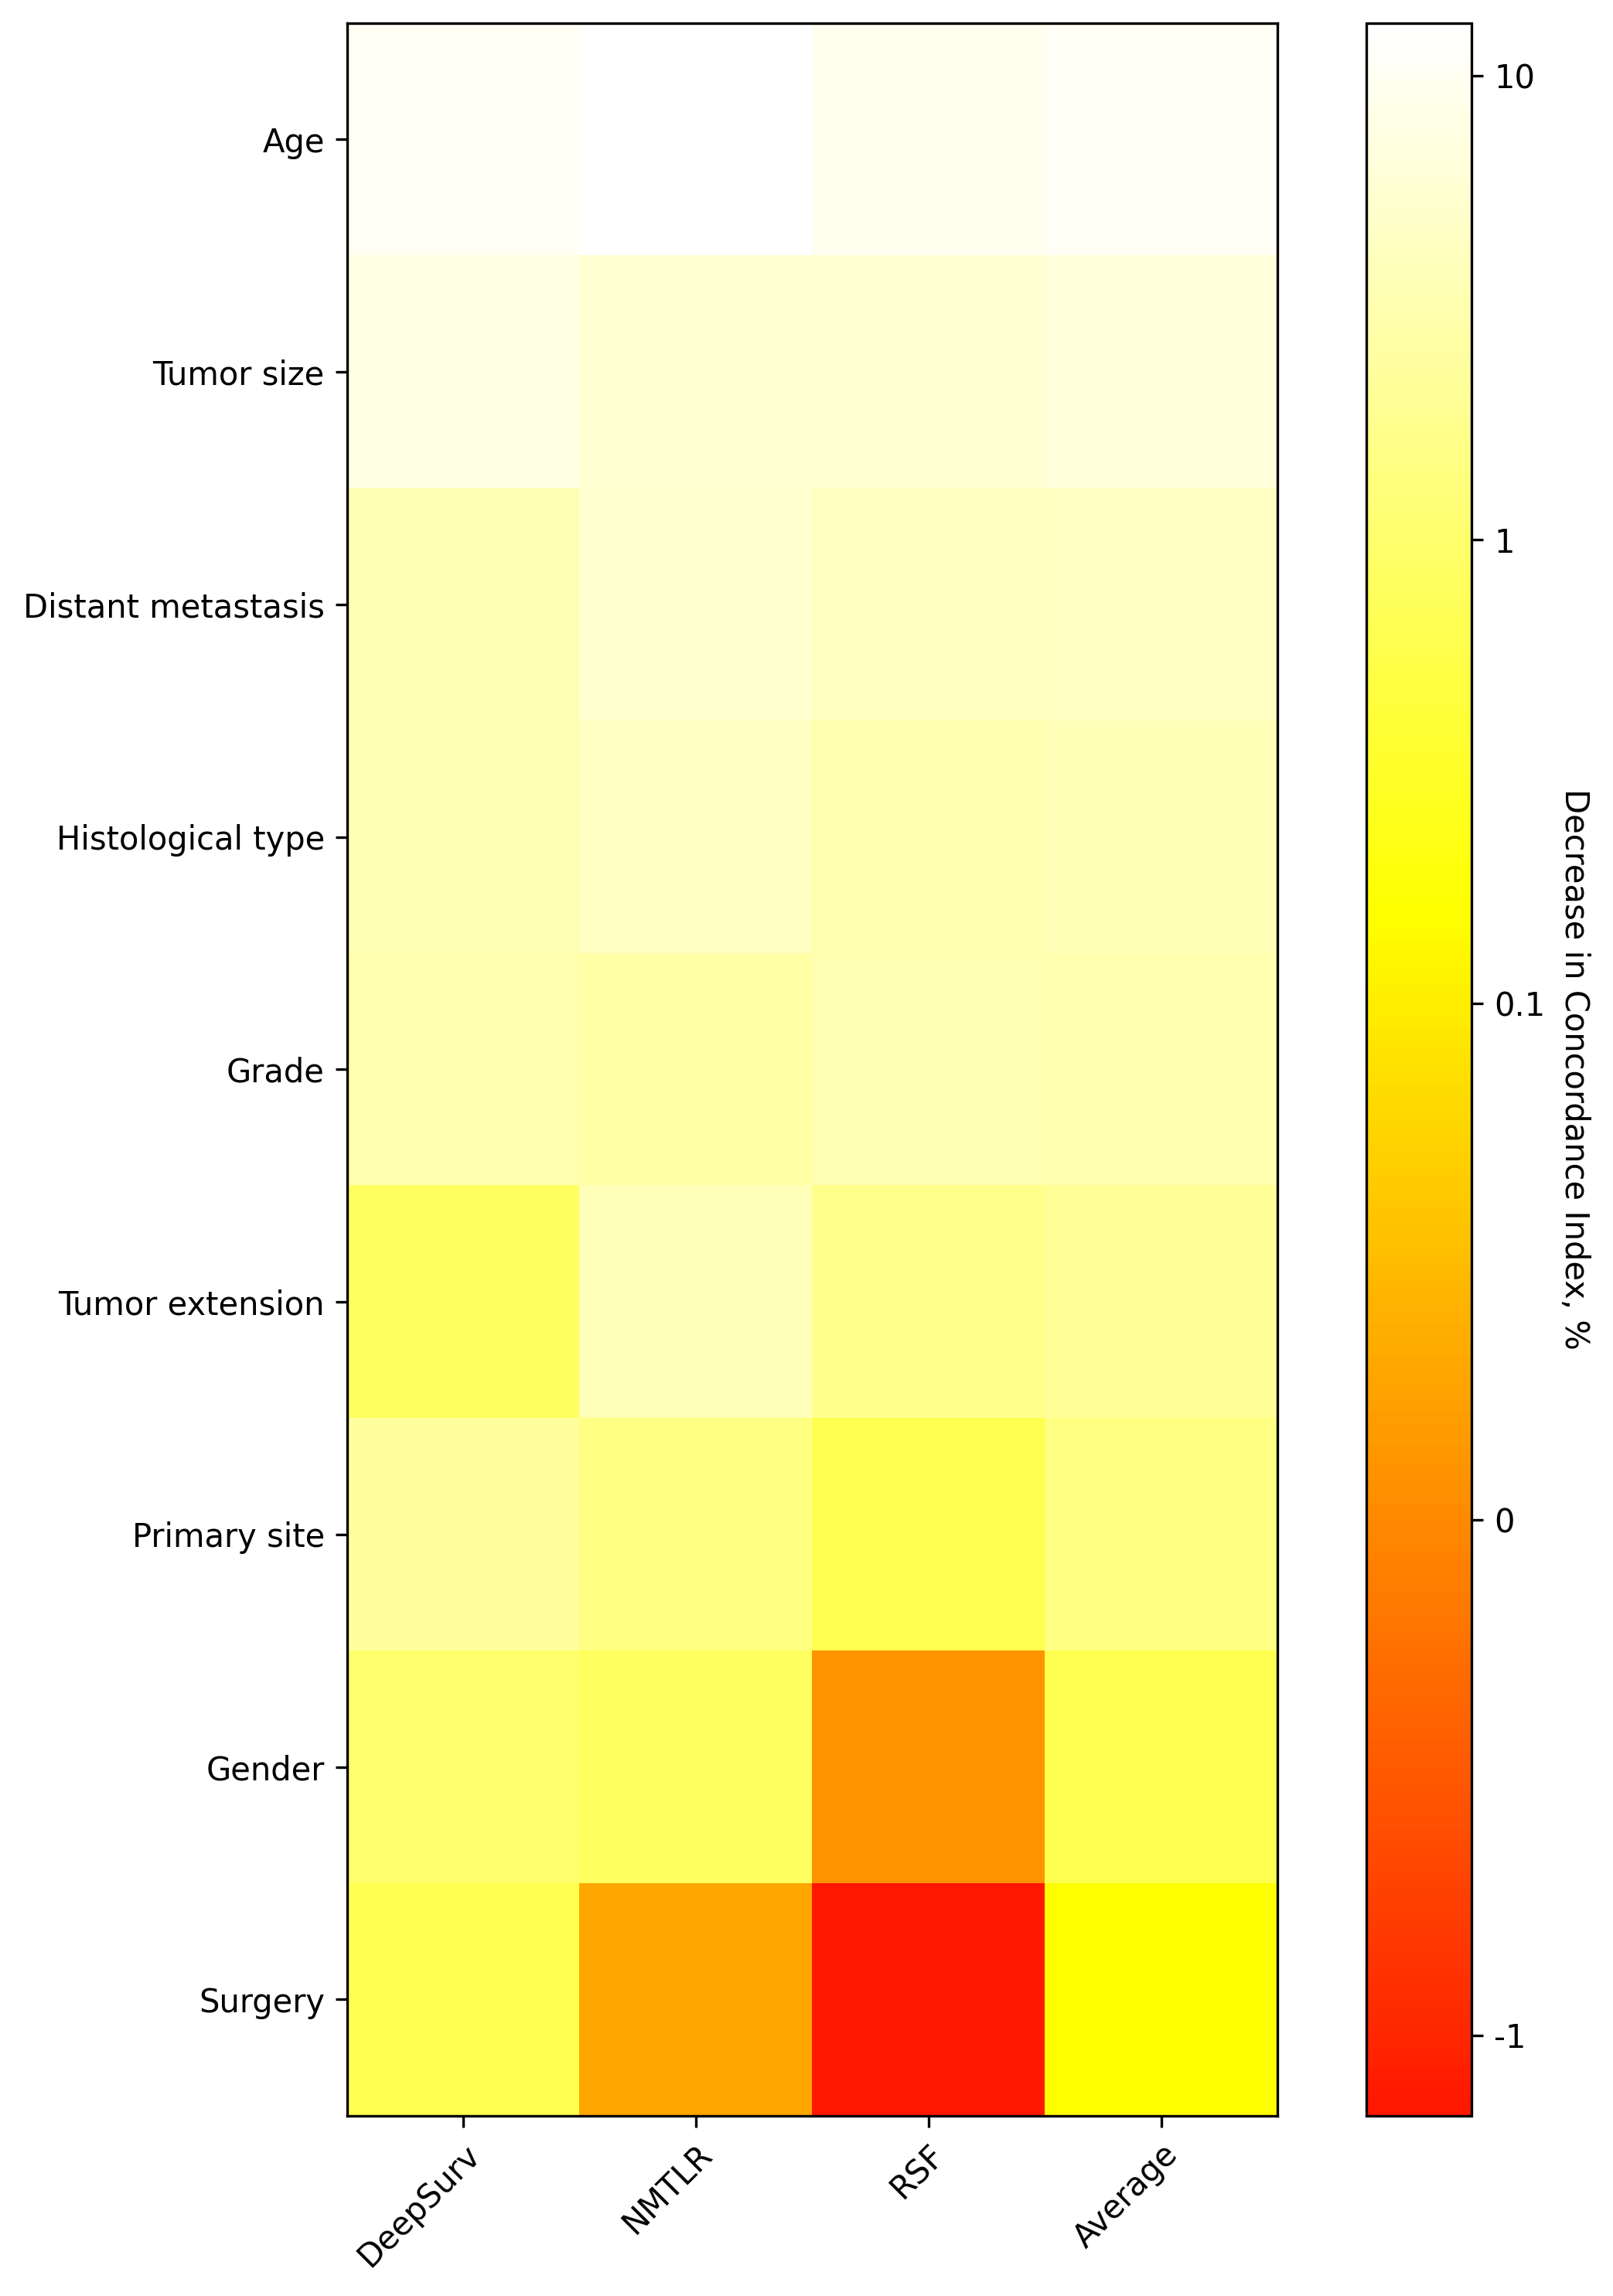

In [376]:
def plotFeatureImportance(a):
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    import matplotlib.cm as cm
    import matplotlib.colors as colors
    mpl.rcParams['figure.dpi'] = 300
    # a = pd.read_csv(feature_filename)
    a = a.sort_values(by=['Average'], ascending=False)
    fig, ax = plt.subplots(figsize=(8, 10))

    def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
        new_cmap = colors.LinearSegmentedColormap.from_list(
            'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
            cmap(np.linspace(minval, maxval, n)))
        return new_cmap

    im = ax.imshow(a[['DeepSurv', 'NMTLR', 'RSF', 'Average']],
                   cmap=truncate_colormap(cm.get_cmap("hot"), minval=0.4, maxval=1), norm=colors.SymLogNorm(1e-3))
    # im.set_clim(-5, -2)
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Decrease in Concordance Index, %", rotation=-90, va="bottom")
    # cbar.ax.set_aspect(50)
    cbar.set_ticks([0.1,0.01,0.001,0,-0.001])
    cbar.set_ticklabels(['10',"1","0.1",0,'-1'])

    ax.set_yticks(np.arange(len(a)))
    ax.set_xticks(np.arange(len(a.columns)))
    ax.set_xticklabels(['DeepSurv', 'NMTLR', 'RSF', 'Average'])
    ax.set_yticklabels(a.index)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    fig.tight_layout()
    plt.savefig("./Figures/variable.eps")
    plt.show()
plotFeatureImportance(imp_df)

### Save models

In [381]:
from pysurvival.utils import save_model
save_model(cph_model, os.path.join(save_path,'CoxPH.zip'))
save_model(deepsurv.model, os.path.join(save_path,'DeepSurv.zip'))
save_model(nmtlr.model, os.path.join(save_path,'NMTLR.zip'))
save_model(rsf.model, os.path.join(save_path,'RSF.zip'))

/var/folders/9y/04p_lrdx74x2xkyfbd8l_rkh0000gn/T/ipykernel_2168/493551809.py:2: FutureWarning: 'pyarrow.serialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  save_model(cph_model, os.path.join(save_path,'CoxPH.zip'))
/var/folders/9y/04p_lrdx74x2xkyfbd8l_rkh0000gn/T/ipykernel_2168/493551809.py:3: FutureWarning: 'pyarrow.serialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  save_model(deepsurv.model, os.path.join(save_path,'DeepSurv.zip'))
/var/folders/9y/04p_lrdx74x2xkyfbd8l_rkh0000gn/T/ipykernel_2168/493551809.py:4: FutureWarning: 'pyarrow.serialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  save_model(nmtlr.model, os.path.join(save_path,'NMTLR.zip'))
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/utils/__init__

Saving the model to disk as ./output/CoxPH.zip
Saving the model to disk as ./output/DeepSurv.zip
Saving the model to disk as ./output/NMTLR.zip
Saving the model to disk as ./output/RSF.zip
